# \<Title\>

## NEVER 'RUN ALL' (!) 

Imports

In [1]:
import os
import sys
import logging
import datetime
import dill as pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd

Import custom libraries

In [2]:
# original py files
sys.path.insert(1, 'methods')

from data_methods import getData, standardize
from dimensionality_reduction import reduce_dimensionality,reduce_with
from beamSearch import EMM, as_string
from adjPysubgroup import adjustedBestFirstSearch, adjustedDFS, adjustedApriori
from qualityMeasures import calc_result_bs, calc_result_ps
from interpretabilityMeasures import Feature_Correlation_Scores, DBI_beam, DBI_ps

## 1. Functions

In [4]:
def export_results(save_path,file_name,data):
    """Function to export the data to a temporary or final file.
    save_path: directory/folder to which the data should be saved.
    file_name: name of the file
    data: data that should be saved
    """
    file_path = os.path.join(save_path,file_name)
    with open(file_path,'wb') as f:
        pickle.dump(data,f)
    
    print(f"{'Temporary results' if 'temp' in file_name else 'Results'} saved to {file_path}")


def run_search_method(search_method, method_name, df, save_path, reduction_method):
    """
    Method that runs a search method for the original and the encoded data, and returns the results in a dictionary 
    search_method: search method which is a function
    method_name: name of the search method to create temporary file_name
    df: input dataframe
    save_path: path to which temporary data should be saved
    """
    # original data
    start_time = datetime.datetime.now()
    results = search_method(df)
    if 'BS' not in method_name:
        results['subgroup'] = results['subgroup'].apply(lambda x: str(x))
    running_time = datetime.datetime.now() - start_time

    data = {
        'results_org': results,
        'running_time_org': running_time,
    }

    export_results(save_path,f'temp-results-{method_name}-{reduction_method}.pkl',data)

    return data


def get_results_dataset(dataset_name : str, optimal_features: dict, num_epochs = 100, save_path = 'sd_results',dct_data=None):

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # ---------=| open data |=---------
    print(f'Opening the {dataset_name} dataset...')
    df, cat, num, features = getData(dataset_name)

    # ---------=| reduce dimensionality |=---------
    if dct_data is None:
        print('Reducing dimensionality...')
        dct_data={
            'vanilla': df.copy(),
        }

        for reduction_method in ['auto_encoder', 'PCA', 'SPCA']:
            df_encoded,_ = reduce_dimensionality(
                    data=df,
                    reduction_method=reduction_method,
                    catColumns=cat,
                    numColumns=num, 
                    nFeatures=optimal_features[reduction_method],
                    nEpochs=num_epochs
                )
            
            dct_data[reduction_method]=df_encoded.copy()
            # temporary export as safety feature
            export_results(save_path,f'{dataset_name}-temp-results-reductions-{reduction_method}.pkl',dct_data)
        
        # export all data
        export_results(save_path,f'{dataset_name}-data-reductions.pkl',dct_data)
    else:
        print('Data was already reduced')


    # ---------=| find subgroups |=---------
    print('Finding subgroups...')

    beamSearch = lambda df_: EMM(100, 3, 100, [], df_, 'target', ensure_diversity=True, prnt=True)
    dct_results = {}

    # iterate over all types of dimensionality reduction and all search methods
    for reduction_method in ['vanilla', 'auto_encoder', 'PCA', 'SPCA']:
        print(reduction_method)
        
        print(' -> starting BFS')
        # - Best-First Search
        dct_bfs = run_search_method(adjustedBestFirstSearch,f'BFS-{dataset_name}',dct_data[reduction_method],save_path, reduction_method)

        print(' -> starting DFS')
        # - Depth-First Search
        dct_dfs = run_search_method(adjustedDFS,f'DFS-{dataset_name}',dct_data[reduction_method],save_path, reduction_method)

        print(' -> starting Apriori')
        # - Apriori
        dct_apri = run_search_method(adjustedApriori,f'APRI-{dataset_name}',dct_data[reduction_method],save_path, reduction_method)

        print(' -> starting Beam Search')
        # - Beam Search      
        dct_bs = run_search_method(beamSearch,f'BS-{dataset_name}',dct_data[reduction_method],save_path, reduction_method)

        # save results to overall dictionary
        dct_results[reduction_method] = {
            'Best-First Search':dct_bfs,
            'Depth-First Search':dct_dfs,
            'Apriori':dct_apri,
            'Beam Search':dct_bs
        }

        # save intermediate results
        now = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")
        export_results(save_path,f'{dataset_name}-temp-results-{reduction_method}-{now}.pkl',dct_results)
    
    # ---------=| export all results |=---------
    print("Exporting Results...")

    now = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")
    export_results(save_path,f'{dataset_name}-results-{now}.pkl',dct_results)
    
    return dct_results

## 2. Find Optimal Numbers of Features

In [5]:
def plot_mse_vs_nfeatures(dct_datasets,name_dataset,reduction_method,l_est,r_est):

    df = dct_datasets[name_dataset]['df']
    cat = dct_datasets[name_dataset]['cat']
    num = dct_datasets[name_dataset]['num']

    start_time = datetime.datetime.now()
    mseList = []

    for i in range(l_est, r_est+1):

        _,mse = reduce_dimensionality(
                    data=df,
                    reduction_method=reduction_method,
                    catColumns=cat,
                    numColumns=num, 
                    nFeatures=i,
                    nEpochs=100
                )

        mseList.append(mse)

    running_time = datetime.datetime.now()-start_time

    plt.plot([i for i in range(l_est, r_est+1)], mseList)
    plt.xlabel("Nr of Features") # ! new
    plt.ylabel("MSE") # ! new
    plt.show()

    print(running_time)

In [6]:
# get all datasets
lst_dataset_names = ["Ionosphere","Mushroom","Adult","Soybean","Arrhythmia", "Indoor"] #,"Indoor" not in data folder
dct_datasets = {name:{key:val for val,key in zip(getData(name),['df','cat','num','features'])} for name in lst_dataset_names}

# define min and max estimates of nr of features
l_est,r_est=2,12
dct_optimal_features = {}

### 2.1 Ionosphere

In [8]:
dct_ion = {}

#### 2.1.1 Auto-Encoder

11/11 [==============================] - 0s 1ms/step


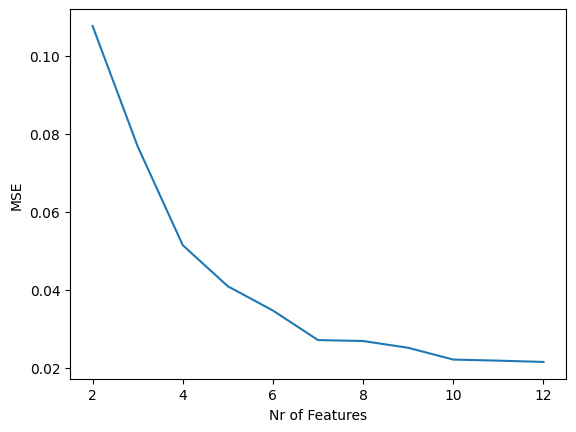

In [8]:
plot_mse_vs_nfeatures(dct_datasets,'Ionosphere','auto_encoder',l_est,r_est)

In [9]:
dct_ion['auto_encoder'] = 5

#### 2.1.2 PCA

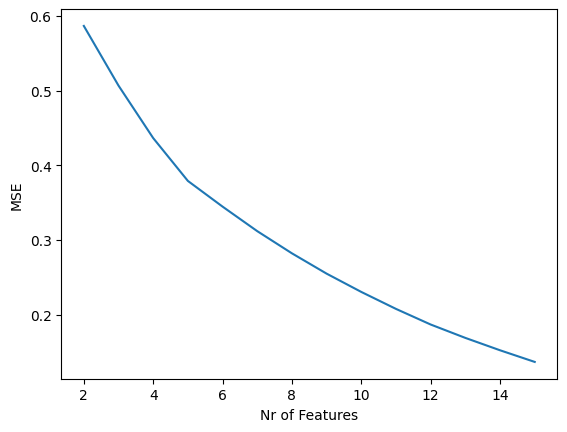

In [10]:
plot_mse_vs_nfeatures(dct_datasets,'Ionosphere','PCA',l_est,r_est=15)

In [10]:
dct_ion['PCA'] = 5 

#### 2.1.3 Sparse-PCA

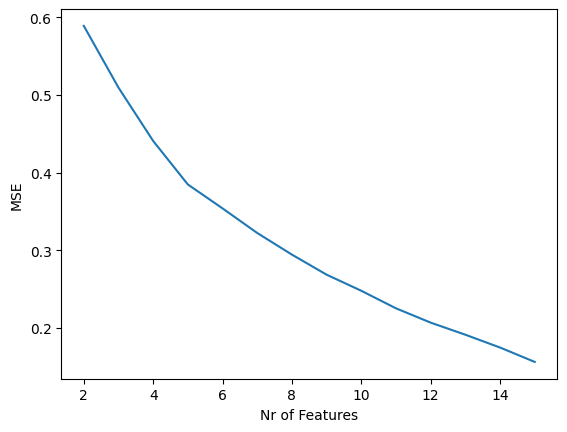

In [12]:
plot_mse_vs_nfeatures(dct_datasets,'Ionosphere','SPCA',l_est,r_est=15)

In [11]:
dct_ion['SPCA'] = 5 

### 2.2 Mushroom

In [6]:
dct_shroom = {}

#### 2.2.1 Auto-Encoder

254/254 [==============================] - 0s 2ms/step


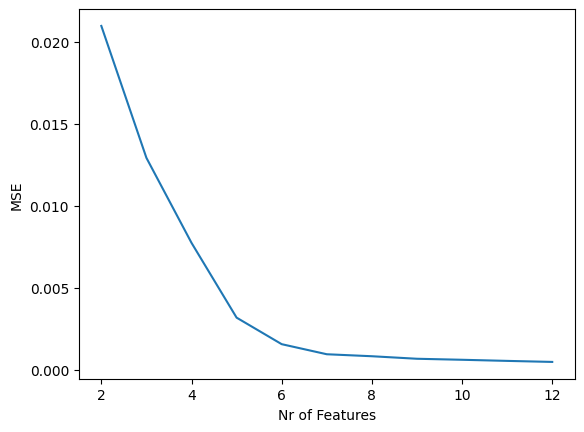

In [15]:
plot_mse_vs_nfeatures(dct_datasets,'Mushroom','auto_encoder',l_est,r_est)

In [7]:
dct_shroom['auto_encoder'] = 5

#### 2.2.2 PCA

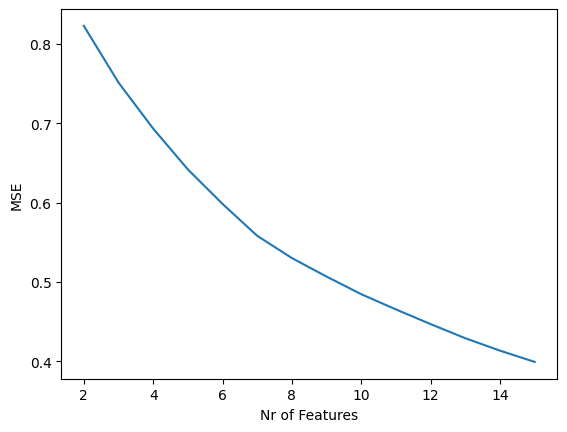

0:00:01.078623


In [8]:
plot_mse_vs_nfeatures(dct_datasets,'Mushroom','PCA',l_est,r_est=15)

In [9]:
dct_shroom['PCA'] = 7

#### 2.2.3 SPCA

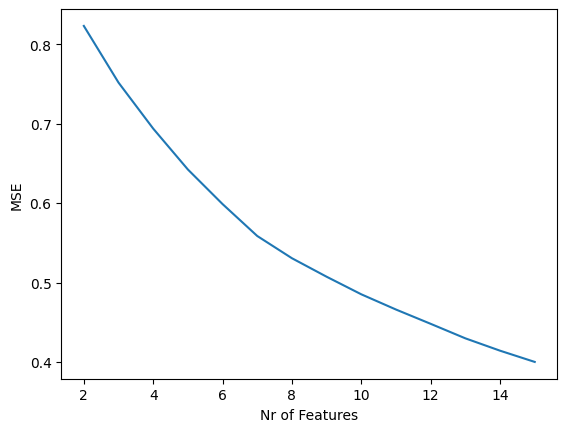

In [19]:
plot_mse_vs_nfeatures(dct_datasets,'Mushroom','SPCA',l_est,r_est=15)

In [10]:
dct_shroom['SPCA'] = 7

### 2.3 Adult

In [11]:
dct_adult = {}

#### 2.3.1 Auto-Encoder

1527/1527 [==============================] - 2s 2ms/step


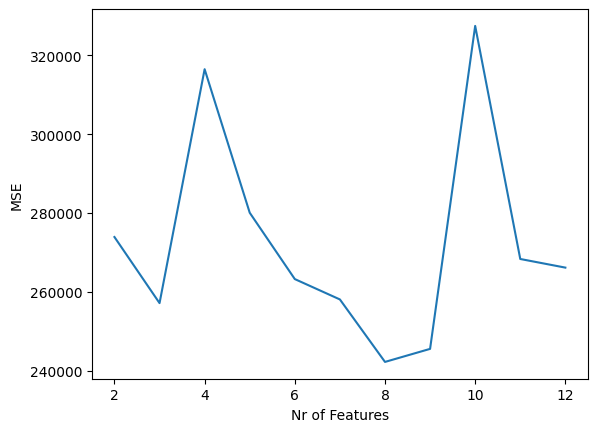

In [22]:
plot_mse_vs_nfeatures(dct_datasets,'Adult','auto_encoder',l_est,r_est)

In [12]:
dct_adult['auto_encoder'] = 3

#### 2.3.2 PCA

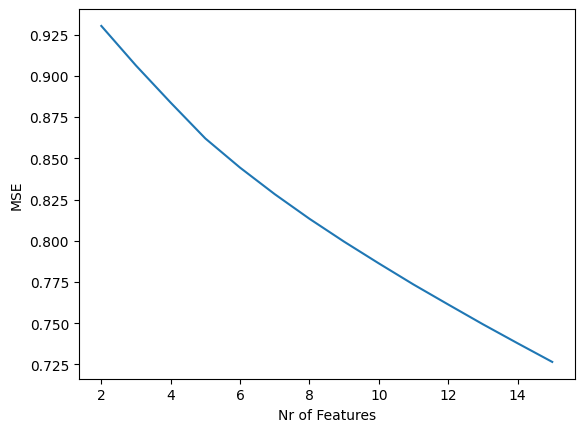

In [24]:
plot_mse_vs_nfeatures(dct_datasets,'Adult','PCA',l_est,r_est=15)

In [13]:
dct_adult['PCA'] = 5 #Not entirely sure here. Theres a small elbow at 5, but its pretty constant

#### 2.3.3 SPCA

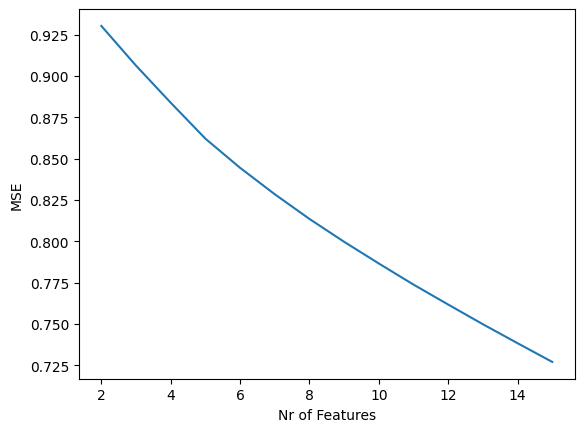

In [26]:
plot_mse_vs_nfeatures(dct_datasets,'Adult','SPCA',l_est,r_est=15)

In [14]:
dct_adult['SPCA'] = 5 #Same comment as above

### 2.4 Soybean

In [20]:
dct_soy = {}

#### 2.4.1 Auto-Encoder

9/9 [==============================] - 0s 873us/step


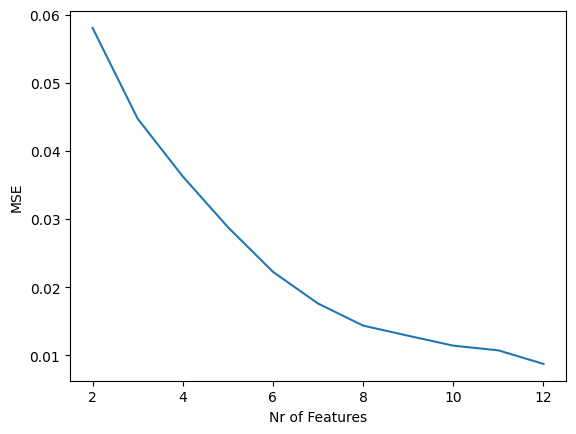

In [29]:
plot_mse_vs_nfeatures(dct_datasets,'Soybean','auto_encoder',l_est,r_est)

In [21]:
dct_soy['auto_encoder'] = 6 # This seems to be the second elbow but feels right haha

#### 2.4.2 PCA

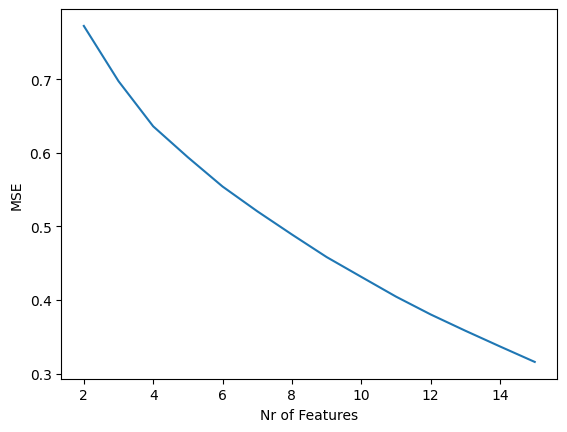

In [31]:
plot_mse_vs_nfeatures(dct_datasets,'Soybean','PCA',l_est,r_est=15)

In [22]:
dct_soy['PCA'] = 4

#### 2.4.3 SPCA

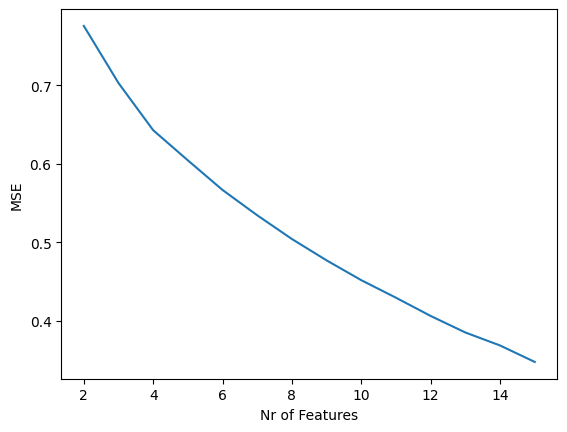

In [33]:
plot_mse_vs_nfeatures(dct_datasets,'Soybean','SPCA',l_est,r_est=15)

In [23]:
dct_soy['SPCA'] = 4

### 2.5 Arrhythmia

In [24]:
dct_arrh = {}

#### 2.5.1 Auto-Encoder

14/14 [==============================] - 0s 2ms/step


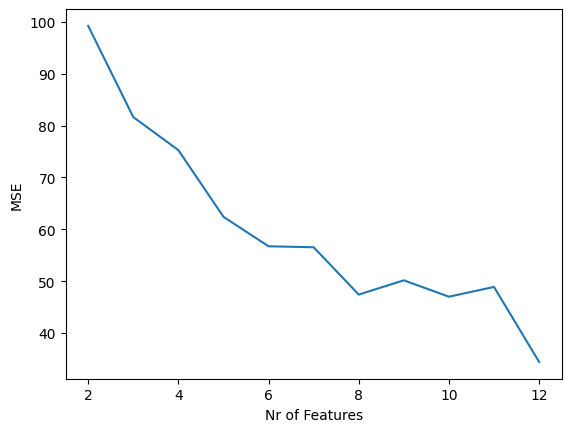

In [36]:
plot_mse_vs_nfeatures(dct_datasets,'Arrhythmia','auto_encoder',l_est,r_est)

In [25]:
dct_arrh['auto_encoder'] = 5 # or 6? (lory: i left it as 5, seemed ok)

#### 2.5.2 PCA

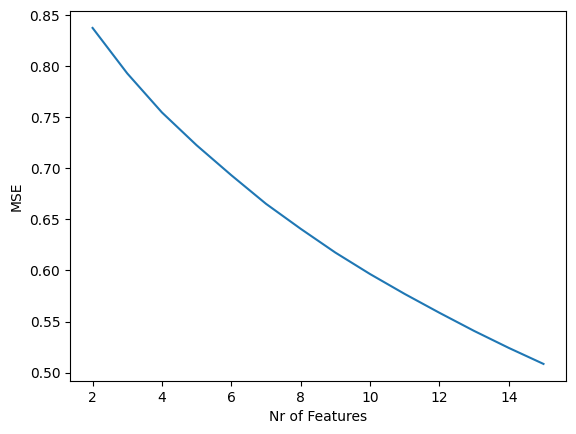

In [38]:
plot_mse_vs_nfeatures(dct_datasets,'Arrhythmia','PCA',l_est,r_est=15)

In [26]:
dct_arrh['PCA'] = 4 # or 5? (lory: i left it as 4)

#### 2.5.3 SPCA

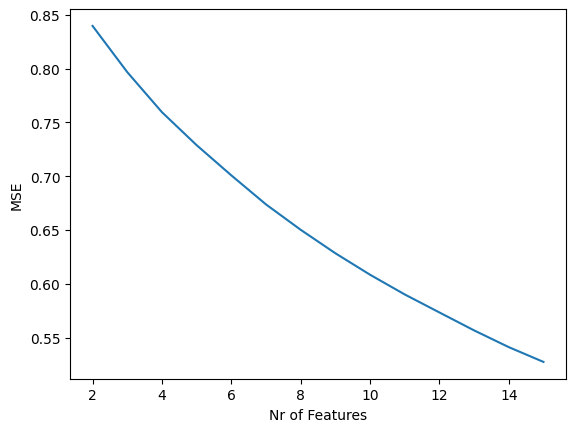

In [40]:
plot_mse_vs_nfeatures(dct_datasets,'Arrhythmia','SPCA',l_est,r_est=15)

In [27]:
dct_arrh['SPCA'] = 4

### 2.6 Indoor

In [28]:
dct_indoor = {}

#### 2.6.1 Auto-Encoder

658/658 [==============================] - 1s 1ms/step


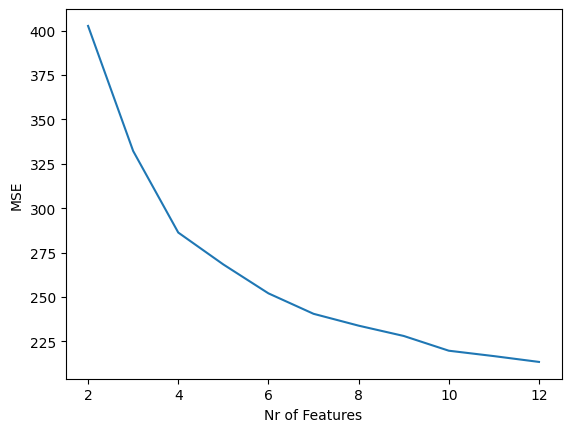

In [43]:
plot_mse_vs_nfeatures(dct_datasets,'Indoor','auto_encoder',l_est,r_est)

In [29]:
dct_indoor['auto_encoder'] = 4

#### 2.6.2 PCA

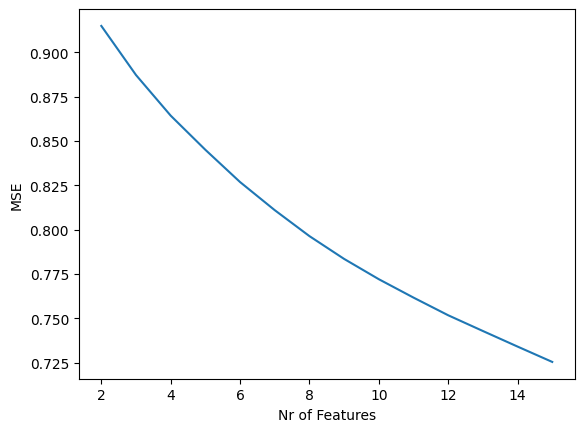

In [45]:
plot_mse_vs_nfeatures(dct_datasets,'Indoor','PCA',l_est,r_est=15)

In [30]:
dct_indoor['PCA'] = 4

#### 2.6.3 SPCA

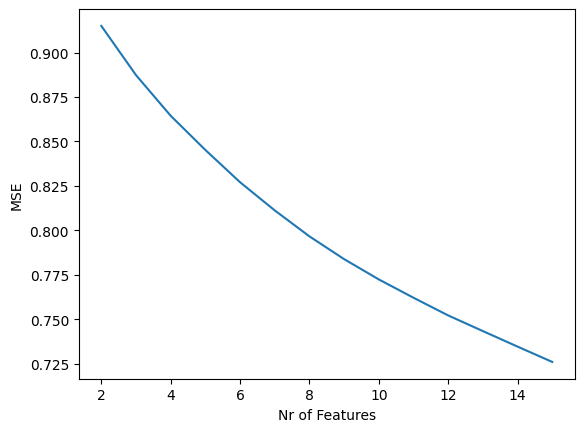

In [47]:
plot_mse_vs_nfeatures(dct_datasets,'Indoor','SPCA',l_est,r_est=15)

In [31]:
dct_indoor['SPCA'] = 4

### 2.7 General Dictionary

In [15]:
dct_opt_feat = {
    'Ionosphere':dct_ion,
    'Mushroom':dct_shroom,
    'Adult':dct_adult,
    'Soybean':dct_soy,
    'Arrhythmia':dct_arrh,
    # 'Indoor':dct_indoor
}

## 3. Get Results

In [33]:
# get all combinations of smaller datasets & reduction method
dct_opt_feat = {
    'Soybean':dct_soy,
    'Ionosphere':dct_ion,
    'Arrhythmia':dct_arrh,
}

for dataset_name, optimal_features in dct_opt_feat.items():
    dct_results = get_results_dataset(dataset_name, optimal_features)

9/9 [==============================] - 0s 1ms/step


c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['attribute1 != 6']
eta  ['attribute1 != 6']
    seed :  ['attribute1 != 4']
eta  ['attribute1 != 4']
    seed :  ['attribute1 != 3']
eta  ['attribute1 != 3']
    seed :  ['attribute1 != 5']
eta  ['attribute1 != 5']
    seed :  ['attribute1 != 1']
eta  ['attribute1 != 1']
    seed :  ['attribute1 != 0']
eta  ['attribute1 != 0']
    seed :  ['attribute1 != 2']
eta  ['attribute1 != 2']
    seed :  ['attribute2 != 0']
eta  ['attribute2 != 0']
    seed :  ['attribute2 != 1']
eta  ['attribute2 != 1']
    seed :  ['attribute3 != 2']
eta  ['attribute3 != 2']
    seed :  ['attribute3 != 0']
eta  ['attribute3 != 0']
    seed :  ['attribute3 != 1']
eta  ['attribute3 != 1']
    seed :  ['attribute4 != 1']
eta  ['attribute4 != 1']
    seed :  ['attribute4 != 2']
eta  ['attribute4 != 2']
    seed :  ['attribute4 != 0']
eta  ['attribute4 != 0']
    seed :  ['attribute5 != 0']
eta  ['attribute5 != 0']
    seed :  ['attribute5 != 1']
eta  ['attr

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


    seed :  ['cat3 <= 0.04569911708434447']
eta  ['cat3 <= 0.04569911708434447']
    seed :  ['cat3 <= -0.4057297334074974']
eta  ['cat3 <= -0.4057297334074974']
    seed :  ['cat3 <= -0.778684139251709']
eta  ['cat3 <= -0.778684139251709']
    seed :  ['cat1 <= -0.15148374438285828']
eta  ['cat1 <= -0.15148374438285828']
    seed :  ['cat1 <= 0.5082417726516724']
eta  ['cat1 <= 0.5082417726516724']
    seed :  ['cat1 <= -0.37119291722774506']
eta  ['cat1 <= -0.37119291722774506']
    seed :  ['cat1 <= -0.5495014786720276']
eta  ['cat1 <= -0.5495014786720276']
    seed :  ['cat6 <= -0.11934126913547516']
eta  ['cat6 <= -0.11934126913547516']
    seed :  ['cat5 <= -0.328486792743206']
eta  ['cat5 <= -0.328486792743206']
    seed :  ['cat5 <= -0.5752449035644531']
eta  ['cat5 <= -0.5752449035644531']
    seed :  ['cat2 <= -0.0883678700774908']
eta  ['cat2 <= -0.0883678700774908']
    seed :  ['cat6 <= -0.45863434672355646']
eta  ['cat6 <= -0.45863434672355646']
    seed :  ['cat2 <= 0.43

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['PC1 <= -3.6349923186069324']
eta  ['PC1 <= -3.6349923186069324']
    seed :  ['PC2 <= -1.5988893278804086']
eta  ['PC2 <= -1.5988893278804086']
    seed :  ['PC1 <= -1.043457628808658']
eta  ['PC1 <= -1.043457628808658']
    seed :  ['PC3 > -0.8519585137372641']
eta  ['PC3 > -0.8519585137372641']
    seed :  ['PC1 <= 0.46339990797198805']
eta  ['PC1 <= 0.46339990797198805']
    seed :  ['PC2 <= -0.6397846563173876']
eta  ['PC2 <= -0.6397846563173876']
    seed :  ['PC1 <= -4.260804368309496']
eta  ['PC1 <= -4.260804368309496']
    seed :  ['PC2 <= -2.007346885426295']
eta  ['PC2 <= -2.007346885426295']
    seed :  ['PC3 > -1.390301391503424']
eta  ['PC3 > -1.390301391503424']
    seed :  ['PC3 > -1.2220225879859743']
eta  ['PC3 > -1.2220225879859743']
    seed :  ['PC3 > -1.5685306866807833']
eta  ['PC3 > -1.5685306866807833']
    seed :  ['PC2 <= -0.2842258105503006']
eta  ['PC2 <= -0.2842258105503006']
    seed :  ['PC4 <= -1

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['PC1 > -1.8724046217917176']
eta  ['PC1 > -1.8724046217917176']
    seed :  ['PC1 > -2.387805361978601']
eta  ['PC1 > -2.387805361978601']
    seed :  ['PC3 <= 0.9524243205193276']
eta  ['PC3 <= 0.9524243205193276']
    seed :  ['PC1 > -2.56145872218066']
eta  ['PC1 > -2.56145872218066']
    seed :  ['PC3 <= 0.33482394325542764']
eta  ['PC3 <= 0.33482394325542764']
    seed :  ['PC1 > -2.6313758914636365']
eta  ['PC1 > -2.6313758914636365']
    seed :  ['PC3 <= 1.1414640452354985']
eta  ['PC3 <= 1.1414640452354985']
    seed :  ['PC2 > -1.0558344945603002']
eta  ['PC2 > -1.0558344945603002']
    seed :  ['PC3 <= -0.2569349281097326']
eta  ['PC3 <= -0.2569349281097326']
    seed :  ['PC4 > -0.16351175335909196']
eta  ['PC4 > -0.16351175335909196']
    seed :  ['PC2 <= -2.4279700471202457']
eta  ['PC2 <= -2.4279700471202457']
    seed :  ['PC2 <= -2.1911547986655644']
eta  ['PC2 <= -2.1911547986655644']
    seed :  ['PC4 > -0.7020

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['attribute21 > 0.0']
eta  ['attribute21 > 0.0']
    seed :  ['attribute22 > -0.14815']
eta  ['attribute22 > -0.14815']
    seed :  ['attribute25 > -0.47137']
eta  ['attribute25 > -0.47137']
    seed :  ['attribute29 > -0.38059']
eta  ['attribute29 > -0.38059']
    seed :  ['attribute11 > -0.002969999999999957']
eta  ['attribute11 > -0.002969999999999957']
    seed :  ['attribute23 > 0.0']
eta  ['attribute23 > 0.0']
    seed :  ['attribute23 > -0.366885']
eta  ['attribute23 > -0.366885']
    seed :  ['attribute25 > -0.33239']
eta  ['attribute25 > -0.33239']
    seed :  ['attribute16 <= -0.09483']
eta  ['attribute16 <= -0.09483']
    seed :  ['attribute33 <= -0.16535']
eta  ['attribute33 <= -0.16535']
    seed :  ['attribute15 > -0.081705']
eta  ['attribute15 > -0.081705']
    seed :  ['attribute5 > -0.06151']
eta  ['attribute5 > -0.06151']
    seed :  ['attribute15 > -0.15616']
eta  ['attribute15 > -0.15616']
    seed :  ['attrib

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['cat2 <= -0.27220052480697615']
eta  ['cat2 <= -0.27220052480697615']
    seed :  ['cat2 <= 0.2251737415790558']
eta  ['cat2 <= 0.2251737415790558']
    seed :  ['cat2 <= -0.7197302281856537']
eta  ['cat2 <= -0.7197302281856537']
    seed :  ['cat2 <= -1.0460646152496338']
eta  ['cat2 <= -1.0460646152496338']
    seed :  ['cat5 <= 0.25740414857864474']
eta  ['cat5 <= 0.25740414857864474']
    seed :  ['cat4 <= -0.5211089253425598']
eta  ['cat4 <= -0.5211089253425598']
    seed :  ['cat4 <= -0.3876272737979889']
eta  ['cat4 <= -0.3876272737979889']
    seed :  ['cat1 > -0.6328057050704956']
eta  ['cat1 > -0.6328057050704956']
    seed :  ['cat1 > -1.0099435647328694']
eta  ['cat1 > -1.0099435647328694']
    seed :  ['cat4 <= -0.23530286053816465']
eta  ['cat4 <= -0.23530286053816465']
    seed :  ['cat5 <= -0.2885477691888809']
eta  ['cat5 <= -0.2885477691888809']
    seed :  ['cat3 > -0.35306549072265625']
eta  ['cat3 > -0.35306

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['PC3 <= -0.375345683595483']
eta  ['PC3 <= -0.375345683595483']
    seed :  ['PC3 <= -0.8411241327609837']
eta  ['PC3 <= -0.8411241327609837']
    seed :  ['PC3 <= 0.15641743988115742']
eta  ['PC3 <= 0.15641743988115742']
    seed :  ['PC3 <= -1.2985394453332106']
eta  ['PC3 <= -1.2985394453332106']
    seed :  ['PC1 <= 0.5682340475231731']
eta  ['PC1 <= 0.5682340475231731']
    seed :  ['PC5 <= -0.5799295137498097']
eta  ['PC5 <= -0.5799295137498097']
    seed :  ['PC5 <= -0.43683594851432694']
eta  ['PC5 <= -0.43683594851432694']
    seed :  ['PC5 <= -0.31209017673914596']
eta  ['PC5 <= -0.31209017673914596']
    seed :  ['PC1 <= -1.9239266521725098']
eta  ['PC1 <= -1.9239266521725098']
    seed :  ['PC2 <= -0.20743226144822244']
eta  ['PC2 <= -0.20743226144822244']
    seed :  ['PC2 <= -0.6894251155691266']
eta  ['PC2 <= -0.6894251155691266']
    seed :  ['PC1 > -3.0748128860168156']
eta  ['PC1 > -3.0748128860168156']
    see

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  1
    seed :  ['PC1 <= 0.2014646541101225']
eta  ['PC1 <= 0.2014646541101225']
    seed :  ['PC1 <= -2.7640640047875595']
eta  ['PC1 <= -2.7640640047875595']
    seed :  ['PC3 <= -1.0387776641109294']
eta  ['PC3 <= -1.0387776641109294']
    seed :  ['PC3 <= -0.839053811260168']
eta  ['PC3 <= -0.839053811260168']
    seed :  ['PC3 <= -1.2529130894446971']
eta  ['PC3 <= -1.2529130894446971']
    seed :  ['PC1 <= -2.5249082590455894']
eta  ['PC1 <= -2.5249082590455894']
    seed :  ['PC1 <= -2.159589611368764']
eta  ['PC1 <= -2.159589611368764']
    seed :  ['PC5 <= -0.6473349247943382']
eta  ['PC5 <= -0.6473349247943382']
    seed :  ['PC3 <= -0.6228865988201017']
eta  ['PC3 <= -0.6228865988201017']
    seed :  ['PC5 <= -0.46397396397842555']
eta  ['PC5 <= -0.46397396397842555']
    seed :  ['PC5 <= -0.30081572303055715']
eta  ['PC5 <= -0.30081572303055715']
    seed :  ['PC2 > -1.274262508661695']
eta  ['PC2 > -1.274262508661695']
    seed :  ['PC2 > 0.07058411853389873']
eta  

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['attribute242 <= -14.02']
eta  ['attribute242 <= -14.02']
    seed :  ['attribute137 > 40.0']
eta  ['attribute137 > 40.0']
    seed :  ['attribute225 <= -0.6']
eta  ['attribute225 <= -0.6']
    seed :  ['attribute249 <= -0.6']
eta  ['attribute249 <= -0.6']
    seed :  ['attribute198 > -34.12']
eta  ['attribute198 > -34.12']
    seed :  ['attribute218 <= 4.3']
eta  ['attribute218 <= 4.3']
    seed :  ['attribute236 <= 1.3']
eta  ['attribute236 <= 1.3']
    seed :  ['attribute159 <= -0.5']
eta  ['attribute159 <= -0.5']
    seed :  ['attribute212 <= -1.4']
eta  ['attribute212 <= -1.4']
    seed :  ['attribute208 <= -1.125']
eta  ['attribute208 <= -1.125']
    seed :  ['attribute246 <= 2.7']
eta  ['attribute246 <= 2.7']
    seed :  ['attribute89 <= 48.0']
eta  ['attribute89 <= 48.0']
    seed :  ['attribute278 <= 28.1']
eta  ['attribute278 <= 28.1']
    seed :  ['attribute177 <= 6.0']
eta  ['attribute177 <= 6.0']
    seed :  ['attri

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['cat5 > 304.70610961914065']
eta  ['cat5 > 304.70610961914065']
    seed :  ['cat5 > 316.85301208496094']
eta  ['cat5 > 316.85301208496094']
    seed :  ['cat5 > 335.77393595377606']
eta  ['cat5 > 335.77393595377606']
    seed :  ['cat5 > 358.74281311035156']
eta  ['cat5 > 358.74281311035156']
    seed :  ['cat4 <= 1.8860704898834229']
eta  ['cat4 <= 1.8860704898834229']
    seed :  ['cat2 > -21.371080017089835']
eta  ['cat2 > -21.371080017089835']
    seed :  ['cat1 <= 115.8708724975586']
eta  ['cat1 <= 115.8708724975586']
    seed :  ['cat2 > -12.135665655136108']
eta  ['cat2 > -12.135665655136108']
    seed :  ['cat2 > -5.813205877939857']
eta  ['cat2 > -5.813205877939857']
    seed :  ['cat1 <= 74.93379211425781']
eta  ['cat1 <= 74.93379211425781']
    seed :  ['cat1 <= 59.74192523956299']
eta  ['cat1 <= 59.74192523956299']
    seed :  ['cat3 > 140.01590270996095']
eta  ['cat3 > 140.01590270996095']
    seed :  ['cat4 > -41.

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['PC3 > 0.6741271335837924']
eta  ['PC3 > 0.6741271335837924']
    seed :  ['PC3 > -0.48141472592257606']
eta  ['PC3 > -0.48141472592257606']
    seed :  ['PC4 <= -0.6618844769955637']
eta  ['PC4 <= -0.6618844769955637']
    seed :  ['PC3 > -1.6681332555973052']
eta  ['PC3 > -1.6681332555973052']
    seed :  ['PC3 > -1.1763170076846783']
eta  ['PC3 > -1.1763170076846783']
    seed :  ['PC4 <= -1.6778061765350534']
eta  ['PC4 <= -1.6778061765350534']
    seed :  ['PC2 > -2.00321494074105']
eta  ['PC2 > -2.00321494074105']
    seed :  ['PC2 > -1.312575816696525']
eta  ['PC2 > -1.312575816696525']
    seed :  ['PC2 > -2.5046398190455434']
eta  ['PC2 > -2.5046398190455434']
    seed :  ['PC1 > -3.391573630079247']
eta  ['PC1 > -3.391573630079247']
    seed :  ['PC1 > -2.557596220004997']
eta  ['PC1 > -2.557596220004997']
    seed :  ['PC1 > -1.3322357379714187']
eta  ['PC1 > -1.3322357379714187']
    seed :  ['PC1 > 0.307509260605380

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['PC4 > -0.48670552292973407']
eta  ['PC4 > -0.48670552292973407']
    seed :  ['PC4 > -1.1738346212601918']
eta  ['PC4 > -1.1738346212601918']
    seed :  ['PC4 > -1.7609923745507239']
eta  ['PC4 > -1.7609923745507239']
    seed :  ['PC4 > 0.6892123325127284']
eta  ['PC4 > 0.6892123325127284']
    seed :  ['PC3 > 0.6196427105872184']
eta  ['PC3 > 0.6196427105872184']
    seed :  ['PC2 <= -0.6940246185012214']
eta  ['PC2 <= -0.6940246185012214']
    seed :  ['PC3 > -1.0048485187330722']
eta  ['PC3 > -1.0048485187330722']
    seed :  ['PC3 > -1.4556067756222844']
eta  ['PC3 > -1.4556067756222844']
    seed :  ['PC2 <= -1.5796035651135103']
eta  ['PC2 <= -1.5796035651135103']
    seed :  ['PC3 > -0.44262895696250093']
eta  ['PC3 > -0.44262895696250093']
    seed :  ['PC1 > -3.6847363166235096']
eta  ['PC1 > -3.6847363166235096']
    seed :  ['PC2 <= -1.9472552683763797']
eta  ['PC2 <= -1.9472552683763797']
    seed :  ['PC1 > -2.84

In [17]:
# mushroom
dct_opt_feat = {
    'Mushroom':dct_shroom,
}

with open(os.path.join('sd_results','Mushroom-data-reductions.pkl'), 'rb') as f:
    loaded_dict = pickle.load(f)

# get all combinations of dataset & reduction method
for dataset_name, optimal_features in dct_opt_feat.items():
    dct_results = get_results_dataset(dataset_name, optimal_features, dct_data=loaded_dict)

Opening the Mushroom dataset...
Data was already reduced
Finding subgroups...
vanilla
 -> starting BFS
Temporary results saved to sd_results\temp-results-BFS-Mushroom-vanilla.pkl
 -> starting DFS
Temporary results saved to sd_results\temp-results-DFS-Mushroom-vanilla.pkl
 -> starting Apriori
Temporary results saved to sd_results\temp-results-APRI-Mushroom-vanilla.pkl
 -> starting Beam Search
level :  0
    seed :  []
eta  []


c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  1
    seed :  ["attribute3 != 'c'"]
eta  ["attribute3 != 'c'"]
    seed :  ["attribute1 != 's'"]
eta  ["attribute1 != 's'"]
    seed :  ["attribute9 != 'y'"]
eta  ["attribute9 != 'y'"]
    seed :  ["attribute19 != 'f'"]
eta  ["attribute19 != 'f'"]
    seed :  ["attribute20 != 'u'"]
eta  ["attribute20 != 'u'"]
    seed :  ["attribute20 != 'o'"]
eta  ["attribute20 != 'o'"]
    seed :  ["attribute20 != 'y'"]
eta  ["attribute20 != 'y'"]
    seed :  ["attribute20 != 'b'"]
eta  ["attribute20 != 'b'"]
    seed :  ["attribute9 != 'o'"]
eta  ["attribute9 != 'o'"]
    seed :  ["attribute11 == 'b'"]
eta  ["attribute11 == 'b'"]
    seed :  ["attribute1 == 'f'"]
eta  ["attribute1 == 'f'"]
    seed :  ["attribute3 == 'b'"]
eta  ["attribute3 == 'b'"]
    seed :  ["attribute9 != 'e'"]
eta  ["attribute9 != 'e'"]
    seed :  ["attribute14 != 'e'"]
eta  ["attribute14 != 'e'"]
    seed :  ["attribute15 != 'e'"]
eta  ["attribute15 != 'e'"]
    seed :  ["attribute17 != 'n'"]
eta  ["attribute17 != '

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  1
    seed :  ['cat4 <= 0.0023934580385684967']
eta  ['cat4 <= 0.0023934580385684967']
    seed :  ['cat4 <= -0.3681256075700124']
eta  ['cat4 <= -0.3681256075700124']
    seed :  ['cat3 <= 0.031461451202631']
eta  ['cat3 <= 0.031461451202631']
    seed :  ['cat3 <= -0.5649893085161845']
eta  ['cat3 <= -0.5649893085161845']
    seed :  ['cat4 <= -0.5701455473899841']
eta  ['cat4 <= -0.5701455473899841']
    seed :  ['cat3 <= -0.8578052371740341']
eta  ['cat3 <= -0.8578052371740341']
    seed :  ['cat4 <= -0.6913292288780212']
eta  ['cat4 <= -0.6913292288780212']
    seed :  ['cat3 <= -1.051854634284973']
eta  ['cat3 <= -1.051854634284973']
    seed :  ['cat1 <= -0.38110238313674927']
eta  ['cat1 <= -0.38110238313674927']
    seed :  ['cat1 <= -0.7967323064804076']
eta  ['cat1 <= -0.7967323064804076']
    seed :  ['cat1 <= -1.0296134650707245']
eta  ['cat1 <= -1.0296134650707245']
    seed :  ['cat2 > -0.3284956365823746']
eta  ['cat2 > -0.3284956365823746']
    seed :  ['cat5 

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  1
    seed :  ['PC1 > 1.7624618982355684']
eta  ['PC1 > 1.7624618982355684']
    seed :  ['PC1 > -3.200189029624774']
eta  ['PC1 > -3.200189029624774']
    seed :  ['PC1 > -3.754502198195117']
eta  ['PC1 > -3.754502198195117']
    seed :  ['PC7 > 0.08689266878253246']
eta  ['PC7 > 0.08689266878253246']
    seed :  ['PC1 > -3.936227845440471']
eta  ['PC1 > -3.936227845440471']
    seed :  ['PC6 > -0.06442816907151803']
eta  ['PC6 > -0.06442816907151803']
    seed :  ['PC2 > -1.627047566014294']
eta  ['PC2 > -1.627047566014294']
    seed :  ['PC4 <= -1.609164629201666']
eta  ['PC4 <= -1.609164629201666']
    seed :  ['PC3 > -1.0925938389962249']
eta  ['PC3 > -1.0925938389962249']
    seed :  ['PC4 <= -1.30673368274318']
eta  ['PC4 <= -1.30673368274318']
    seed :  ['PC2 > -1.3296797690738464']
eta  ['PC2 > -1.3296797690738464']
    seed :  ['PC7 > -0.5931094096000756']
eta  ['PC7 > -0.5931094096000756']
    seed :  ['PC4 <= -0.9119241479257009']
eta  ['PC4 <= -0.911924147925700

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  1
    seed :  ['PC1 > -2.9032110386205687']
eta  ['PC1 > -2.9032110386205687']
    seed :  ['PC1 > 1.0717029126235578']
eta  ['PC1 > 1.0717029126235578']
    seed :  ['PC1 > -3.510475767213966']
eta  ['PC1 > -3.510475767213966']
    seed :  ['PC7 <= -1.0012209060422868']
eta  ['PC7 <= -1.0012209060422868']
    seed :  ['PC7 <= -1.453163515057458']
eta  ['PC7 <= -1.453163515057458']
    seed :  ['PC1 > -3.717208114462559']
eta  ['PC1 > -3.717208114462559']
    seed :  ['PC2 > -3.205713829447627']
eta  ['PC2 > -3.205713829447627']
    seed :  ['PC2 > -1.4052437131797828']
eta  ['PC2 > -1.4052437131797828']
    seed :  ['PC2 > -0.5867485834791072']
eta  ['PC2 > -0.5867485834791072']
    seed :  ['PC7 <= -1.7454026712799757']
eta  ['PC7 <= -1.7454026712799757']
    seed :  ['PC7 <= -0.44745540363185243']
eta  ['PC7 <= -0.44745540363185243']
    seed :  ['PC5 > -0.17764203053311262']
eta  ['PC5 > -0.17764203053311262']
    seed :  ['PC4 <= 0.09189578675984664']
eta  ['PC4 <= 0.0918

In [18]:
# adult
dct_opt_feat = {
    'Adult' : dct_adult
}

with open(os.path.join('sd_results','Adult-data-reductions.pkl'), 'rb') as f:
    loaded_dict = pickle.load(f)

# get all combinations of dataset & reduction method
for dataset_name, optimal_features in dct_opt_feat.items():
    dct_results = get_results_dataset(dataset_name, optimal_features, dct_data=loaded_dict)

Opening the Adult dataset...
Data was already reduced
Finding subgroups...
vanilla
 -> starting BFS
Temporary results saved to sd_results\temp-results-BFS-Adult-vanilla.pkl
 -> starting DFS
Temporary results saved to sd_results\temp-results-DFS-Adult-vanilla.pkl
 -> starting Apriori


c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


Temporary results saved to sd_results\temp-results-APRI-Adult-vanilla.pkl
 -> starting Beam Search
level :  0
    seed :  []
eta  []
level :  1
    seed :  ["attribute13 != ' Laos'"]
eta  ["attribute13 != ' Laos'"]
    seed :  ["attribute13 != ' Thailand'"]
eta  ["attribute13 != ' Thailand'"]
    seed :  ["attribute13 != ' Poland'"]
eta  ["attribute13 != ' Poland'"]
    seed :  ["attribute13 != ' Honduras'"]
eta  ["attribute13 != ' Honduras'"]
    seed :  ["attribute13 != ' Trinadad&Tobago'"]
eta  ["attribute13 != ' Trinadad&Tobago'"]
    seed :  ["attribute13 != ' South'"]
eta  ["attribute13 != ' South'"]
    seed :  ["attribute13 != ' Ecuador'"]
eta  ["attribute13 != ' Ecuador'"]
    seed :  ["attribute1 != ' Without-pay'"]
eta  ["attribute1 != ' Without-pay'"]
    seed :  ["attribute13 != ' Outlying-US(Guam-USVI-etc)'"]
eta  ["attribute13 != ' Outlying-US(Guam-USVI-etc)'"]
    seed :  ["attribute13 != ' Peru'"]
eta  ["attribute13 != ' Peru'"]
    seed :  ["attribute13 != ' Nicaragua

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


Temporary results saved to sd_results\temp-results-APRI-Adult-auto_encoder.pkl
 -> starting Beam Search
level :  0
    seed :  []
eta  []
level :  1
    seed :  ['cat2 > -515.4145263671875']
eta  ['cat2 > -515.4145263671875']
    seed :  ['cat2 > -445.14359283447266']
eta  ['cat2 > -445.14359283447266']
    seed :  ['cat2 > -365.5843200683593']
eta  ['cat2 > -365.5843200683593']
    seed :  ['cat2 > -288.13307189941406']
eta  ['cat2 > -288.13307189941406']
    seed :  ['cat1 > -18349.091015625']
eta  ['cat1 > -18349.091015625']
    seed :  ['cat1 > -14778.146484375']
eta  ['cat1 > -14778.146484375']
    seed :  ['cat1 > -16726.3720703125']
eta  ['cat1 > -16726.3720703125']
    seed :  ['cat1 > -12410.4140625']
eta  ['cat1 > -12410.4140625']
    seed :  ['cat3 > 59677.248046875']
eta  ['cat3 > 59677.248046875']
    seed :  ['cat3 > 46943.337239583336']
eta  ['cat3 > 46943.337239583336']
    seed :  ['cat3 > 39271.66796875']
eta  ['cat3 > 39271.66796875']
    seed :  ['cat3 > 35327.57578

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


Temporary results saved to sd_results\temp-results-APRI-Adult-PCA.pkl
 -> starting Beam Search
level :  0
    seed :  []
eta  []
level :  1
    seed :  ['PC1 <= -0.37717850773593986']
eta  ['PC1 <= -0.37717850773593986']
    seed :  ['PC1 <= -1.3527250230004095']
eta  ['PC1 <= -1.3527250230004095']
    seed :  ['PC1 <= -1.8302810773695173']
eta  ['PC1 <= -1.8302810773695173']
    seed :  ['PC1 <= -2.1198225562964166']
eta  ['PC1 <= -2.1198225562964166']
    seed :  ['PC2 <= -0.08125661368603967']
eta  ['PC2 <= -0.08125661368603967']
    seed :  ['PC2 <= -0.8115462997571707']
eta  ['PC2 <= -0.8115462997571707']
    seed :  ['PC2 <= -1.162826738487135']
eta  ['PC2 <= -1.162826738487135']
    seed :  ['PC3 > 0.42116259787281757']
eta  ['PC3 > 0.42116259787281757']
    seed :  ['PC2 <= -1.4311598210852225']
eta  ['PC2 <= -1.4311598210852225']
    seed :  ['PC5 <= -1.1278376564049872']
eta  ['PC5 <= -1.1278376564049872']
    seed :  ['PC5 <= -0.8981901194557543']
eta  ['PC5 <= -0.8981901194

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  1
    seed :  ['PC1 <= -0.4626947698373127']
eta  ['PC1 <= -0.4626947698373127']
    seed :  ['PC1 <= -1.2771610363993153']
eta  ['PC1 <= -1.2771610363993153']
    seed :  ['PC2 <= -0.2739655217619791']
eta  ['PC2 <= -0.2739655217619791']
    seed :  ['PC1 <= -1.8731579956431474']
eta  ['PC1 <= -1.8731579956431474']
    seed :  ['PC2 <= -0.8649561787335625']
eta  ['PC2 <= -0.8649561787335625']
    seed :  ['PC1 <= -2.182748074811421']
eta  ['PC1 <= -2.182748074811421']
    seed :  ['PC2 <= -1.1999072867705636']
eta  ['PC2 <= -1.1999072867705636']
    seed :  ['PC2 <= -1.357347878501736']
eta  ['PC2 <= -1.357347878501736']
    seed :  ['PC5 > 0.023498158015200252']
eta  ['PC5 > 0.023498158015200252']
    seed :  ['PC4 > -0.6974106416026676']
eta  ['PC4 > -0.6974106416026676']
    seed :  ['PC4 > -0.7940882630019773']
eta  ['PC4 > -0.7940882630019773']
    seed :  ['PC4 > -0.8525335903955662']
eta  ['PC4 > -0.8525335903955662']
    seed :  ['PC4 > -0.42664420226126437']
eta  ['P

In [49]:
# indoor
dct_opt_feat = {
    'Indoor':dct_indoor
}

# get all combinations of dataset & reduction method
for dataset_name, optimal_features in dct_opt_feat.items():
    dct_results = get_results_dataset(dataset_name, optimal_features)

658/658 [==============================] - 1s 757us/step


c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['WAP511 <= 100.0']
eta  ['WAP511 <= 100.0']
    seed :  ['WAP512 <= 100.0']
eta  ['WAP512 <= 100.0']
    seed :  ['WAP513 <= 100.0']
eta  ['WAP513 <= 100.0']
    seed :  ['WAP514 <= 100.0']
eta  ['WAP514 <= 100.0']
    seed :  ['WAP515 <= 100.0']
eta  ['WAP515 <= 100.0']
    seed :  ['WAP516 <= 100.0']
eta  ['WAP516 <= 100.0']
    seed :  ['WAP517 <= 100.0']
eta  ['WAP517 <= 100.0']
    seed :  ['WAP518 <= 100.0']
eta  ['WAP518 <= 100.0']
    seed :  ['WAP519 <= 100.0']
eta  ['WAP519 <= 100.0']
    seed :  ['WAP520 <= 100.0']
eta  ['WAP520 <= 100.0']
    seed :  ['USERID != 2']
eta  ['USERID != 2']
    seed :  ['USERID != 11']
eta  ['USERID != 11']
    seed :  ['USERID != 3']
eta  ['USERID != 3']
    seed :  ['USERID != 4']
eta  ['USERID != 4']
    seed :  ['USERID != 5']
eta  ['USERID != 5']
    seed :  ['USERID != 6']
eta  ['USERID != 6']
    seed :  ['USERID != 7']
eta  ['USERID != 7']
    seed :  ['USERID != 8']
eta  ['USERI

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['cat2 <= -33.89389228820801']
eta  ['cat2 <= -33.89389228820801']
    seed :  ['cat2 <= -45.2666269938151']
eta  ['cat2 <= -45.2666269938151']
    seed :  ['cat3 <= -40.60762786865234']
eta  ['cat3 <= -40.60762786865234']
    seed :  ['cat2 <= -54.0932559967041']
eta  ['cat2 <= -54.0932559967041']
    seed :  ['cat3 <= -49.98163890838623']
eta  ['cat3 <= -49.98163890838623']
    seed :  ['cat3 <= -24.29423427581787']
eta  ['cat3 <= -24.29423427581787']
    seed :  ['cat1 > -32.84722137451172']
eta  ['cat1 > -32.84722137451172']
    seed :  ['cat1 > -43.39980951944987']
eta  ['cat1 > -43.39980951944987']
    seed :  ['cat2 <= -59.41231002807617']
eta  ['cat2 <= -59.41231002807617']
    seed :  ['cat1 > -49.55520153045654']
eta  ['cat1 > -49.55520153045654']
    seed :  ['cat3 <= -56.290496826171875']
eta  ['cat3 <= -56.290496826171875']
    seed :  ['cat1 > -53.48312149047852']
eta  ['cat1 > -53.48312149047852']
    seed :  ['cat

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['PC2 > -0.8330050394341052']
eta  ['PC2 > -0.8330050394341052']
    seed :  ['PC1 <= 0.7858203768030597']
eta  ['PC1 <= 0.7858203768030597']
    seed :  ['PC2 > -2.949113994030421']
eta  ['PC2 > -2.949113994030421']
    seed :  ['PC1 <= 0.5262783664714701']
eta  ['PC1 <= 0.5262783664714701']
    seed :  ['PC2 > -3.8672189363355485']
eta  ['PC2 > -3.8672189363355485']
    seed :  ['PC1 <= 0.1586106342809003']
eta  ['PC1 <= 0.1586106342809003']
    seed :  ['PC4 <= -0.6392300955421875']
eta  ['PC4 <= -0.6392300955421875']
    seed :  ['PC2 > -4.453018178316407']
eta  ['PC2 > -4.453018178316407']
    seed :  ['PC1 <= -0.4187921041205298']
eta  ['PC1 <= -0.4187921041205298']
    seed :  ['PC3 <= -0.4423179737616418']
eta  ['PC3 <= -0.4423179737616418']
    seed :  ['PC3 <= -0.08795189337872211']
eta  ['PC3 <= -0.08795189337872211']
    seed :  ['PC4 <= -0.40474792150478456']
eta  ['PC4 <= -0.40474792150478456']
    seed :  ['PC3 <= 

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['PC2 > -1.0000198962993498']
eta  ['PC2 > -1.0000198962993498']
    seed :  ['PC2 > -2.6568216303773236']
eta  ['PC2 > -2.6568216303773236']
    seed :  ['PC2 > -3.355420505066017']
eta  ['PC2 > -3.355420505066017']
    seed :  ['PC3 <= -0.4721184877298876']
eta  ['PC3 <= -0.4721184877298876']
    seed :  ['PC2 > -3.90197505832715']
eta  ['PC2 > -3.90197505832715']
    seed :  ['PC3 <= 0.6584728427581098']
eta  ['PC3 <= 0.6584728427581098']
    seed :  ['PC3 <= -1.1542314705025545']
eta  ['PC3 <= -1.1542314705025545']
    seed :  ['PC4 > -0.005516052227818138']
eta  ['PC4 > -0.005516052227818138']
    seed :  ['PC3 <= 1.4118109834557586']
eta  ['PC3 <= 1.4118109834557586']
    seed :  ['PC4 <= -0.21286478684538143']
eta  ['PC4 <= -0.21286478684538143']
    seed :  ['PC1 <= 0.5112884691805629']
eta  ['PC1 <= 0.5112884691805629']
    seed :  ['PC4 <= -0.16184962846745665']
eta  ['PC4 <= -0.16184962846745665']
    seed :  ['PC1 <= 

# Fix issues

In [10]:
# get correct results for DFS for each dataset
for dataset in ['Ionosphere','Mushroom','Adult','Soybean','Arrhythmia','Indoor']:
    print(f'{dataset=}')
    # open data of the dataset
    with open(os.path.join(
        r'results_renamed',
        f'{dataset}-data-reductions.pkl'), 'rb') as f:
        data = pickle.load(f)
    
    # open dataset results
    with open(os.path.join(
        r'results_renamed',
        f'{dataset}-results.pkl'), 'rb') as f:
        results = pickle.load(f)
    
    # perform DFS for all reduction methods
    for reduction_method in ['vanilla','auto_encoder','PCA','SPCA']:
        print(reduction_method)
        dct_dfs = run_search_method(adjustedDFS,f'DFS-{dataset}',data[reduction_method],'sd_temp_results', reduction_method)

        results[reduction_method]['Depth-First Search'] = dct_dfs

    now = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")
    export_results('sd_results',f'{dataset}-results-{now}.pkl',results)

dataset='Ionosphere'
vanilla
Temporary results saved to sd_temp_results\temp-results-DFS-Ionosphere-vanilla.pkl
auto_encoder
Temporary results saved to sd_temp_results\temp-results-DFS-Ionosphere-auto_encoder.pkl
PCA
Temporary results saved to sd_temp_results\temp-results-DFS-Ionosphere-PCA.pkl
SPCA
Temporary results saved to sd_temp_results\temp-results-DFS-Ionosphere-SPCA.pkl
Results saved to sd_results\Ionosphere-results-26-10-2024-17-41.pkl
dataset='Mushroom'
vanilla
Temporary results saved to sd_temp_results\temp-results-DFS-Mushroom-vanilla.pkl
auto_encoder
Temporary results saved to sd_temp_results\temp-results-DFS-Mushroom-auto_encoder.pkl
PCA
Temporary results saved to sd_temp_results\temp-results-DFS-Mushroom-PCA.pkl
SPCA
Temporary results saved to sd_temp_results\temp-results-DFS-Mushroom-SPCA.pkl
Results saved to sd_results\Mushroom-results-26-10-2024-17-41.pkl
dataset='Adult'
vanilla
Temporary results saved to sd_temp_results\temp-results-DFS-Adult-vanilla.pkl
auto_encoder

In [11]:
# get running times of dim reductions
dct_reduction_times = {}

{'results_org':      quality                               subgroup  size_sg  size_dataset  \
 0   0.240686  attribute15=='1' AND attribute18=='0'      135           266   
 1   0.235174  attribute13=='2' AND attribute15=='1'      138           266   
 2   0.232998  attribute15=='1' AND attribute30=='0'      131           266   
 3   0.231500  attribute15=='1' AND attribute26=='0'      140           266   
 4   0.229663  attribute15=='1' AND attribute20=='0'      141           266   
 ..       ...                                    ...      ...           ...   
 95  0.101391   attribute14=='0' AND attribute8=='1'       86           266   
 96  0.101080  attribute19=='0' AND attribute32=='0'      123           266   
 97  0.101052  attribute26=='0' AND attribute31=='0'      211           266   
 98  0.100147   attribute19=='0' AND attribute5=='0'      101           266   
 99  0.099497   attribute29=='0' AND attribute5=='0'      130           266   
 
     positives_sg  positives_datase

In [ ]:
# get reduction times
for dataset in ['Ionosphere','Mushroom','Adult','Soybean','Arrhythmia','Indoor']:

    dct_rt = {}
    # ---------=| open data |=---------
    print(f'Opening the {dataset_name} dataset...')
    df, cat, num, features = getData(dataset_name)

    # ---------=| reduce dimensionality |=---------
    for reduction_method in ['auto_encoder', 'PCA', 'SPCA']:
        

        start_time = datetime.datetime.now()
        _ = reduce_dimensionality(
            data=df,
            reduction_method=reduction_method,
            catColumns=cat,
            numColumns=num, 
            nFeatures=optimal_features[reduction_method],
            nEpochs=100
        )
        running_time = datetime.datetime.now()
            
        dct_rt[reduction_method]=running_time
        # temporary export as safety feature
        export_results('sd_temp_results',f'{dataset_name}-temp-results-{reduction_method}-rt.pkl',dct_rt)
    
    # export all data
    export_results('sd_results',f'{dataset_name}-data-reductions.pkl',dct_rt)

## 4. Analyze Subgroups

In [7]:
sd_methods = ['Beam Search', 'Depth-First Search', 'Best-First Search', 'Apriori']
for sd_method in sd_methods:
    output_dataframes[sd_method].to_csv(f"final_results/subgroup results {sd_method}.csv")

Beam Search :    


Ionosphere :    

coverage autoencoding: 263, (0.7492877492877493)
coverage no auto encoding: 301, (0.8575498575498576)
# rows added in subgroups: 15 (0.042735042735042736)
# rows no longer in subgroups: 53, (0.150997150997151)
average subgroup size auto encoded: 162.5
average subgroup size no auto encoding: 184.63
WRACC auto encoding: Max: 0.11220688143765066, Mean: 0.09886989553656217
WRACC no auto encoding: Max: 0.1407699612827818, Mean: 0.13164511651691138


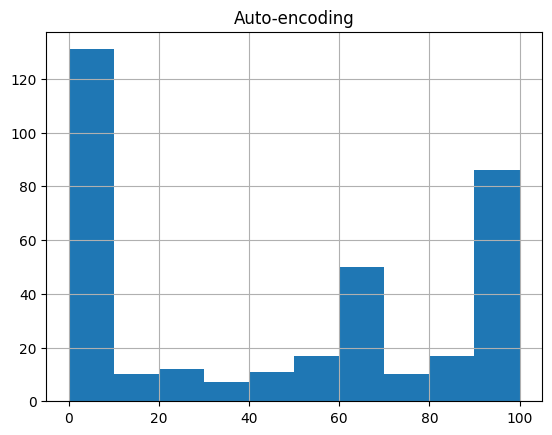

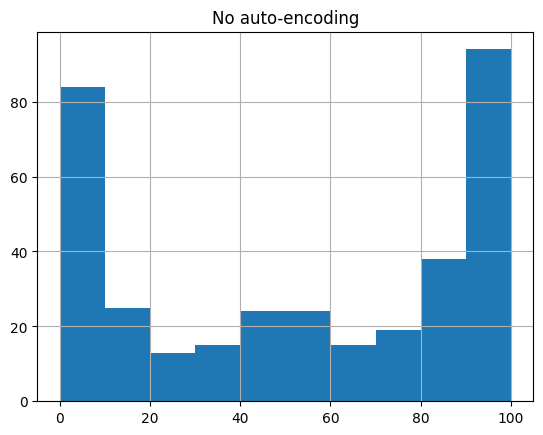

auto_encoder
coverage autoencoding: 263, (0.7492877492877493)
coverage no auto encoding: 301, (0.8575498575498576)
# rows added in subgroups: 15 (0.042735042735042736)
# rows no longer in subgroups: 53, (0.150997150997151)
average subgroup size auto encoded: 162.5
average subgroup size no auto encoding: 184.63
WRACC auto encoding: Max: 0.11220688143765066, Mean: 0.09886989553656217
WRACC no auto encoding: Max: 0.1407699612827818, Mean: 0.13164511651691138


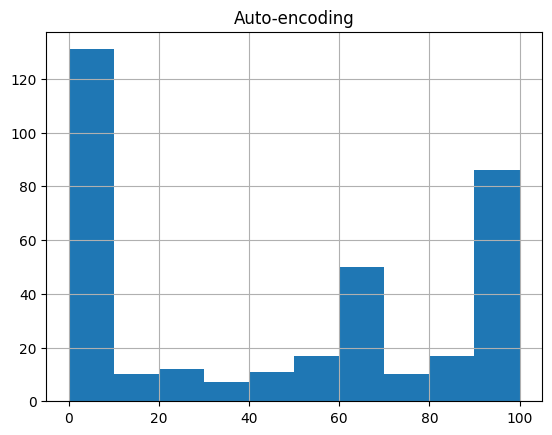

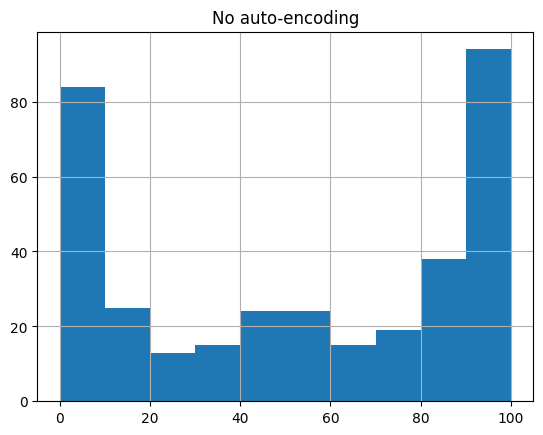

PCA
coverage autoencoding: 265, (0.7549857549857549)
coverage no auto encoding: 301, (0.8575498575498576)
# rows added in subgroups: 6 (0.017094017094017096)
# rows no longer in subgroups: 42, (0.11965811965811966)
average subgroup size auto encoded: 197.67
average subgroup size no auto encoding: 184.63
WRACC auto encoding: Max: 0.1538461538461538, Mean: 0.13817225509533196
WRACC no auto encoding: Max: 0.1407699612827818, Mean: 0.13164511651691138


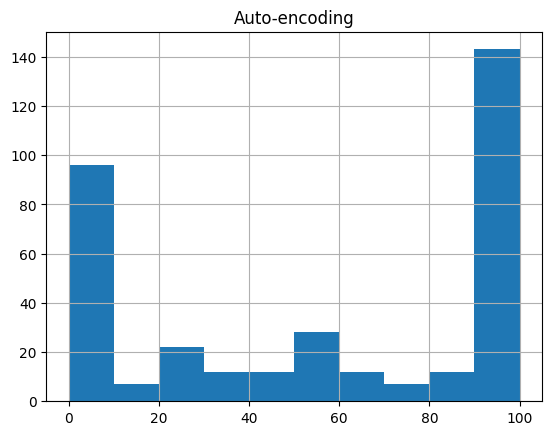

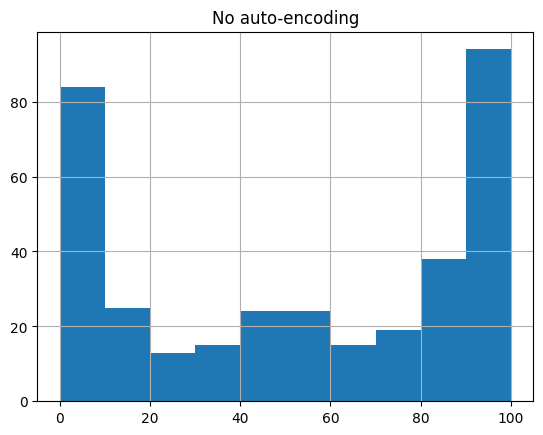

SPCA
coverage autoencoding: 270, (0.7692307692307693)
coverage no auto encoding: 301, (0.8575498575498576)
# rows added in subgroups: 12 (0.03418803418803419)
# rows no longer in subgroups: 43, (0.1225071225071225)
average subgroup size auto encoded: 187.33
average subgroup size no auto encoding: 184.63
WRACC auto encoding: Max: 0.11797793849075894, Mean: 0.10420702754036086
WRACC no auto encoding: Max: 0.1407699612827818, Mean: 0.13164511651691138


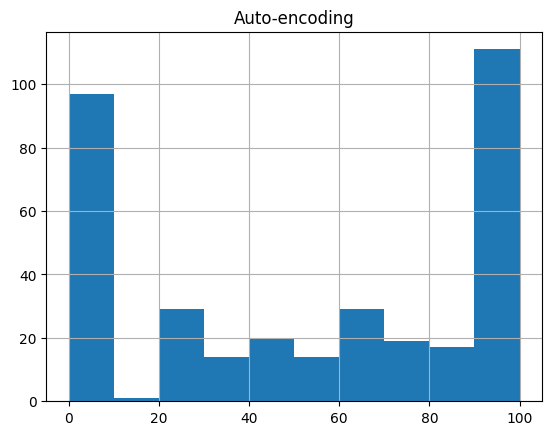

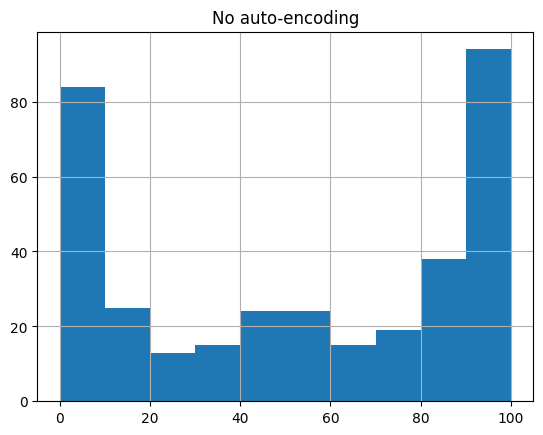

Arrhythmia :    

coverage autoencoding: 221, (0.5261904761904762)
coverage no auto encoding: 187, (0.4452380952380952)
# rows added in subgroups: 119 (0.2833333333333333)
# rows no longer in subgroups: 85, (0.20238095238095238)
average subgroup size auto encoded: 81.94
average subgroup size no auto encoding: 146.36
WRACC auto encoding: Max: 0.06547619047619048, Mean: 0.05392278911564624
WRACC no auto encoding: Max: 0.0827891156462585, Mean: 0.08085442176870748


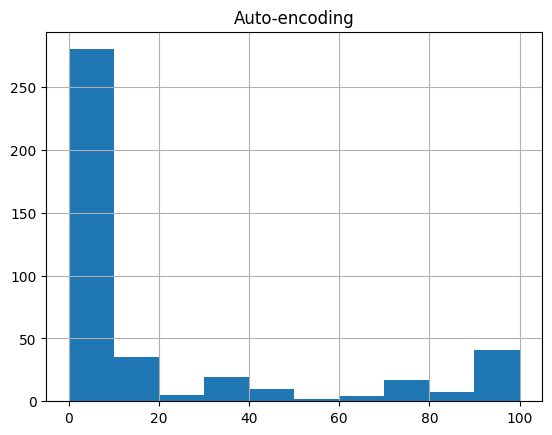

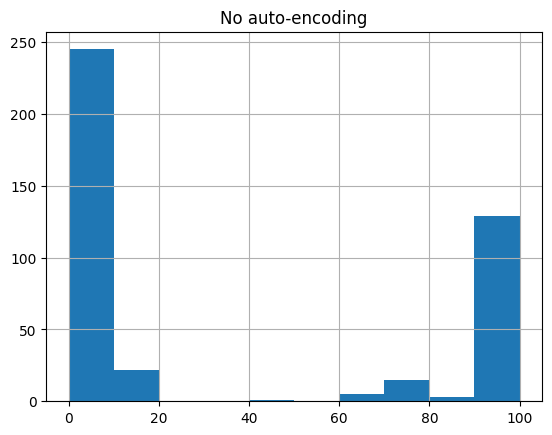

auto_encoder
coverage autoencoding: 221, (0.5261904761904762)
coverage no auto encoding: 187, (0.4452380952380952)
# rows added in subgroups: 119 (0.2833333333333333)
# rows no longer in subgroups: 85, (0.20238095238095238)
average subgroup size auto encoded: 81.94
average subgroup size no auto encoding: 146.36
WRACC auto encoding: Max: 0.06547619047619048, Mean: 0.05392278911564624
WRACC no auto encoding: Max: 0.0827891156462585, Mean: 0.08085442176870748


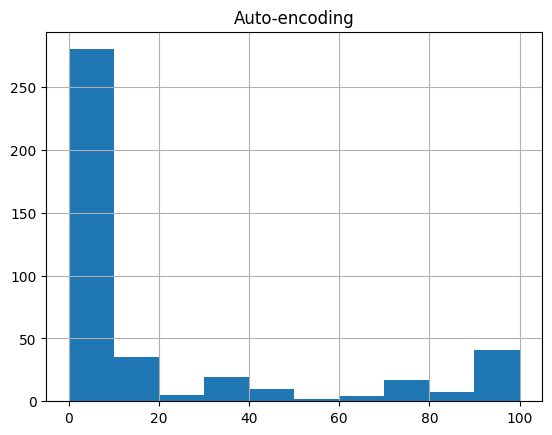

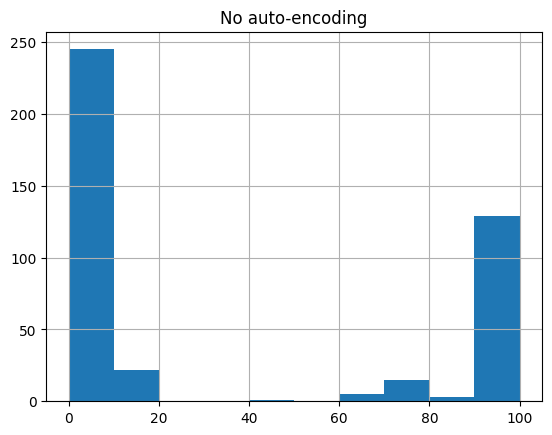

PCA
coverage autoencoding: 253, (0.6023809523809524)
coverage no auto encoding: 187, (0.4452380952380952)
# rows added in subgroups: 96 (0.22857142857142856)
# rows no longer in subgroups: 30, (0.07142857142857142)
average subgroup size auto encoded: 124.22
average subgroup size no auto encoding: 146.36
WRACC auto encoding: Max: 0.06666666666666665, Mean: 0.06179897959183672
WRACC no auto encoding: Max: 0.0827891156462585, Mean: 0.08085442176870748


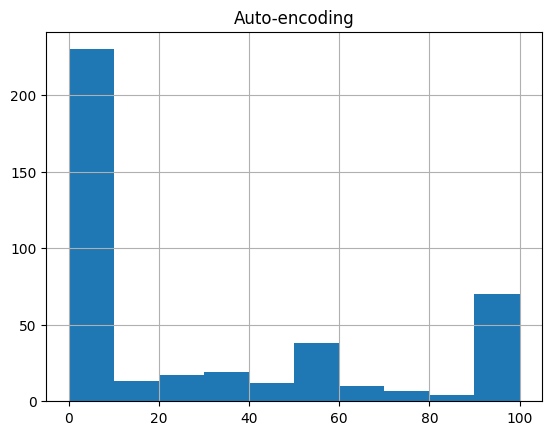

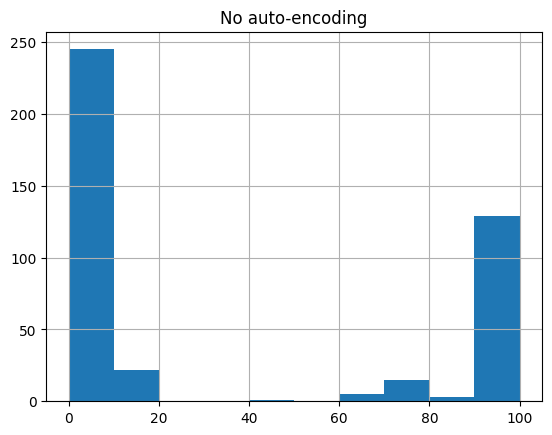

SPCA
coverage autoencoding: 210, (0.5)
coverage no auto encoding: 187, (0.4452380952380952)
# rows added in subgroups: 68 (0.1619047619047619)
# rows no longer in subgroups: 45, (0.10714285714285714)
average subgroup size auto encoded: 104.12
average subgroup size no auto encoding: 146.36
WRACC auto encoding: Max: 0.09047619047619049, Mean: 0.06629387755102042
WRACC no auto encoding: Max: 0.0827891156462585, Mean: 0.08085442176870748


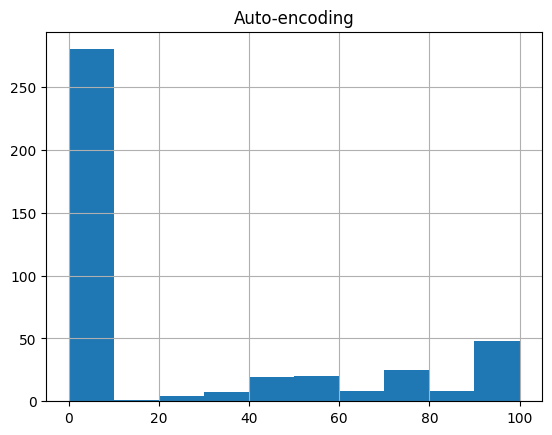

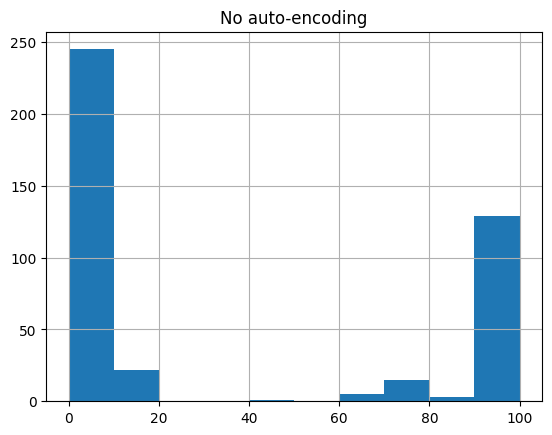

Indoor :    

coverage autoencoding: 13094, (0.6221018624097301)
coverage no auto encoding: 5553, (0.2638255416191562)
# rows added in subgroups: 7574 (0.3598441657164576)
# rows no longer in subgroups: 33, (0.0015678449258836945)
average subgroup size auto encoded: 9921.35
average subgroup size no auto encoding: 4235.05
WRACC auto encoding: Max: 0.206845412870345, Mean: 0.19404694122976912
WRACC no auto encoding: Max: 0.10803418181114251, Mean: 0.10790805699982998


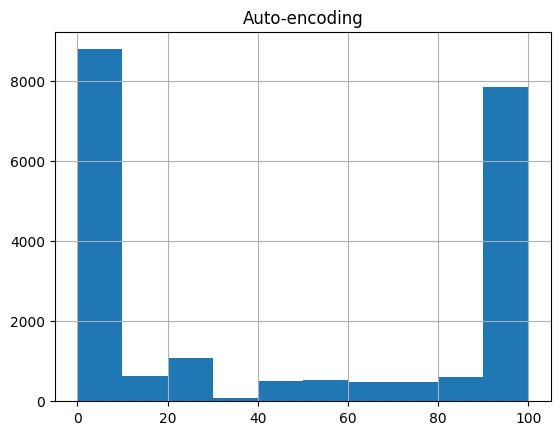

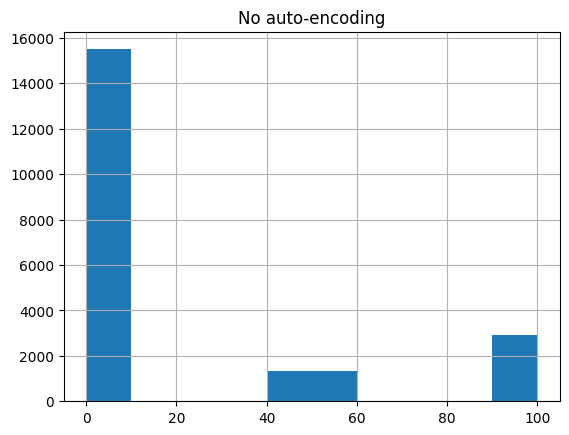

auto_encoder
coverage autoencoding: 13094, (0.6221018624097301)
coverage no auto encoding: 5553, (0.2638255416191562)
# rows added in subgroups: 7574 (0.3598441657164576)
# rows no longer in subgroups: 33, (0.0015678449258836945)
average subgroup size auto encoded: 9921.35
average subgroup size no auto encoding: 4235.05
WRACC auto encoding: Max: 0.206845412870345, Mean: 0.19404694122976912
WRACC no auto encoding: Max: 0.10803418181114251, Mean: 0.10790805699982998


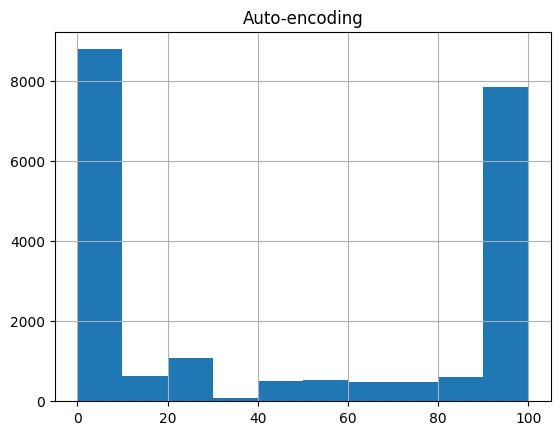

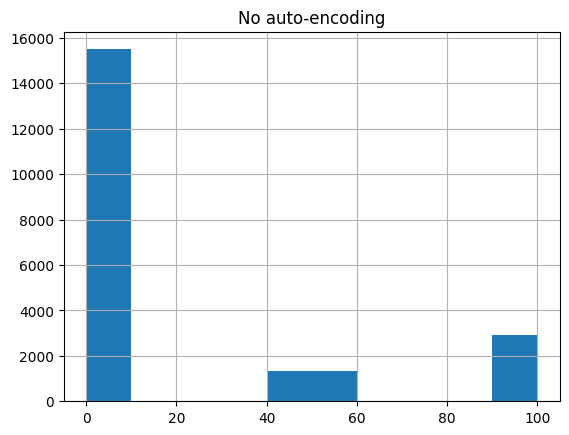

PCA
coverage autoencoding: 13176, (0.6259977194982896)
coverage no auto encoding: 5553, (0.2638255416191562)
# rows added in subgroups: 7632 (0.36259977194982895)
# rows no longer in subgroups: 9, (0.00042759407069555304)
average subgroup size auto encoded: 8953.99
average subgroup size no auto encoding: 4235.05
WRACC auto encoding: Max: 0.22244184294471048, Mean: 0.20875887493804318
WRACC no auto encoding: Max: 0.10803418181114251, Mean: 0.10790805699982998


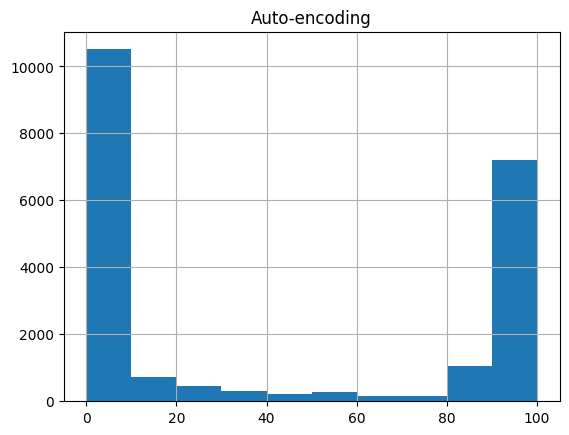

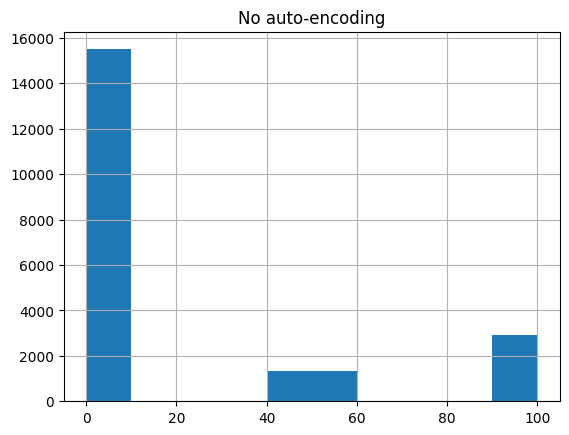

SPCA
coverage autoencoding: 14450, (0.6865260357278601)
coverage no auto encoding: 5553, (0.2638255416191562)
# rows added in subgroups: 8898 (0.4227480045610034)
# rows no longer in subgroups: 1, (4.751045229950589e-05)
average subgroup size auto encoded: 7798.87
average subgroup size no auto encoding: 4235.05
WRACC auto encoding: Max: 0.2145140982707568, Mean: 0.1799177247538738
WRACC no auto encoding: Max: 0.10803418181114251, Mean: 0.10790805699982998


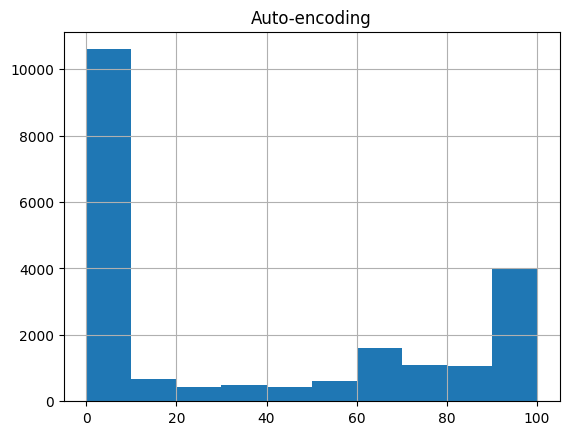

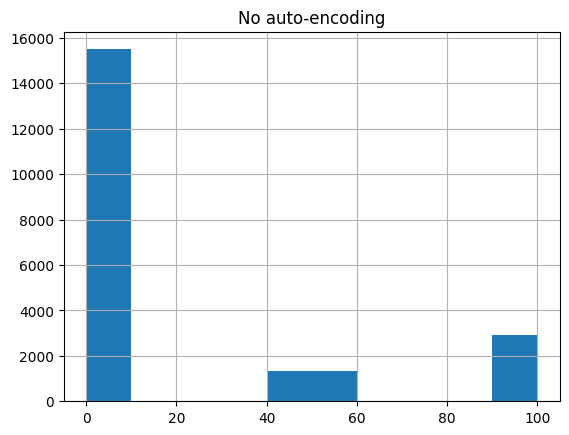

Soybean :    

coverage autoencoding: 169, (0.6353383458646616)
coverage no auto encoding: 266, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 97, (0.36466165413533835)
average subgroup size auto encoded: 119.06
average subgroup size no auto encoding: 266.0
WRACC auto encoding: Max: 0.19356662332523036, Mean: 0.1868149697552151
WRACC no auto encoding: Max: 0.0, Mean: 0.0


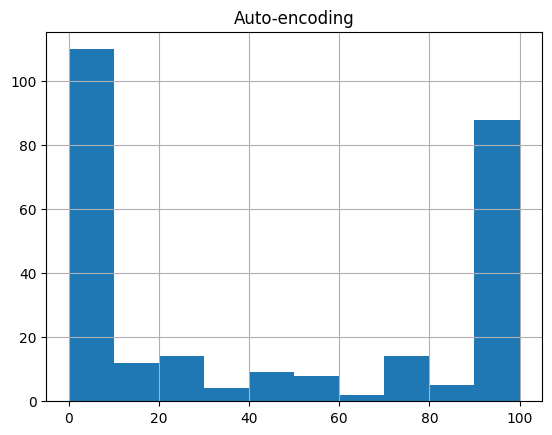

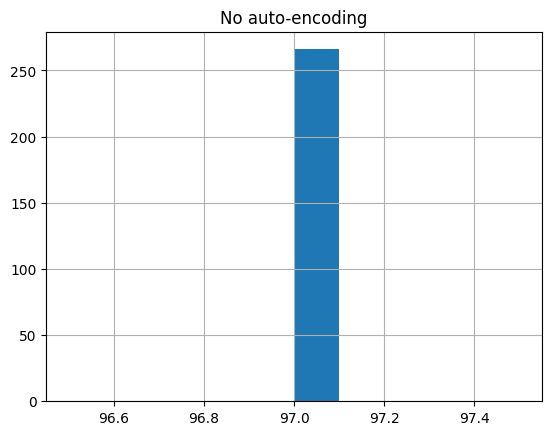

auto_encoder
coverage autoencoding: 169, (0.6353383458646616)
coverage no auto encoding: 266, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 97, (0.36466165413533835)
average subgroup size auto encoded: 119.06
average subgroup size no auto encoding: 266.0
WRACC auto encoding: Max: 0.19356662332523036, Mean: 0.1868149697552151
WRACC no auto encoding: Max: 0.0, Mean: 0.0


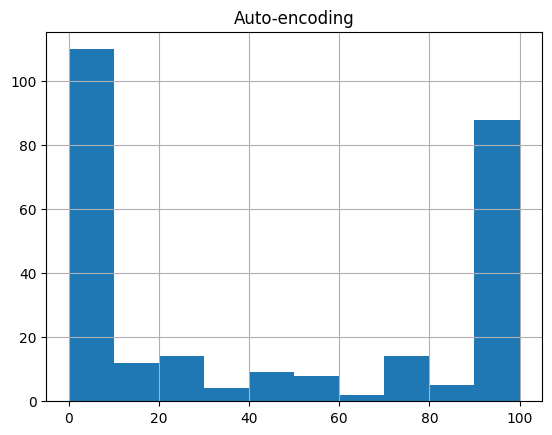

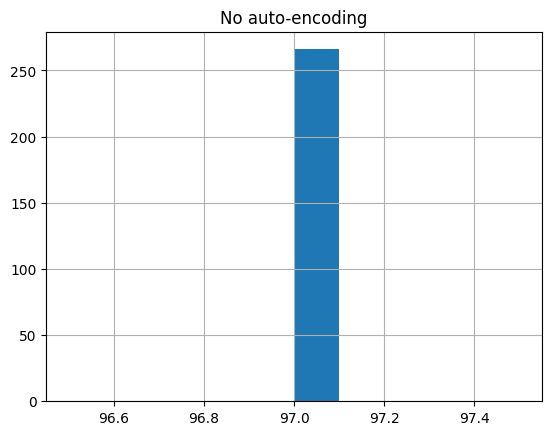

PCA
coverage autoencoding: 187, (0.7030075187969925)
coverage no auto encoding: 266, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 79, (0.29699248120300753)
average subgroup size auto encoded: 109.04
average subgroup size no auto encoding: 266.0
WRACC auto encoding: Max: 0.19622364181129515, Mean: 0.16300667081236928
WRACC no auto encoding: Max: 0.0, Mean: 0.0


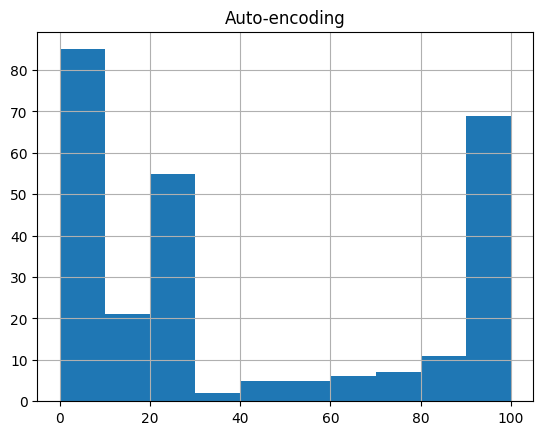

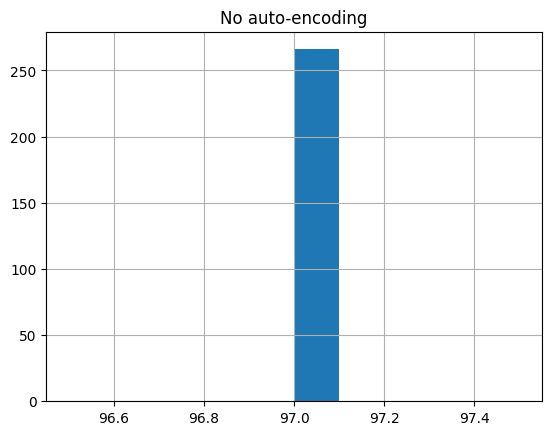

SPCA
coverage autoencoding: 152, (0.5714285714285714)
coverage no auto encoding: 266, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 114, (0.42857142857142855)
average subgroup size auto encoded: 91.01
average subgroup size no auto encoding: 266.0
WRACC auto encoding: Max: 0.20374243880377635, Mean: 0.16910311493018257
WRACC no auto encoding: Max: 0.0, Mean: 0.0


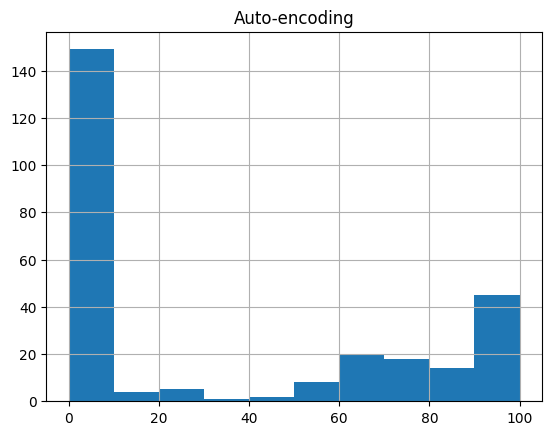

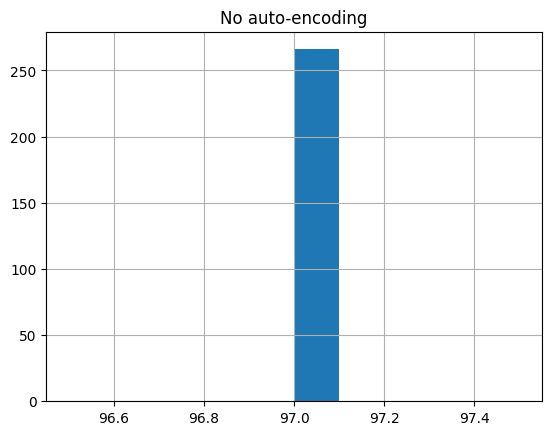

Mushroom :    

coverage autoencoding: 4429, (0.5451747907434761)
coverage no auto encoding: 4596, (0.5657311669128509)
# rows added in subgroups: 1218 (0.1499261447562777)
# rows no longer in subgroups: 1385, (0.1704825209256524)
average subgroup size auto encoded: 3241.6
average subgroup size no auto encoding: 4018.08
WRACC auto encoding: Max: 0.16271408384224723, Mean: 0.15769771399050803
WRACC no auto encoding: Max: 0.24202604582200896, Mean: 0.2260131332150777


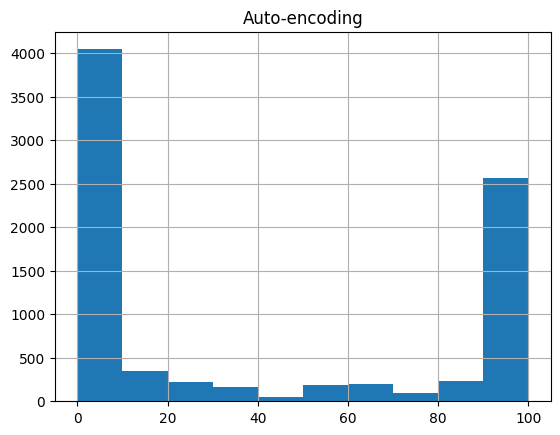

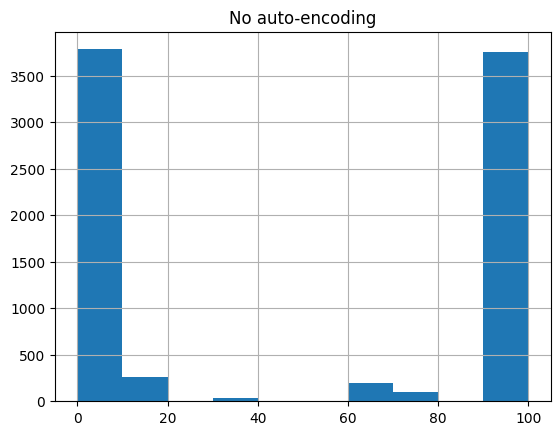

auto_encoder
coverage autoencoding: 4429, (0.5451747907434761)
coverage no auto encoding: 4596, (0.5657311669128509)
# rows added in subgroups: 1218 (0.1499261447562777)
# rows no longer in subgroups: 1385, (0.1704825209256524)
average subgroup size auto encoded: 3241.6
average subgroup size no auto encoding: 4018.08
WRACC auto encoding: Max: 0.16271408384224723, Mean: 0.15769771399050803
WRACC no auto encoding: Max: 0.24202604582200896, Mean: 0.2260131332150777


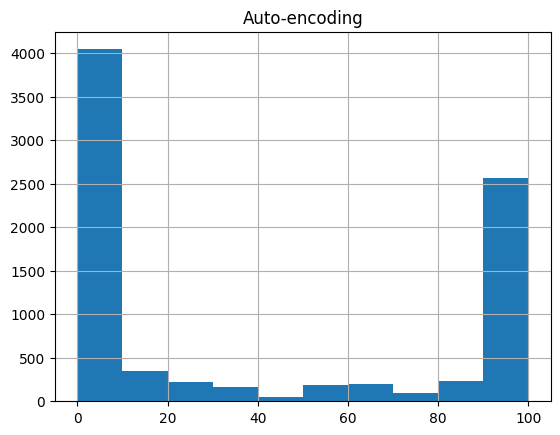

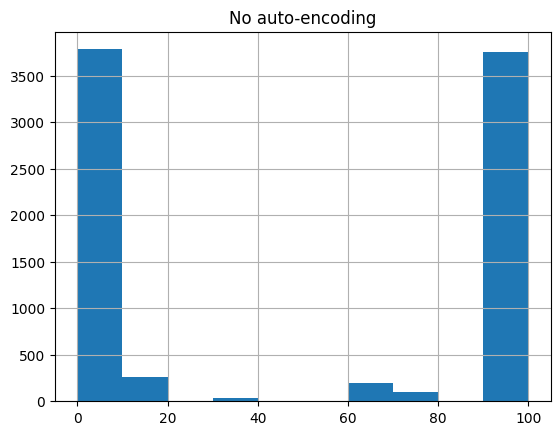

PCA
coverage autoencoding: 4835, (0.595150172328902)
coverage no auto encoding: 4596, (0.5657311669128509)
# rows added in subgroups: 891 (0.10967503692762186)
# rows no longer in subgroups: 652, (0.08025603151157065)
average subgroup size auto encoded: 3096.59
average subgroup size no auto encoding: 4018.08
WRACC auto encoding: Max: 0.19071974256241456, Mean: 0.1609681424866805
WRACC no auto encoding: Max: 0.24202604582200896, Mean: 0.2260131332150777


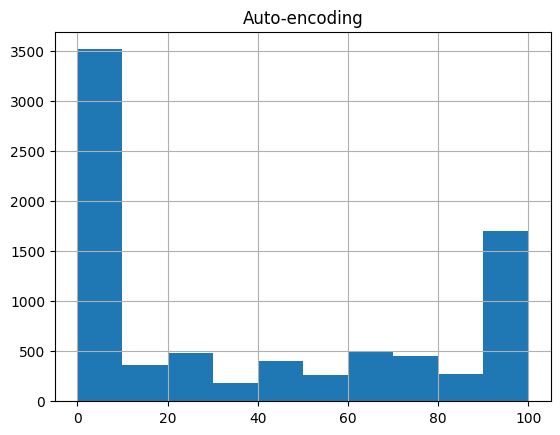

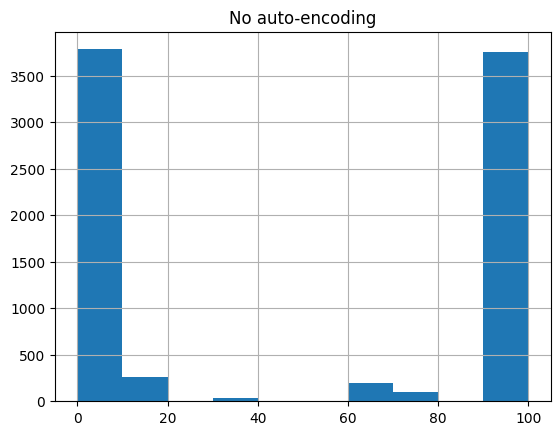

SPCA
coverage autoencoding: 4485, (0.5520679468242246)
coverage no auto encoding: 4596, (0.5657311669128509)
# rows added in subgroups: 1046 (0.12875430822255046)
# rows no longer in subgroups: 1157, (0.14241752831117677)
average subgroup size auto encoded: 2844.2
average subgroup size no auto encoding: 4018.08
WRACC auto encoding: Max: 0.19427117007894135, Mean: 0.16702786523315014
WRACC no auto encoding: Max: 0.24202604582200896, Mean: 0.2260131332150777


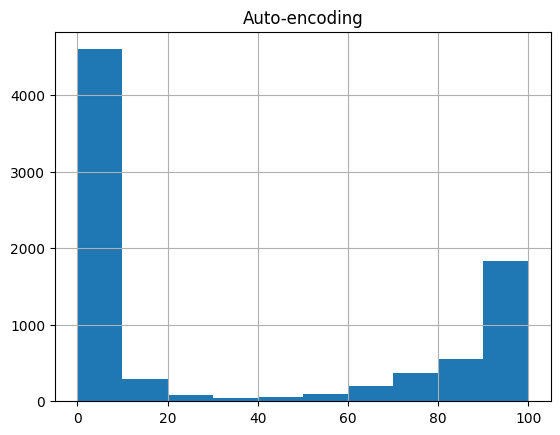

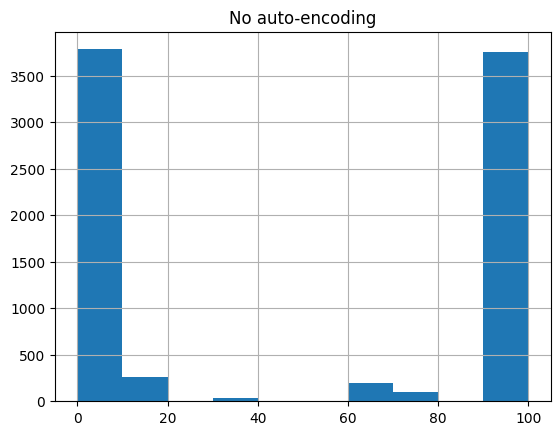

Adult :    

coverage autoencoding: 12211, (0.2500102370910282)
coverage no auto encoding: 22379, (0.45819172024077637)
# rows added in subgroups: 5659 (0.11586339625731952)
# rows no longer in subgroups: 15827, (0.32404487940706767)
average subgroup size auto encoded: 6294.58
average subgroup size no auto encoding: 20846.47
WRACC auto encoding: Max: 0.03156651180440597, Mean: 0.02705336245066467
WRACC no auto encoding: Max: 0.06637478684687972, Mean: 0.06545387406309071


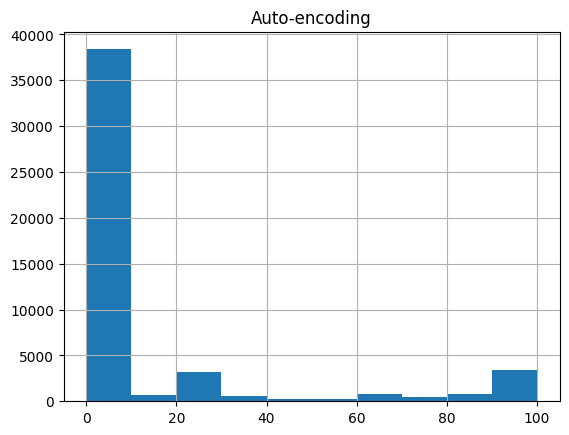

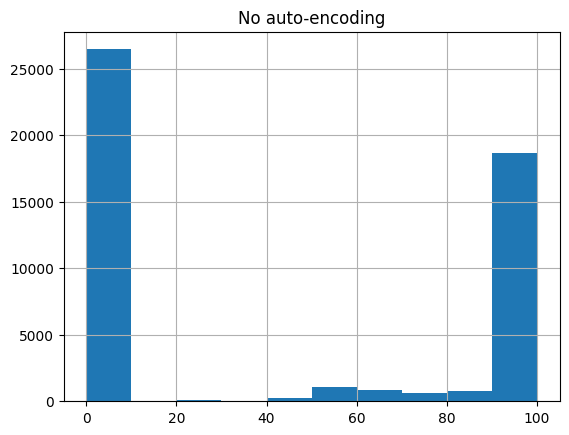

auto_encoder
coverage autoencoding: 12211, (0.2500102370910282)
coverage no auto encoding: 22379, (0.45819172024077637)
# rows added in subgroups: 5659 (0.11586339625731952)
# rows no longer in subgroups: 15827, (0.32404487940706767)
average subgroup size auto encoded: 6294.58
average subgroup size no auto encoding: 20846.47
WRACC auto encoding: Max: 0.03156651180440597, Mean: 0.02705336245066467
WRACC no auto encoding: Max: 0.06637478684687972, Mean: 0.06545387406309071


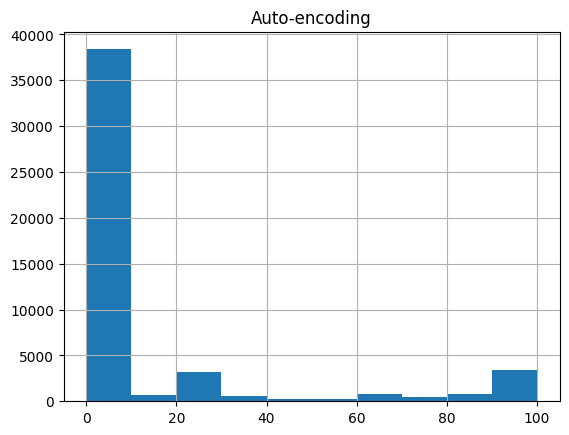

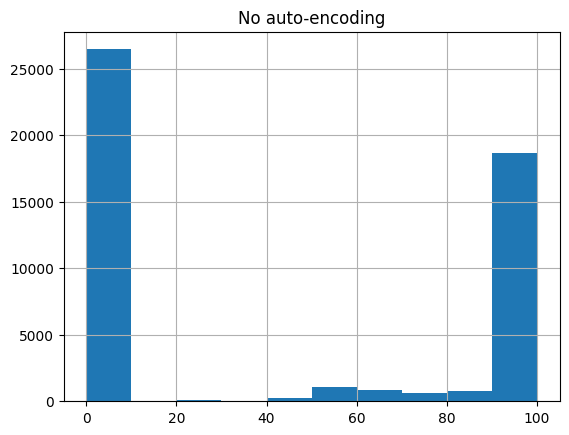

PCA
coverage autoencoding: 27604, (0.5651693214856066)
coverage no auto encoding: 22379, (0.45819172024077637)
# rows added in subgroups: 6218 (0.12730846402686213)
# rows no longer in subgroups: 993, (0.020330862782031858)
average subgroup size auto encoded: 18845.61
average subgroup size no auto encoding: 20846.47
WRACC auto encoding: Max: 0.06617780930296362, Mean: 0.06345199424125254
WRACC no auto encoding: Max: 0.06637478684687972, Mean: 0.06545387406309071


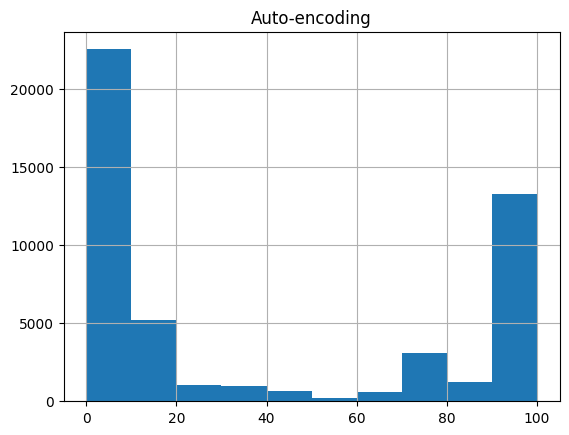

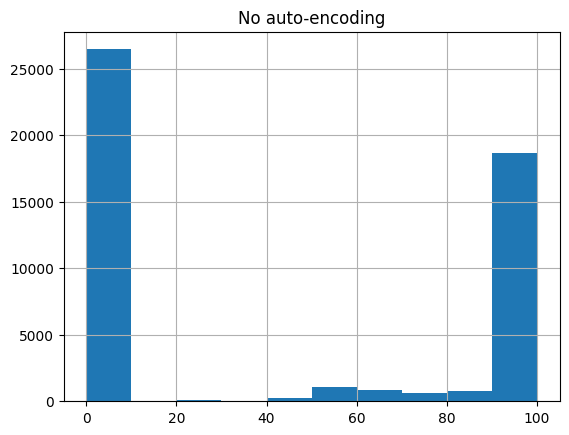

SPCA
coverage autoencoding: 25200, (0.5159493878219565)
coverage no auto encoding: 22379, (0.45819172024077637)
# rows added in subgroups: 7246 (0.14835592318086893)
# rows no longer in subgroups: 4425, (0.09059825559968879)
average subgroup size auto encoded: 18344.98
average subgroup size no auto encoding: 20846.47
WRACC auto encoding: Max: 0.06462177146667518, Mean: 0.062962050539745
WRACC no auto encoding: Max: 0.06637478684687972, Mean: 0.06545387406309071


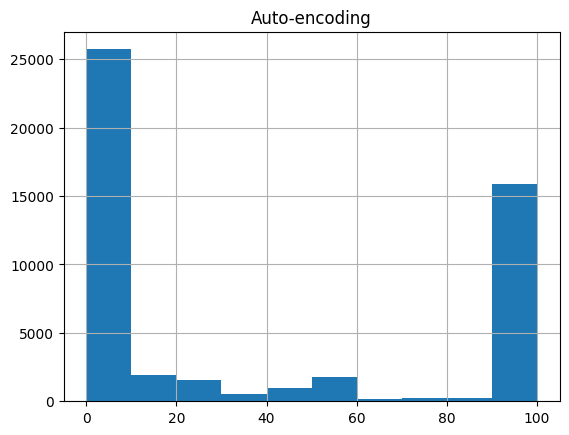

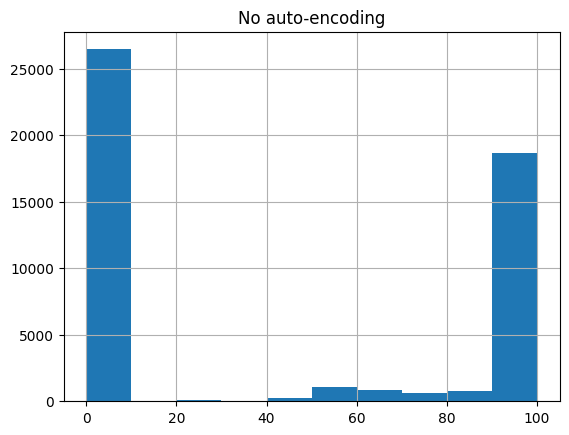

Depth-First Search :    


Ionosphere :    

coverage auto-encoding: 338, (0.9629629629629629)
coverage no auto-encoding: 333, (0.9487179487179487)
# rows added in subgroups: 14 (0.039886039886039885)
# rows no longer in subgroups: 9, (0.02564102564102564)
average subgroup size auto encoded: 26.13
average subgroup size no auto encoding: 58.82
WRACC auto-encoding: Max: 0.04594930235955876, Mean: 0.013787712762071731
WRACC no auto-encoding: Max: 0.06939878734750526, Mean: 0.04347505296223243


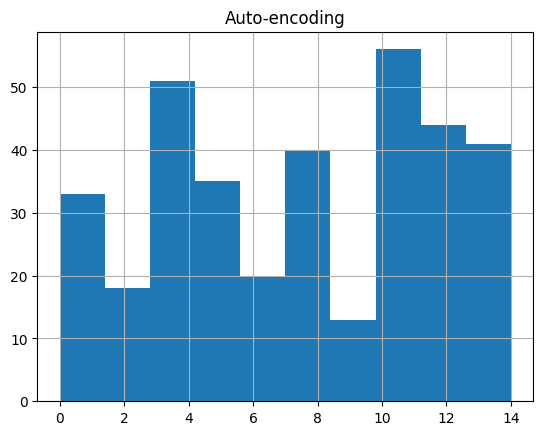

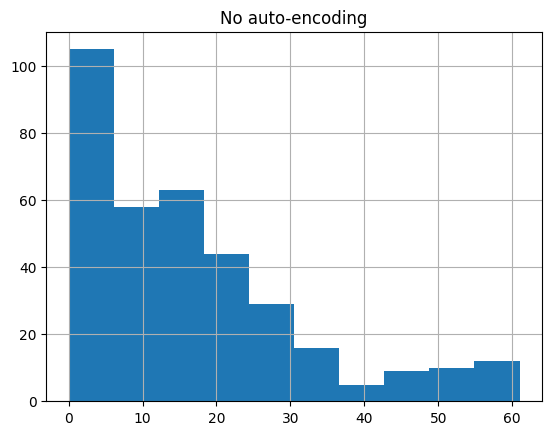

auto_encoder
coverage auto-encoding: 338, (0.9629629629629629)
coverage no auto-encoding: 333, (0.9487179487179487)
# rows added in subgroups: 14 (0.039886039886039885)
# rows no longer in subgroups: 9, (0.02564102564102564)
average subgroup size auto encoded: 26.13
average subgroup size no auto encoding: 58.82
WRACC auto-encoding: Max: 0.04594930235955876, Mean: 0.013787712762071731
WRACC no auto-encoding: Max: 0.06939878734750526, Mean: 0.04347505296223243


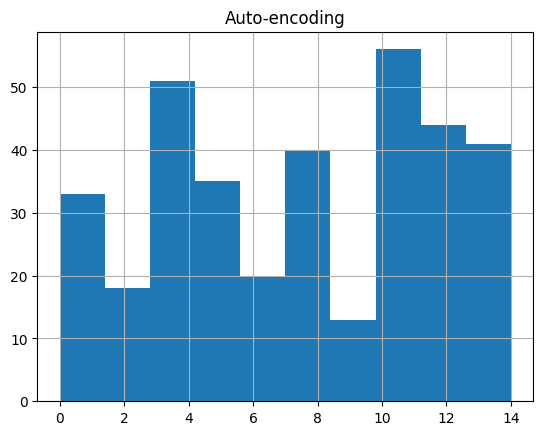

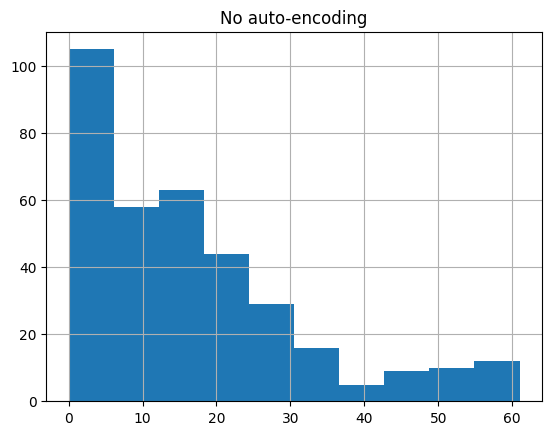

PCA
coverage auto-encoding: 339, (0.9658119658119658)
coverage no auto-encoding: 333, (0.9487179487179487)
# rows added in subgroups: 13 (0.037037037037037035)
# rows no longer in subgroups: 7, (0.019943019943019943)
average subgroup size auto encoded: 24.13
average subgroup size no auto encoding: 58.82
WRACC auto-encoding: Max: 0.060194316604573, Mean: 0.014592738695302795
WRACC no auto-encoding: Max: 0.06939878734750526, Mean: 0.04347505296223243


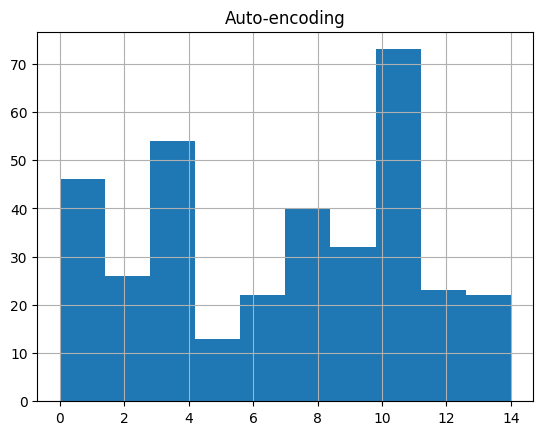

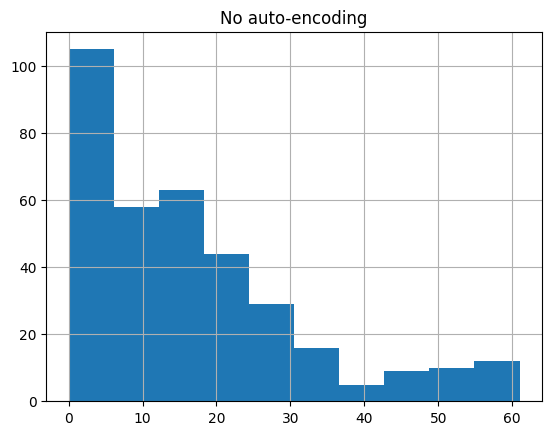

SPCA
coverage auto-encoding: 344, (0.98005698005698)
coverage no auto-encoding: 333, (0.9487179487179487)
# rows added in subgroups: 17 (0.04843304843304843)
# rows no longer in subgroups: 6, (0.017094017094017096)
average subgroup size auto encoded: 24.75
average subgroup size no auto encoding: 58.82
WRACC auto-encoding: Max: 0.05836803272700707, Mean: 0.013204032434801657
WRACC no auto-encoding: Max: 0.06939878734750526, Mean: 0.04347505296223243


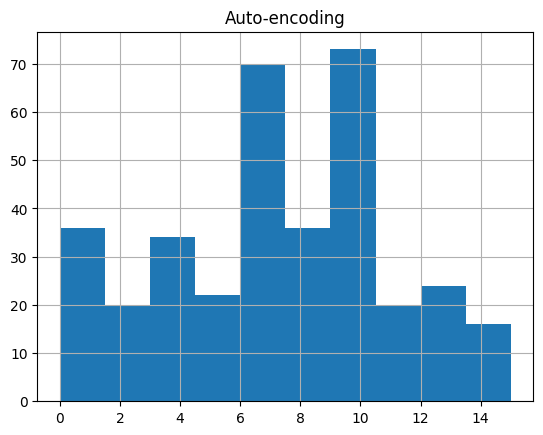

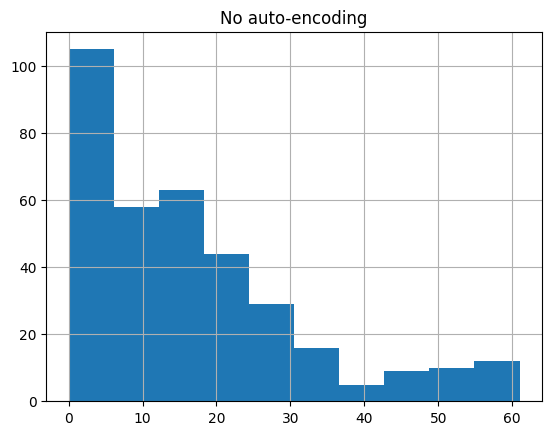

Arrhythmia :    

coverage auto-encoding: 395, (0.9404761904761905)
coverage no auto-encoding: 296, (0.7047619047619048)
# rows added in subgroups: 108 (0.2571428571428571)
# rows no longer in subgroups: 9, (0.02142857142857143)
average subgroup size auto encoded: 22.6
average subgroup size no auto encoding: 97.57
WRACC auto-encoding: Max: 0.06047619047619049, Mean: 0.009497619047619046
WRACC no auto-encoding: Max: 0.06554421768707483, Mean: 0.05814812925170067


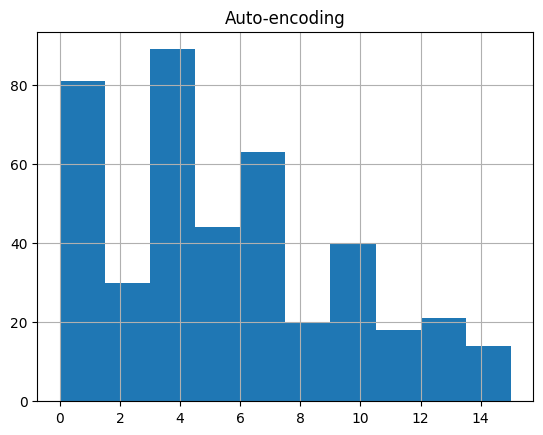

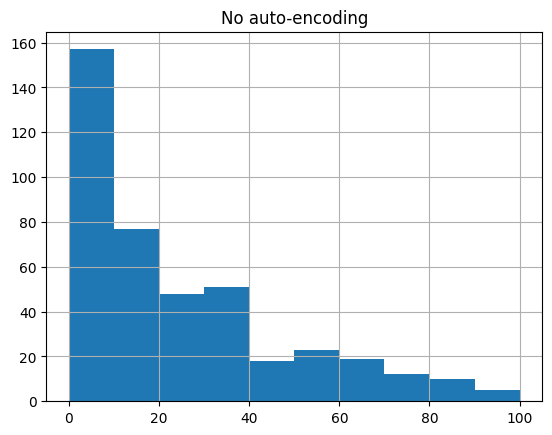

auto_encoder
coverage auto-encoding: 395, (0.9404761904761905)
coverage no auto-encoding: 296, (0.7047619047619048)
# rows added in subgroups: 108 (0.2571428571428571)
# rows no longer in subgroups: 9, (0.02142857142857143)
average subgroup size auto encoded: 22.6
average subgroup size no auto encoding: 97.57
WRACC auto-encoding: Max: 0.06047619047619049, Mean: 0.009497619047619046
WRACC no auto-encoding: Max: 0.06554421768707483, Mean: 0.05814812925170067


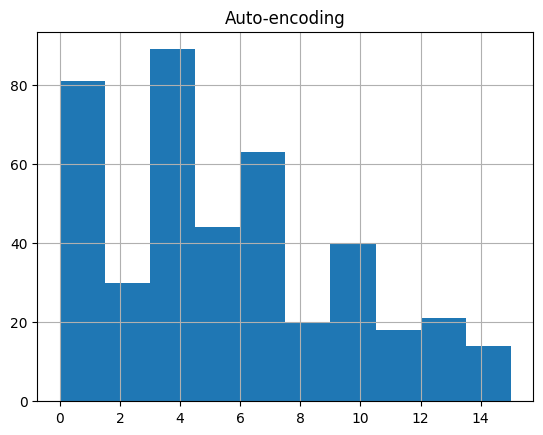

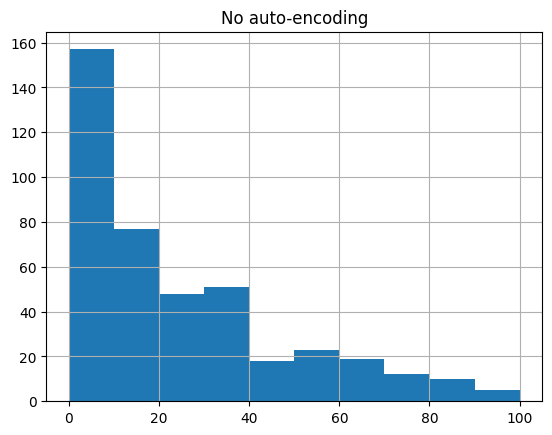

PCA
coverage auto-encoding: 404, (0.9619047619047619)
coverage no auto-encoding: 296, (0.7047619047619048)
# rows added in subgroups: 110 (0.2619047619047619)
# rows no longer in subgroups: 2, (0.004761904761904762)
average subgroup size auto encoded: 21.45
average subgroup size no auto encoding: 97.57
WRACC auto-encoding: Max: 0.06047619047619049, Mean: 0.006009353741496598
WRACC no auto-encoding: Max: 0.06554421768707483, Mean: 0.05814812925170067


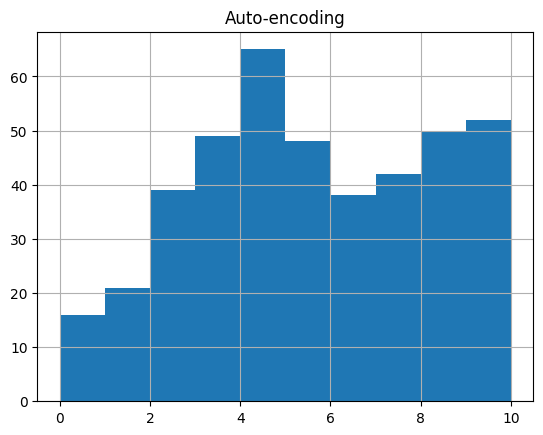

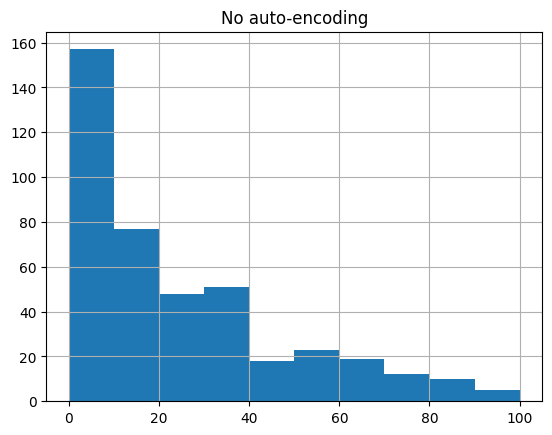

SPCA
coverage auto-encoding: 415, (0.9880952380952381)
coverage no auto-encoding: 296, (0.7047619047619048)
# rows added in subgroups: 120 (0.2857142857142857)
# rows no longer in subgroups: 1, (0.002380952380952381)
average subgroup size auto encoded: 24.0
average subgroup size no auto encoding: 97.57
WRACC auto-encoding: Max: 0.06761904761904762, Mean: 0.005257653061224488
WRACC no auto-encoding: Max: 0.06554421768707483, Mean: 0.05814812925170067


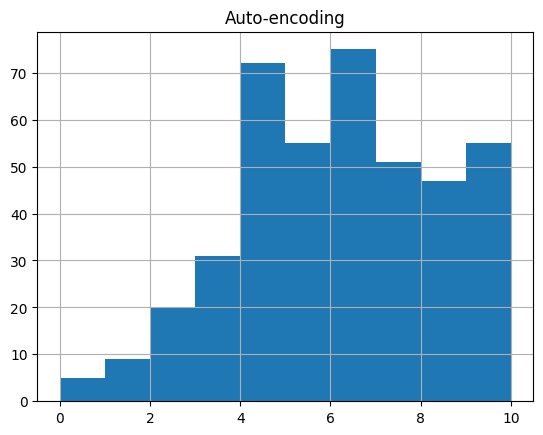

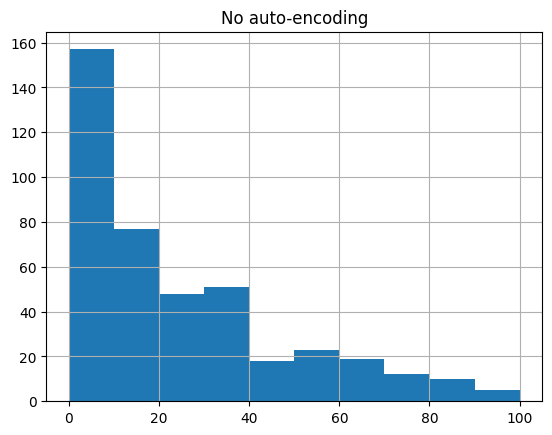

Indoor :    

coverage auto-encoding: 19418, (0.9225579627518053)
coverage no auto-encoding: 8417, (0.3998954770049411)
# rows added in subgroups: 11001 (0.5226624857468644)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 1164.57
average subgroup size no auto encoding: 4176.44
WRACC auto-encoding: Max: 0.08101853958612057, Mean: 0.013708722066707202
WRACC no auto-encoding: Max: 0.10696403189697552, Mean: 0.10639425877988103


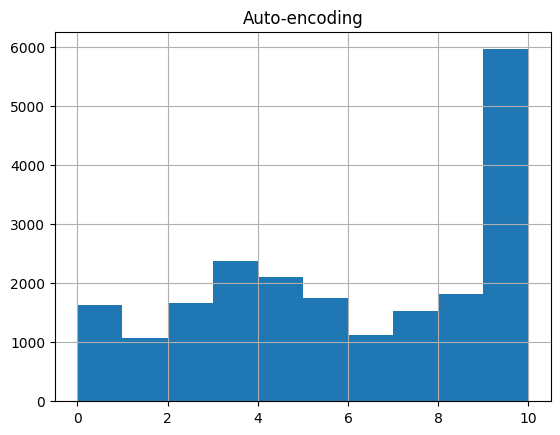

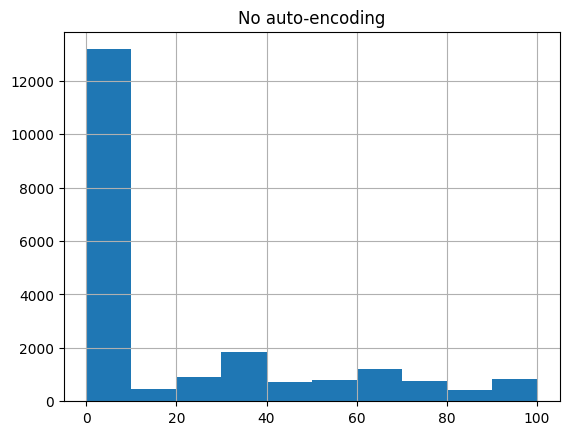

auto_encoder
coverage auto-encoding: 19418, (0.9225579627518053)
coverage no auto-encoding: 8417, (0.3998954770049411)
# rows added in subgroups: 11001 (0.5226624857468644)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 1164.57
average subgroup size no auto encoding: 4176.44
WRACC auto-encoding: Max: 0.08101853958612057, Mean: 0.013708722066707202
WRACC no auto-encoding: Max: 0.10696403189697552, Mean: 0.10639425877988103


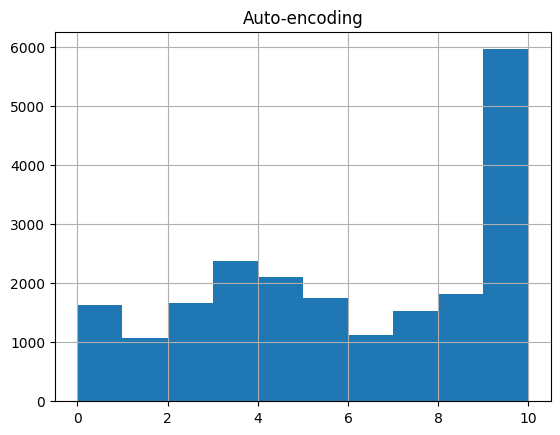

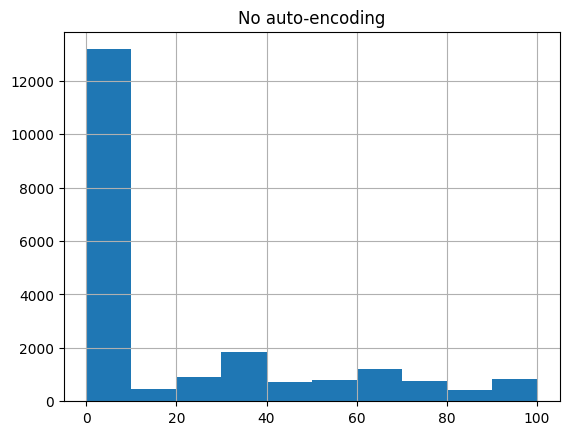

PCA
coverage auto-encoding: 15845, (0.7528031166856708)
coverage no auto-encoding: 8417, (0.3998954770049411)
# rows added in subgroups: 7428 (0.35290763968072975)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 1115.16
average subgroup size no auto encoding: 4176.44
WRACC auto-encoding: Max: 0.10726978901530895, Mean: 0.020435474918887326
WRACC no auto-encoding: Max: 0.10696403189697552, Mean: 0.10639425877988103


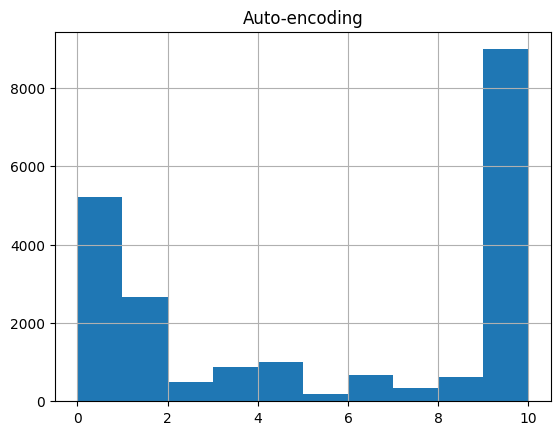

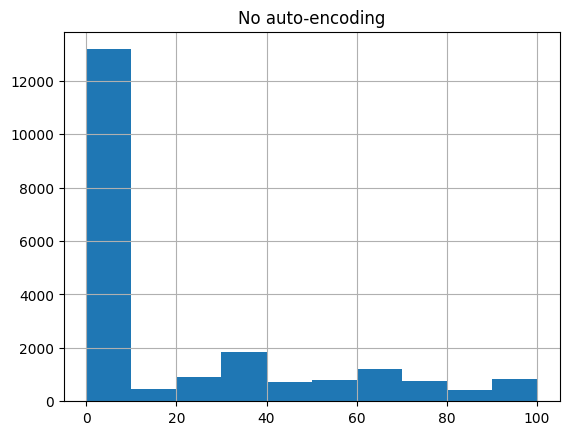

SPCA
coverage auto-encoding: 18146, (0.8621246674268339)
coverage no auto-encoding: 8417, (0.3998954770049411)
# rows added in subgroups: 9739 (0.46270429494488785)
# rows no longer in subgroups: 10, (0.0004751045229950589)
average subgroup size auto encoded: 1104.0
average subgroup size no auto encoding: 4176.44
WRACC auto-encoding: Max: 0.10724430925544784, Mean: 0.01743383460742967
WRACC no auto-encoding: Max: 0.10696403189697552, Mean: 0.10639425877988103


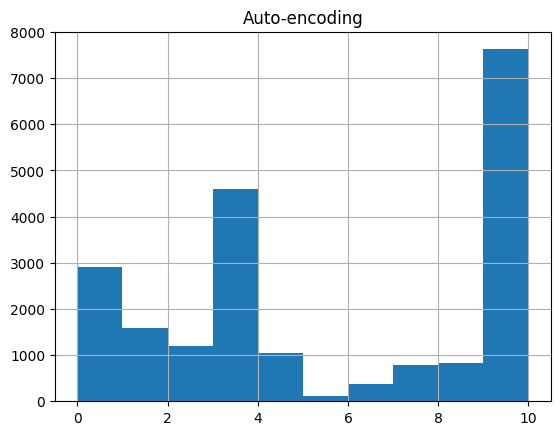

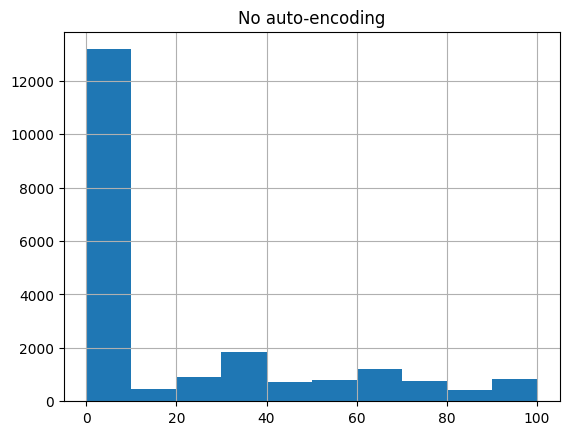

Soybean :    

coverage auto-encoding: 253, (0.9511278195488722)
coverage no auto-encoding: 251, (0.943609022556391)
# rows added in subgroups: 10 (0.03759398496240601)
# rows no longer in subgroups: 8, (0.03007518796992481)
average subgroup size auto encoded: 17.56
average subgroup size no auto encoding: 134.99
WRACC auto-encoding: Max: 0.10379331788116908, Mean: 0.018696082311040762
WRACC no auto-encoding: Max: 0.24068630222171972, Mean: 0.16175730680083666


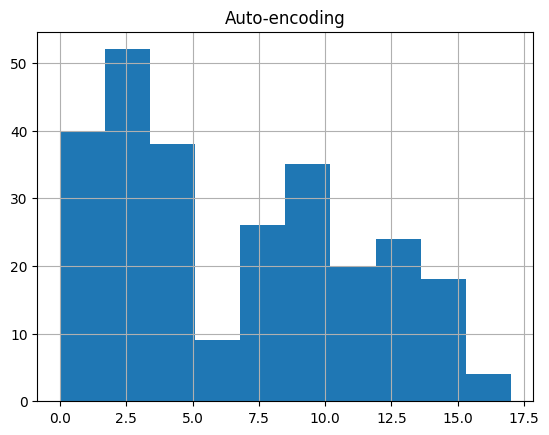

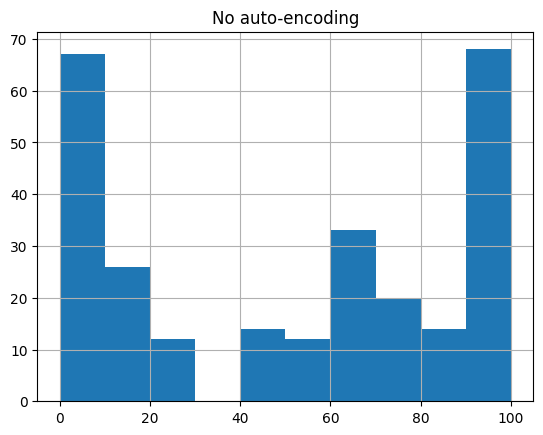

auto_encoder
coverage auto-encoding: 253, (0.9511278195488722)
coverage no auto-encoding: 251, (0.943609022556391)
# rows added in subgroups: 10 (0.03759398496240601)
# rows no longer in subgroups: 8, (0.03007518796992481)
average subgroup size auto encoded: 17.56
average subgroup size no auto encoding: 134.99
WRACC auto-encoding: Max: 0.10379331788116908, Mean: 0.018696082311040762
WRACC no auto-encoding: Max: 0.24068630222171972, Mean: 0.16175730680083666


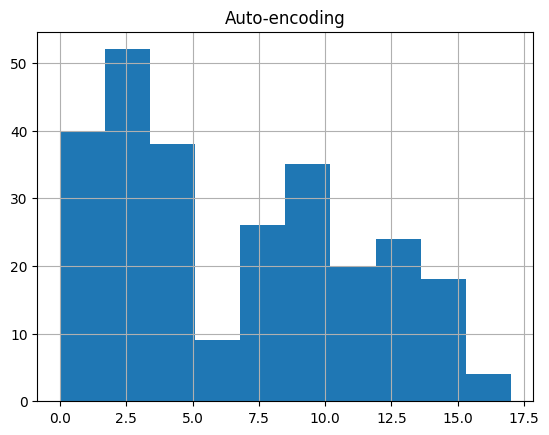

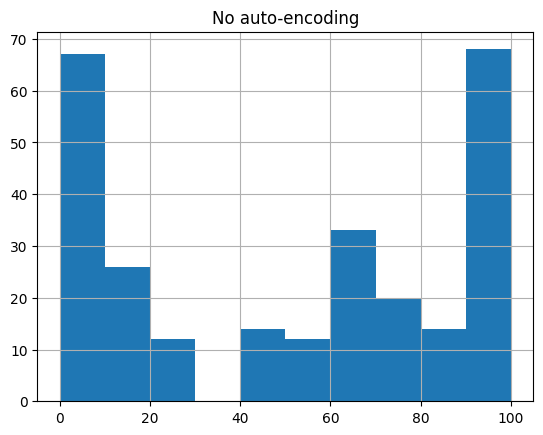

PCA
coverage auto-encoding: 264, (0.9924812030075187)
coverage no auto-encoding: 251, (0.943609022556391)
# rows added in subgroups: 13 (0.04887218045112782)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 16.92
average subgroup size no auto encoding: 134.99
WRACC auto-encoding: Max: 0.06427723443948218, Mean: 0.011997286449205724
WRACC no auto-encoding: Max: 0.24068630222171972, Mean: 0.16175730680083666


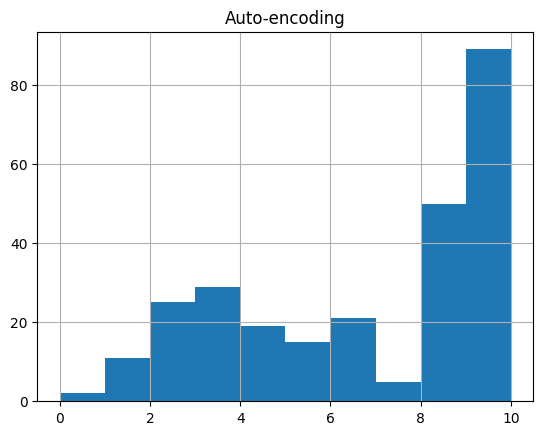

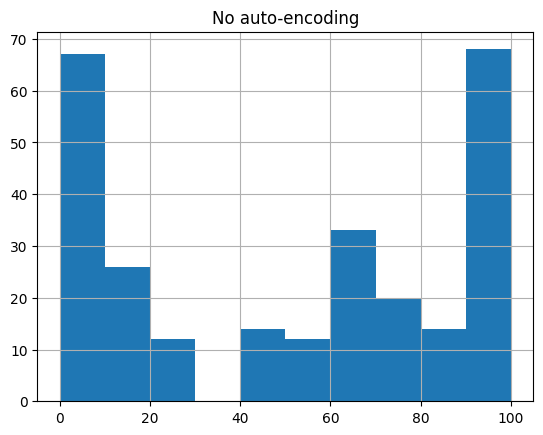

SPCA
coverage auto-encoding: 266, (1.0)
coverage no auto-encoding: 251, (0.943609022556391)
# rows added in subgroups: 15 (0.05639097744360902)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 15.88
average subgroup size no auto encoding: 134.99
WRACC auto-encoding: Max: 0.09811182090564757, Mean: 0.010088473062355137
WRACC no auto-encoding: Max: 0.24068630222171972, Mean: 0.16175730680083666


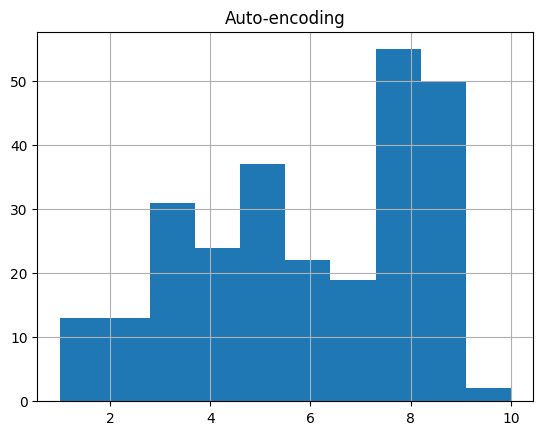

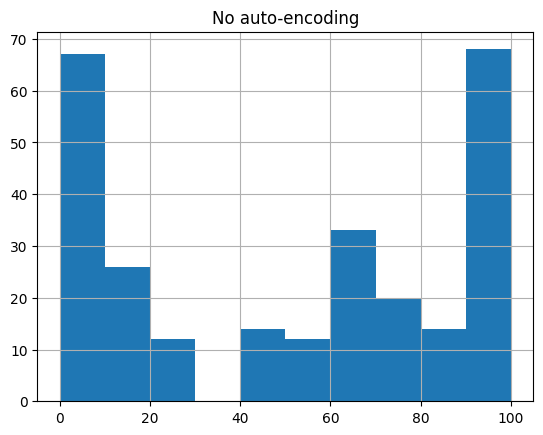

Mushroom :    

coverage auto-encoding: 7751, (0.9540866568193008)
coverage no auto-encoding: 8124, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 373, (0.045913343180699166)
average subgroup size auto encoded: 486.9
average subgroup size no auto encoding: 2105.28
WRACC auto-encoding: Max: 0.07677296827776069, Mean: 0.015498338044893029
WRACC no auto-encoding: Max: 0.1823755424596742, Mean: 0.09028494814860072


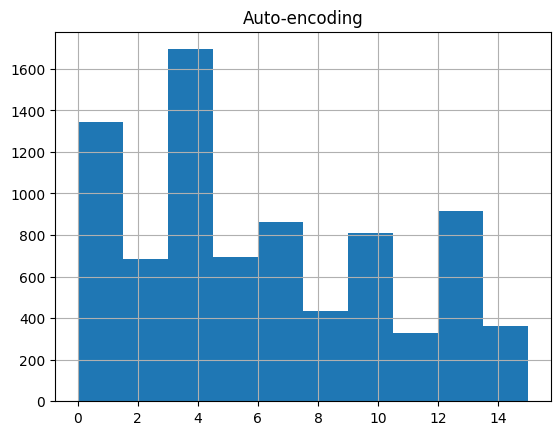

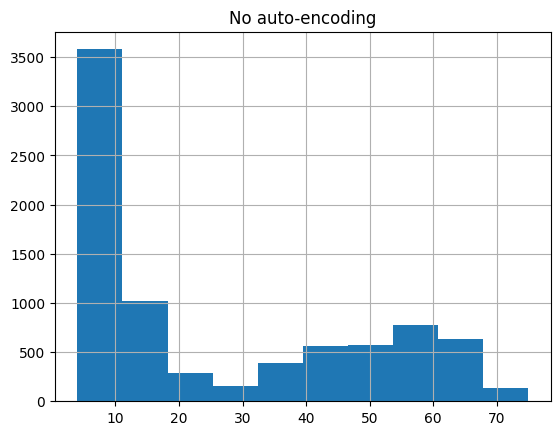

auto_encoder
coverage auto-encoding: 7751, (0.9540866568193008)
coverage no auto-encoding: 8124, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 373, (0.045913343180699166)
average subgroup size auto encoded: 486.9
average subgroup size no auto encoding: 2105.28
WRACC auto-encoding: Max: 0.07677296827776069, Mean: 0.015498338044893029
WRACC no auto-encoding: Max: 0.1823755424596742, Mean: 0.09028494814860072


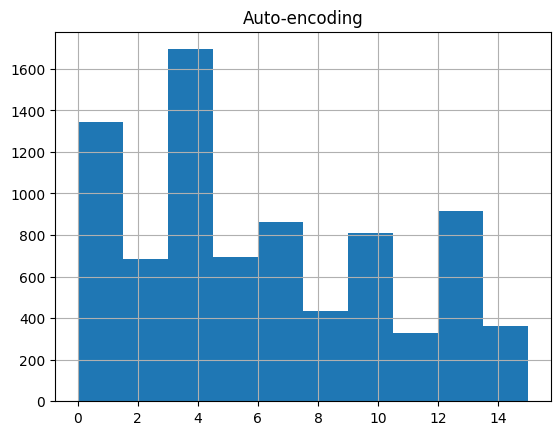

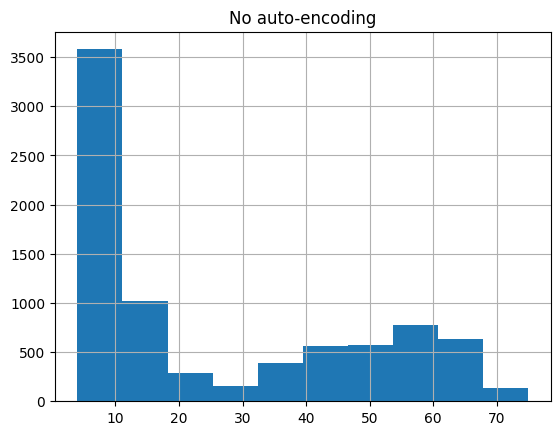

PCA
coverage auto-encoding: 7153, (0.8804775972427376)
coverage no auto-encoding: 8124, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 971, (0.11952240275726243)
average subgroup size auto encoded: 759.22
average subgroup size no auto encoding: 2105.28
WRACC auto-encoding: Max: 0.10354328198496907, Mean: 0.04005249867816932
WRACC no auto-encoding: Max: 0.1823755424596742, Mean: 0.09028494814860072


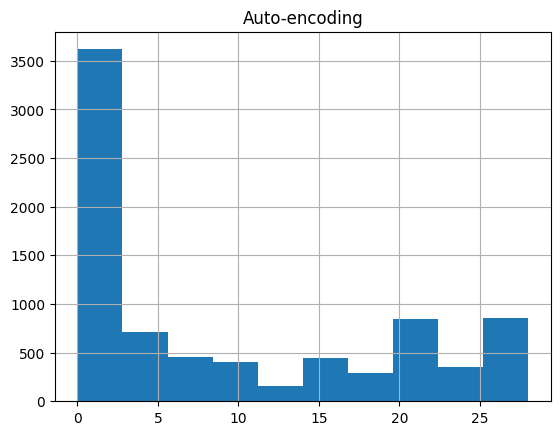

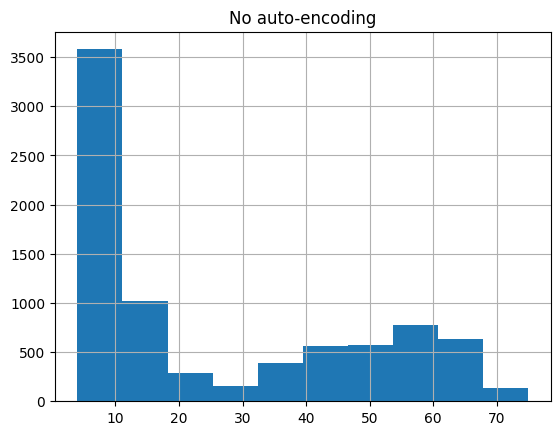

SPCA
coverage auto-encoding: 7150, (0.8801083210241261)
coverage no auto-encoding: 8124, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 974, (0.11989167897587395)
average subgroup size auto encoded: 622.89
average subgroup size no auto encoding: 2105.28
WRACC auto-encoding: Max: 0.10354328198496907, Mean: 0.03152908172949999
WRACC no auto-encoding: Max: 0.1823755424596742, Mean: 0.09028494814860072


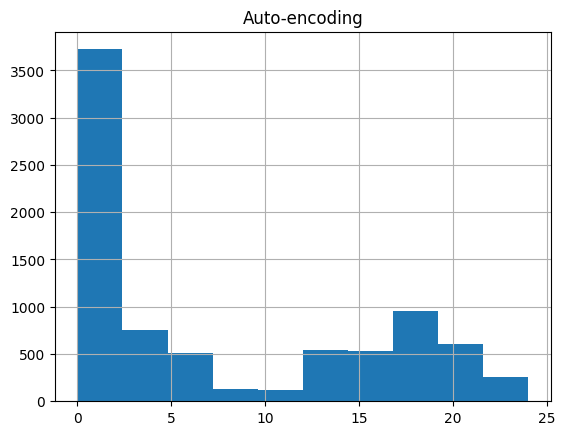

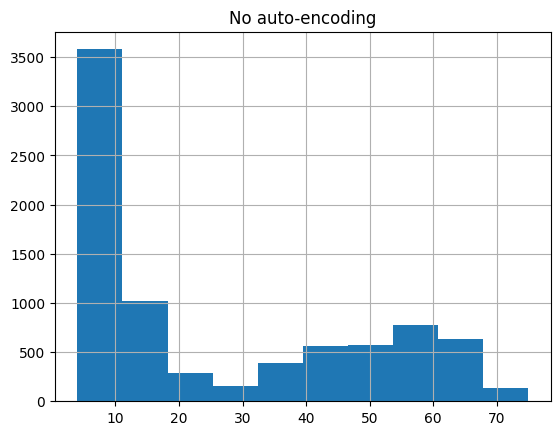

Adult :    

coverage auto-encoding: 48842, (1.0)
coverage no auto-encoding: 41678, (0.8533229597477581)
# rows added in subgroups: 7164 (0.14667704025224193)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 4308.985294117647
average subgroup size no auto encoding: 9164.5
WRACC auto-encoding: Max: 0.027494046419569255, Mean: 2.5618372265606845e-06
WRACC no auto-encoding: Max: 0.06345601575676821, Mean: 0.024945288728229945


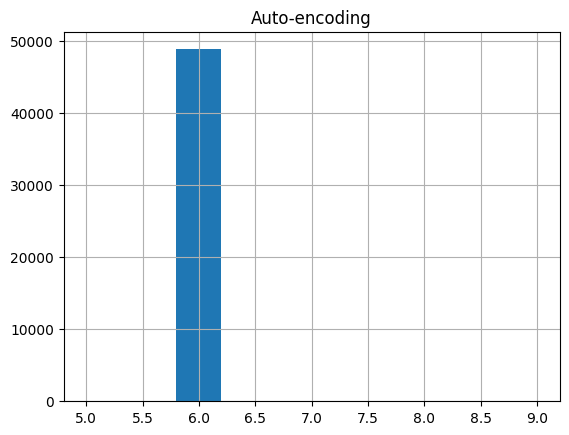

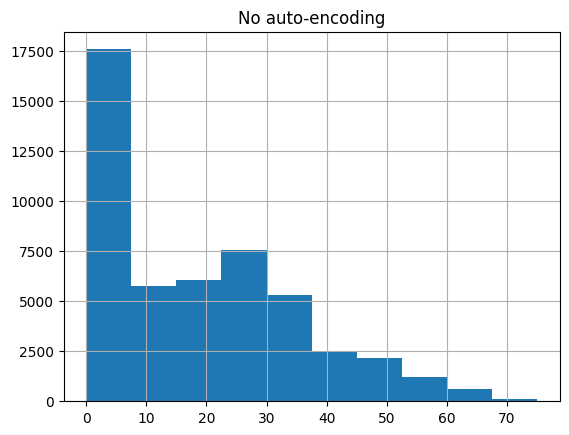

auto_encoder
coverage auto-encoding: 48842, (1.0)
coverage no auto-encoding: 41678, (0.8533229597477581)
# rows added in subgroups: 7164 (0.14667704025224193)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 4308.985294117647
average subgroup size no auto encoding: 9164.5
WRACC auto-encoding: Max: 0.027494046419569255, Mean: 2.5618372265606845e-06
WRACC no auto-encoding: Max: 0.06345601575676821, Mean: 0.024945288728229945


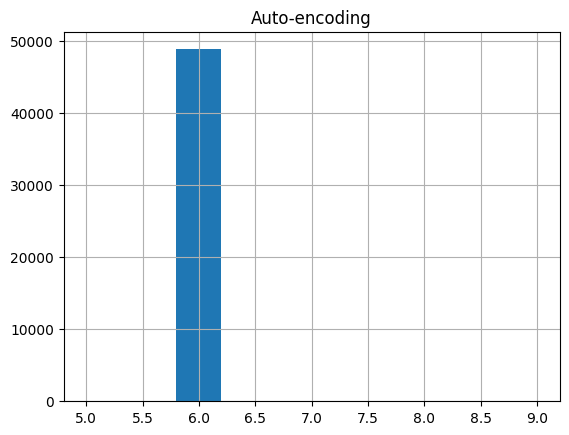

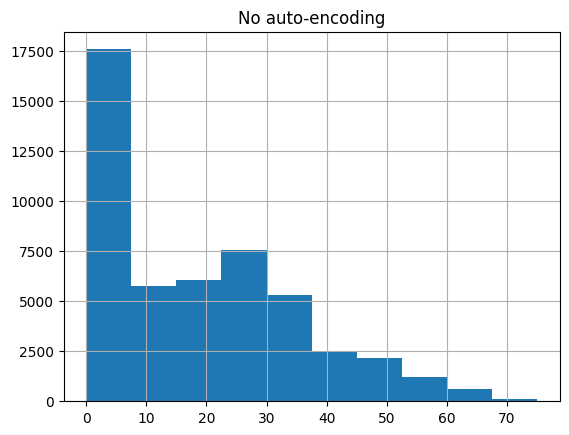

PCA
coverage auto-encoding: 45107, (0.9235289300192457)
coverage no auto-encoding: 41678, (0.8533229597477581)
# rows added in subgroups: 6296 (0.1289054502272634)
# rows no longer in subgroups: 2867, (0.05869947995577577)
average subgroup size auto encoded: 3183.91
average subgroup size no auto encoding: 9164.5
WRACC auto-encoding: Max: 0.048272054321344286, Mean: 0.006735355050478187
WRACC no auto-encoding: Max: 0.06345601575676821, Mean: 0.024945288728229945


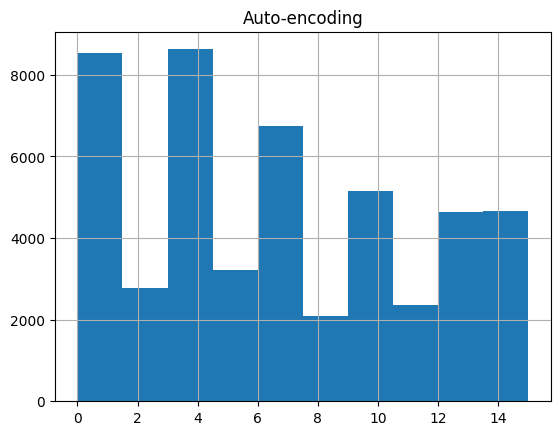

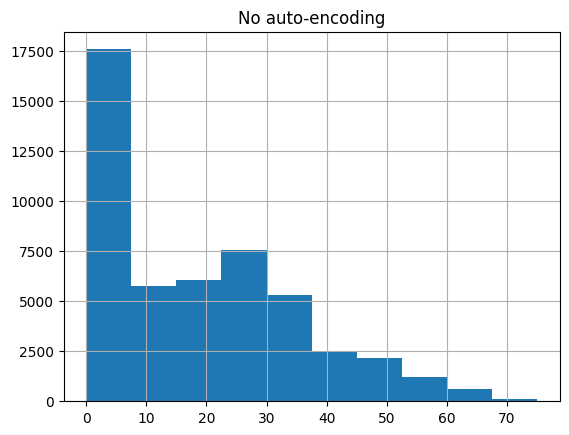

SPCA
coverage auto-encoding: 44482, (0.9107325662339789)
coverage no auto-encoding: 41678, (0.8533229597477581)
# rows added in subgroups: 5318 (0.10888170017607797)
# rows no longer in subgroups: 2514, (0.05147209368985709)
average subgroup size auto encoded: 2975.67
average subgroup size no auto encoding: 9164.5
WRACC auto-encoding: Max: 0.036847460733858105, Mean: 0.0069393533248083865
WRACC no auto-encoding: Max: 0.06345601575676821, Mean: 0.024945288728229945


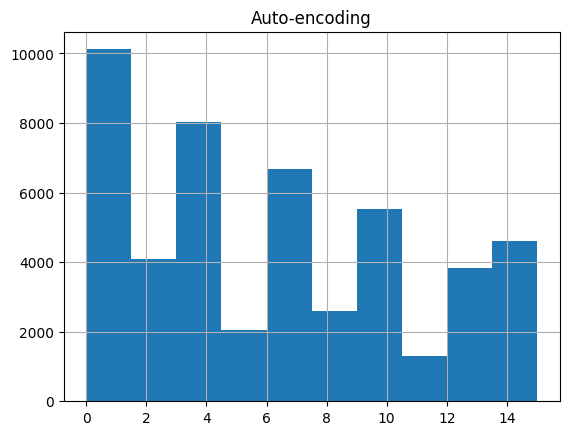

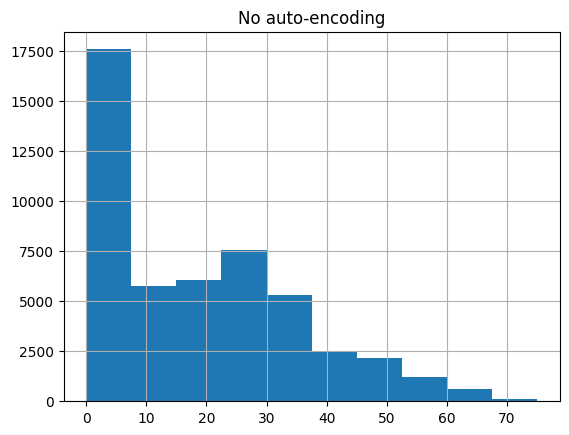

Best-First Search :    


Ionosphere :    

coverage auto-encoding: 338, (0.9629629629629629)
coverage no auto-encoding: 350, (0.9971509971509972)
# rows added in subgroups: 1 (0.002849002849002849)
# rows no longer in subgroups: 13, (0.037037037037037035)
average subgroup size auto encoded: 26.15
average subgroup size no auto encoding: 59.24
WRACC auto-encoding: Max: 0.04594930235955876, Mean: 0.013787712762071731
WRACC no auto-encoding: Max: 0.06939878734750526, Mean: 0.043401271093578775


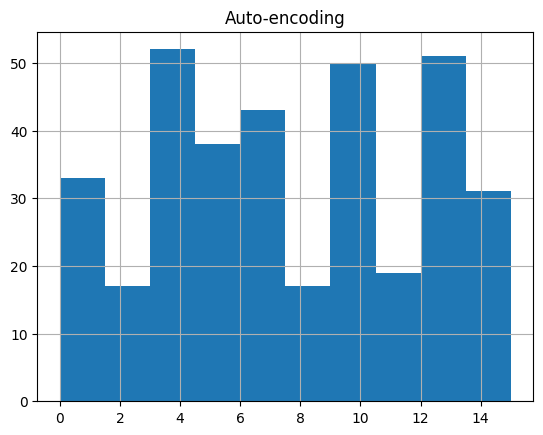

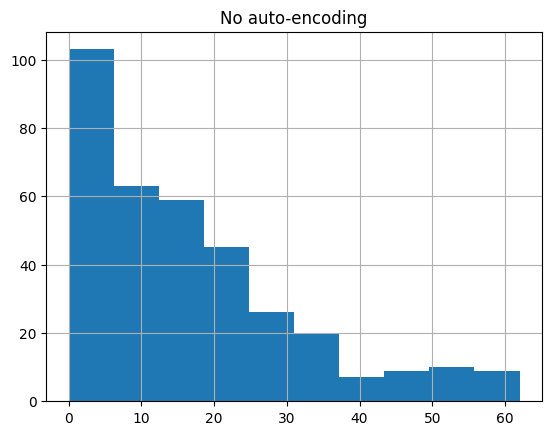

auto_encoder
coverage auto-encoding: 338, (0.9629629629629629)
coverage no auto-encoding: 350, (0.9971509971509972)
# rows added in subgroups: 1 (0.002849002849002849)
# rows no longer in subgroups: 13, (0.037037037037037035)
average subgroup size auto encoded: 26.15
average subgroup size no auto encoding: 59.24
WRACC auto-encoding: Max: 0.04594930235955876, Mean: 0.013787712762071731
WRACC no auto-encoding: Max: 0.06939878734750526, Mean: 0.043401271093578775


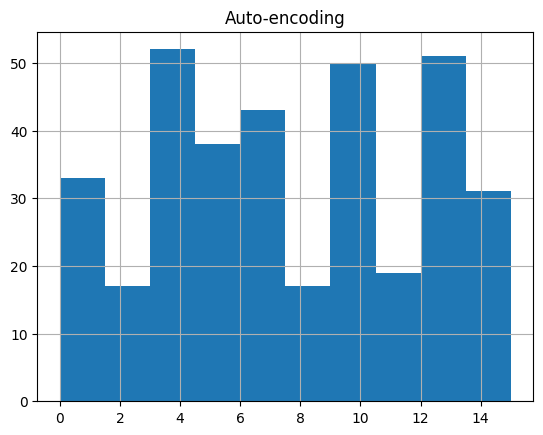

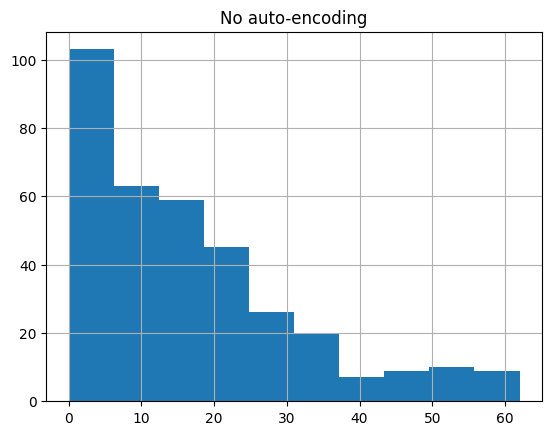

PCA
coverage auto-encoding: 339, (0.9658119658119658)
coverage no auto-encoding: 350, (0.9971509971509972)
# rows added in subgroups: 1 (0.002849002849002849)
# rows no longer in subgroups: 12, (0.03418803418803419)
average subgroup size auto encoded: 24.19
average subgroup size no auto encoding: 59.24
WRACC auto-encoding: Max: 0.060194316604573, Mean: 0.014684783402732118
WRACC no auto-encoding: Max: 0.06939878734750526, Mean: 0.043401271093578775


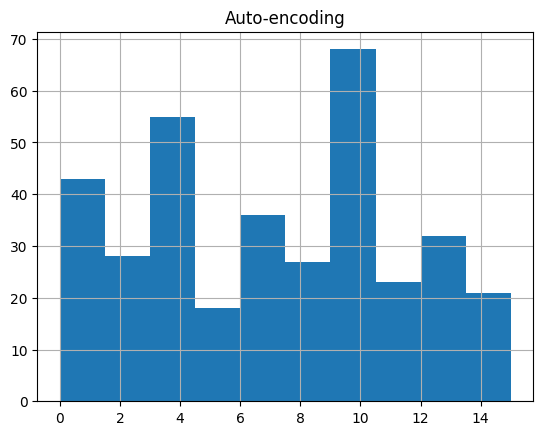

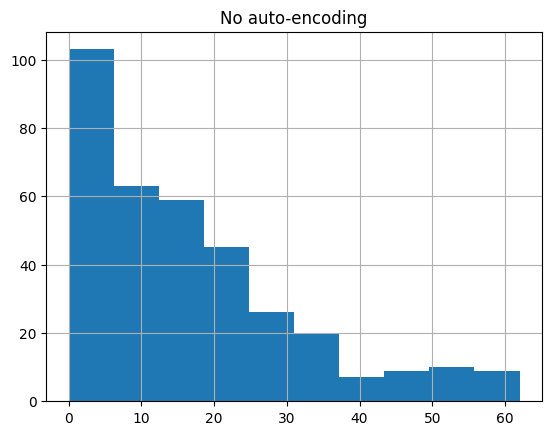

SPCA
coverage auto-encoding: 343, (0.9772079772079773)
coverage no auto-encoding: 350, (0.9971509971509972)
# rows added in subgroups: 1 (0.002849002849002849)
# rows no longer in subgroups: 8, (0.022792022792022793)
average subgroup size auto encoded: 24.8
average subgroup size no auto encoding: 59.24
WRACC auto-encoding: Max: 0.05836803272700707, Mean: 0.013273431222149164
WRACC no auto-encoding: Max: 0.06939878734750526, Mean: 0.043401271093578775


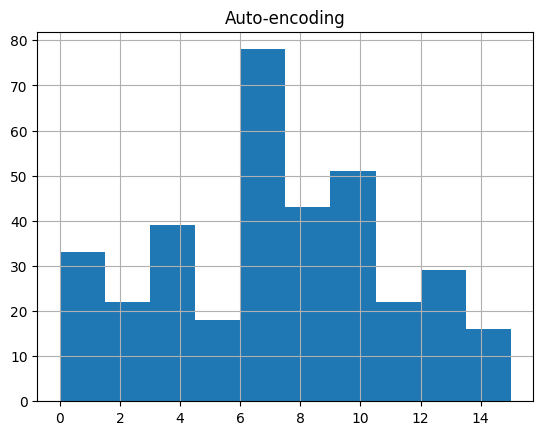

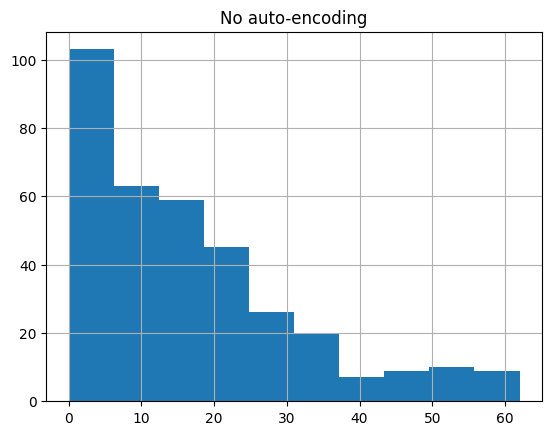

Arrhythmia :    

coverage auto-encoding: 395, (0.9404761904761905)
coverage no auto-encoding: 296, (0.7047619047619048)
# rows added in subgroups: 108 (0.2571428571428571)
# rows no longer in subgroups: 9, (0.02142857142857143)
average subgroup size auto encoded: 22.59
average subgroup size no auto encoding: 97.65
WRACC auto-encoding: Max: 0.06047619047619049, Mean: 0.009497619047619046
WRACC no auto-encoding: Max: 0.06554421768707483, Mean: 0.05814812925170067


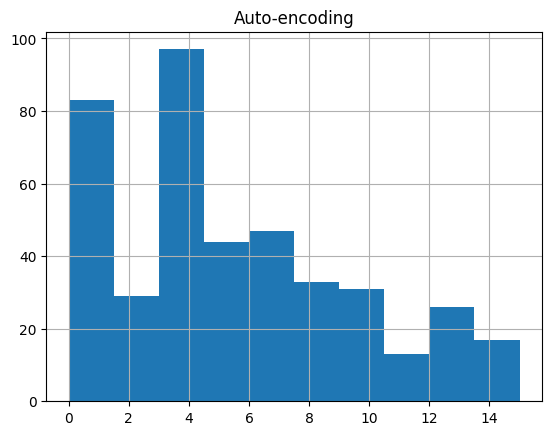

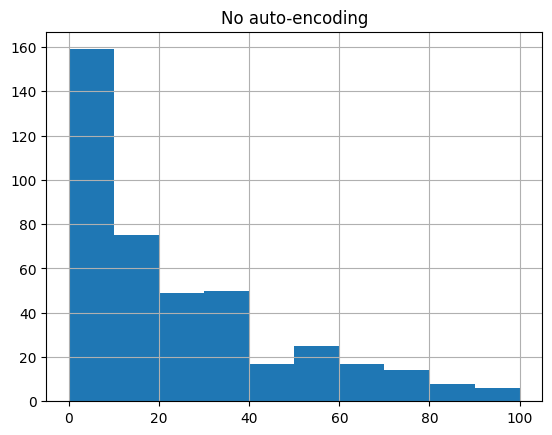

auto_encoder
coverage auto-encoding: 395, (0.9404761904761905)
coverage no auto-encoding: 296, (0.7047619047619048)
# rows added in subgroups: 108 (0.2571428571428571)
# rows no longer in subgroups: 9, (0.02142857142857143)
average subgroup size auto encoded: 22.59
average subgroup size no auto encoding: 97.65
WRACC auto-encoding: Max: 0.06047619047619049, Mean: 0.009497619047619046
WRACC no auto-encoding: Max: 0.06554421768707483, Mean: 0.05814812925170067


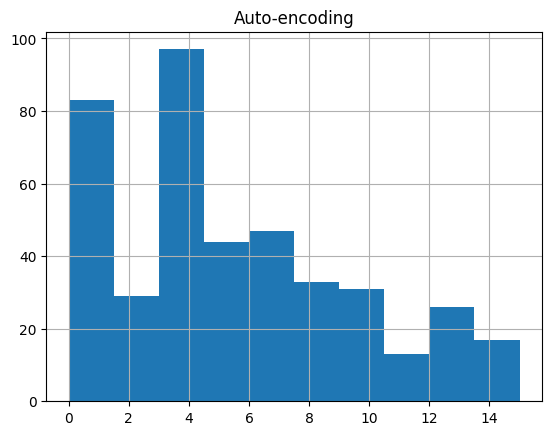

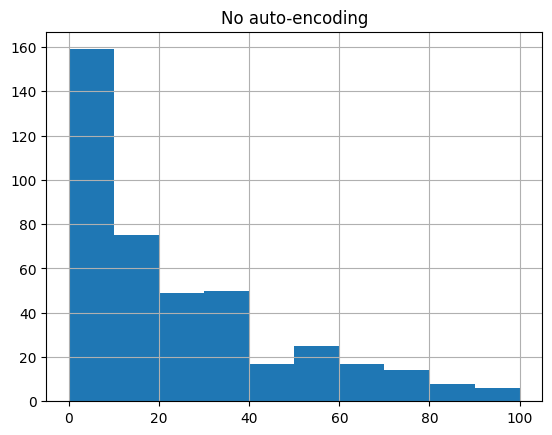

PCA
coverage auto-encoding: 406, (0.9666666666666667)
coverage no auto-encoding: 296, (0.7047619047619048)
# rows added in subgroups: 113 (0.26904761904761904)
# rows no longer in subgroups: 3, (0.007142857142857143)
average subgroup size auto encoded: 21.49
average subgroup size no auto encoding: 97.65
WRACC auto-encoding: Max: 0.06047619047619049, Mean: 0.005991666666666665
WRACC no auto-encoding: Max: 0.06554421768707483, Mean: 0.05814812925170067


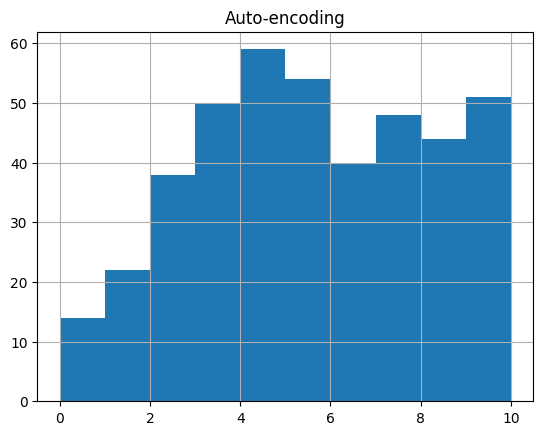

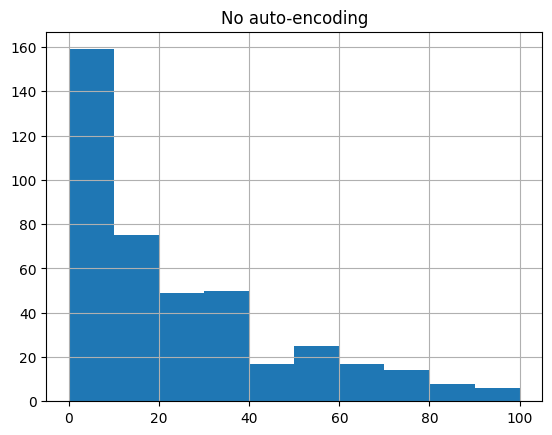

SPCA
coverage auto-encoding: 415, (0.9880952380952381)
coverage no auto-encoding: 296, (0.7047619047619048)
# rows added in subgroups: 120 (0.2857142857142857)
# rows no longer in subgroups: 1, (0.002380952380952381)
average subgroup size auto encoded: 24.02
average subgroup size no auto encoding: 97.65
WRACC auto-encoding: Max: 0.06761904761904762, Mean: 0.005257653061224488
WRACC no auto-encoding: Max: 0.06554421768707483, Mean: 0.05814812925170067


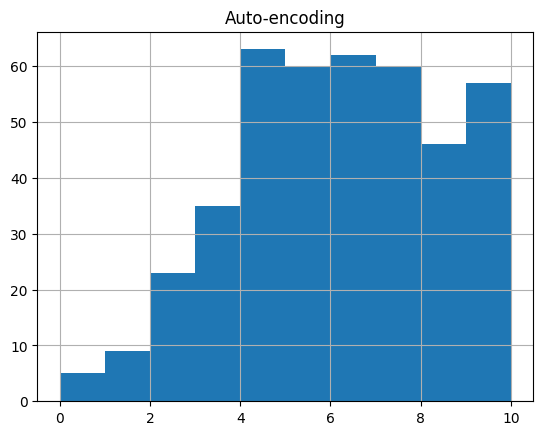

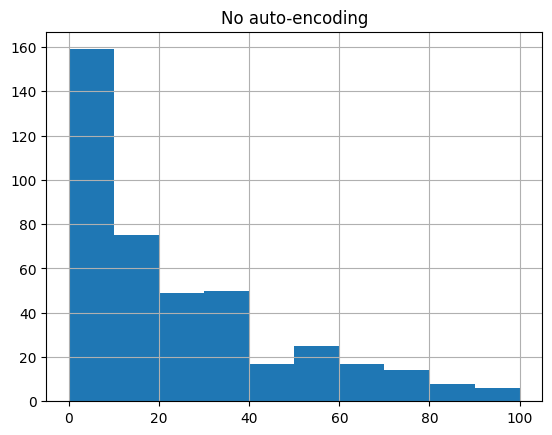

Indoor :    

coverage auto-encoding: 19418, (0.9225579627518053)
coverage no auto-encoding: 8417, (0.3998954770049411)
# rows added in subgroups: 11001 (0.5226624857468644)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 1164.57
average subgroup size no auto encoding: 4176.39
WRACC auto-encoding: Max: 0.08101853958612057, Mean: 0.013708722066707202
WRACC no auto-encoding: Max: 0.10696403189697552, Mean: 0.10639298479188797


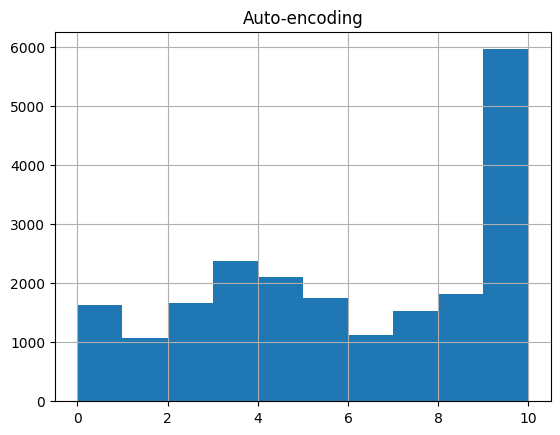

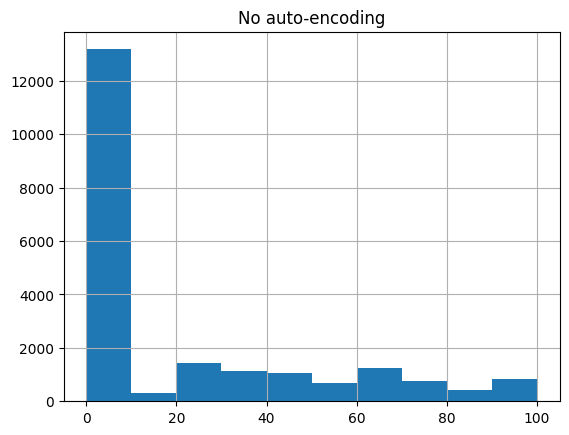

auto_encoder
coverage auto-encoding: 19418, (0.9225579627518053)
coverage no auto-encoding: 8417, (0.3998954770049411)
# rows added in subgroups: 11001 (0.5226624857468644)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 1164.57
average subgroup size no auto encoding: 4176.39
WRACC auto-encoding: Max: 0.08101853958612057, Mean: 0.013708722066707202
WRACC no auto-encoding: Max: 0.10696403189697552, Mean: 0.10639298479188797


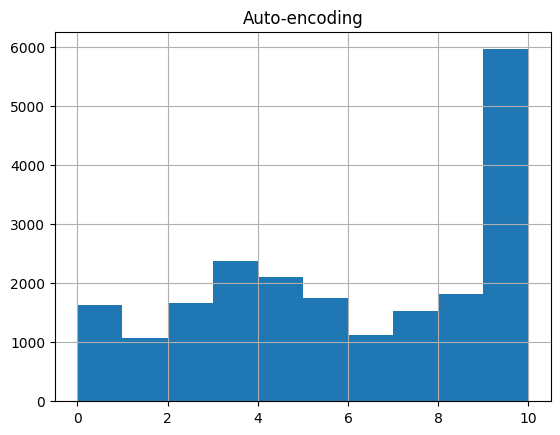

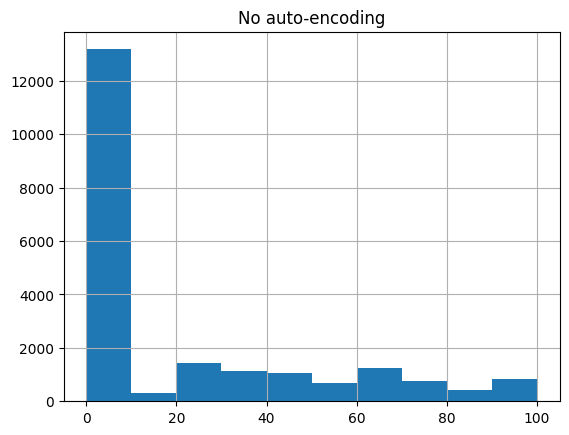

PCA
coverage auto-encoding: 15845, (0.7528031166856708)
coverage no auto-encoding: 8417, (0.3998954770049411)
# rows added in subgroups: 7428 (0.35290763968072975)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 1115.16
average subgroup size no auto encoding: 4176.39
WRACC auto-encoding: Max: 0.10726978901530895, Mean: 0.020435474918887326
WRACC no auto-encoding: Max: 0.10696403189697552, Mean: 0.10639298479188797


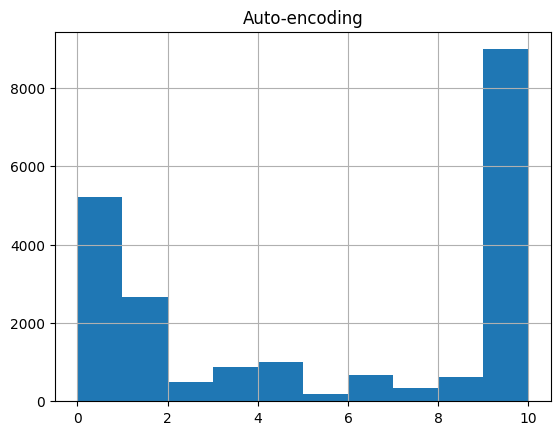

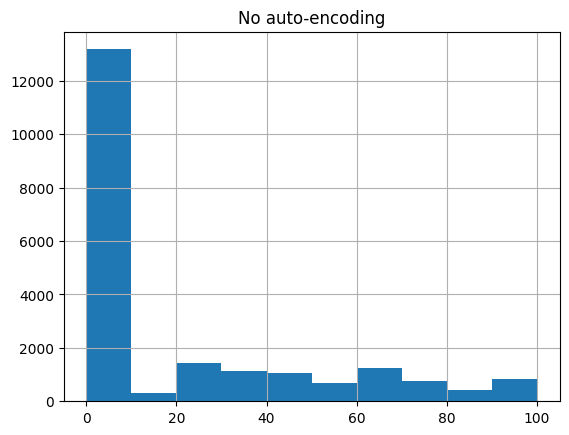

SPCA
coverage auto-encoding: 18146, (0.8621246674268339)
coverage no auto-encoding: 8417, (0.3998954770049411)
# rows added in subgroups: 9739 (0.46270429494488785)
# rows no longer in subgroups: 10, (0.0004751045229950589)
average subgroup size auto encoded: 1104.0
average subgroup size no auto encoding: 4176.39
WRACC auto-encoding: Max: 0.10724430925544784, Mean: 0.01743383460742967
WRACC no auto-encoding: Max: 0.10696403189697552, Mean: 0.10639298479188797


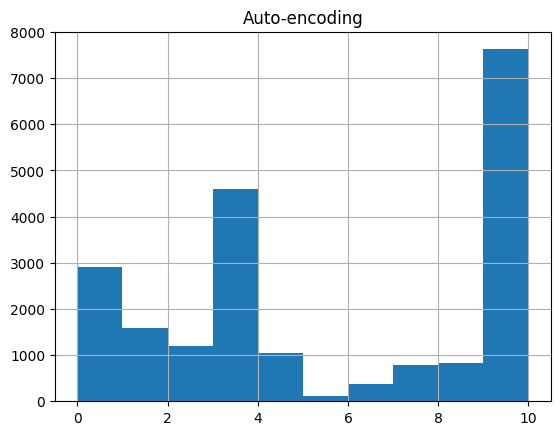

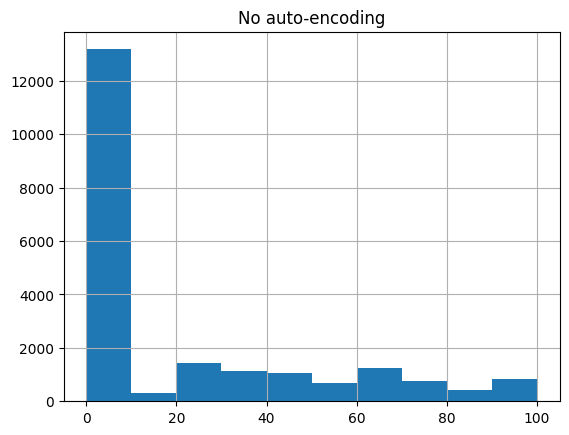

Soybean :    

coverage auto-encoding: 249, (0.9360902255639098)
coverage no auto-encoding: 251, (0.943609022556391)
# rows added in subgroups: 9 (0.03383458646616541)
# rows no longer in subgroups: 11, (0.041353383458646614)
average subgroup size auto encoded: 17.49
average subgroup size no auto encoding: 134.99
WRACC auto-encoding: Max: 0.10379331788116908, Mean: 0.01871106337271751
WRACC no auto-encoding: Max: 0.24068630222171972, Mean: 0.16175730680083666


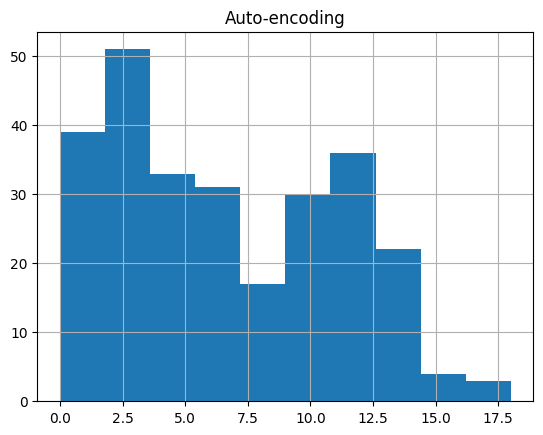

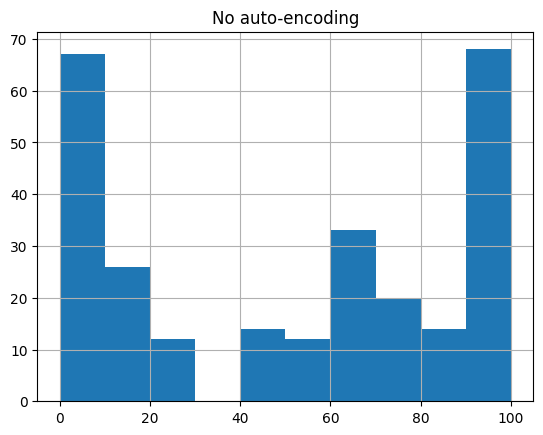

auto_encoder
coverage auto-encoding: 249, (0.9360902255639098)
coverage no auto-encoding: 251, (0.943609022556391)
# rows added in subgroups: 9 (0.03383458646616541)
# rows no longer in subgroups: 11, (0.041353383458646614)
average subgroup size auto encoded: 17.49
average subgroup size no auto encoding: 134.99
WRACC auto-encoding: Max: 0.10379331788116908, Mean: 0.01871106337271751
WRACC no auto-encoding: Max: 0.24068630222171972, Mean: 0.16175730680083666


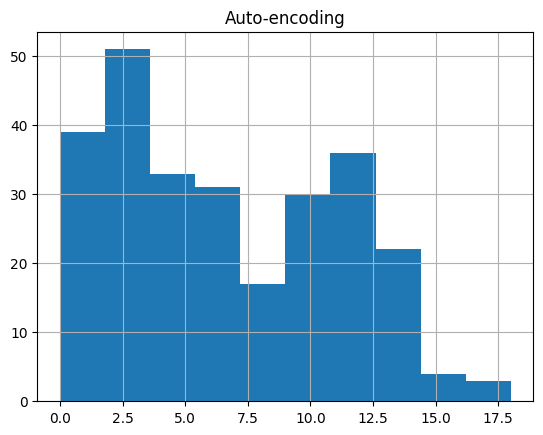

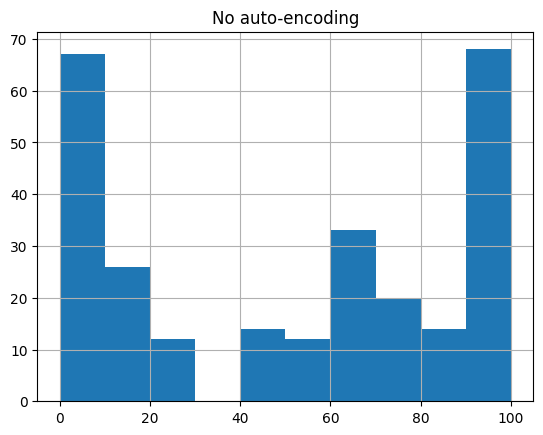

PCA
coverage auto-encoding: 264, (0.9924812030075187)
coverage no auto-encoding: 251, (0.943609022556391)
# rows added in subgroups: 13 (0.04887218045112782)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 16.87
average subgroup size no auto encoding: 134.99
WRACC auto-encoding: Max: 0.06427723443948218, Mean: 0.012125897450392902
WRACC no auto-encoding: Max: 0.24068630222171972, Mean: 0.16175730680083666


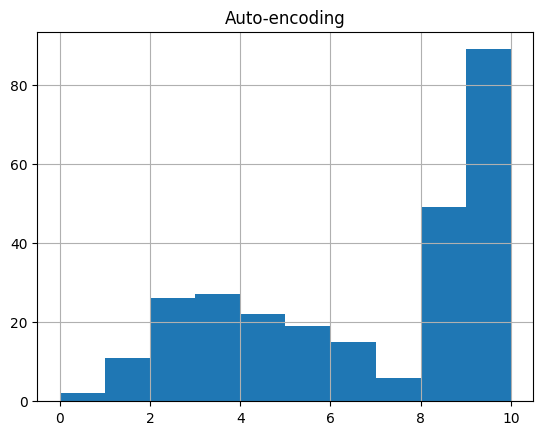

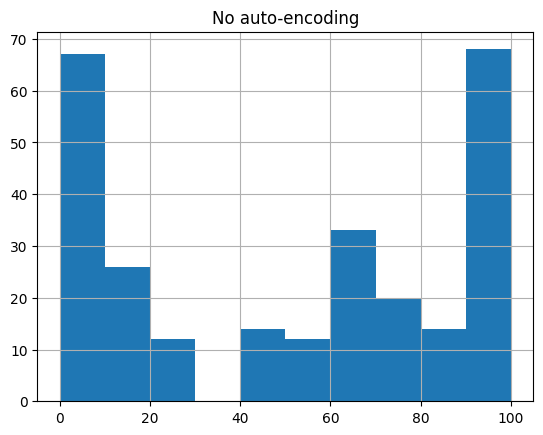

SPCA
coverage auto-encoding: 266, (1.0)
coverage no auto-encoding: 251, (0.943609022556391)
# rows added in subgroups: 15 (0.05639097744360902)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 15.88
average subgroup size no auto encoding: 134.99
WRACC auto-encoding: Max: 0.09811182090564757, Mean: 0.010088473062355137
WRACC no auto-encoding: Max: 0.24068630222171972, Mean: 0.16175730680083666


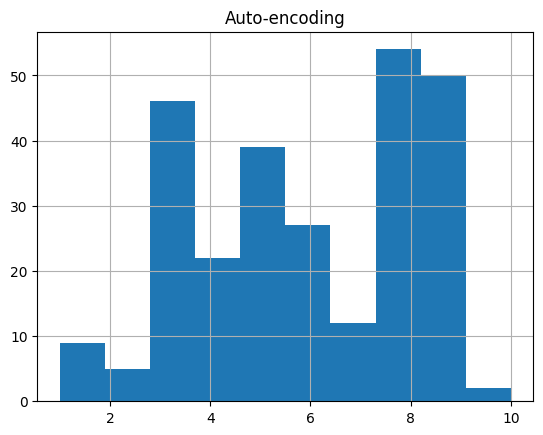

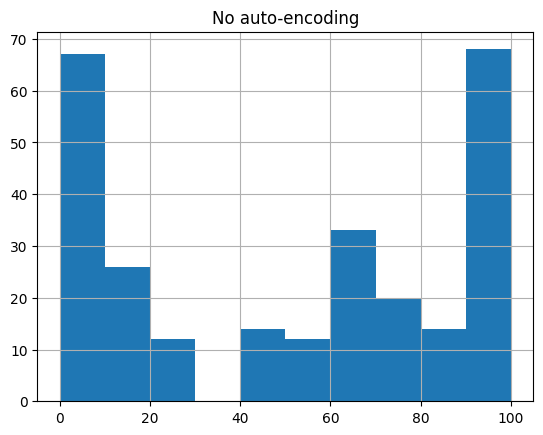

Mushroom :    

coverage auto-encoding: 7751, (0.9540866568193008)
coverage no auto-encoding: 8124, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 373, (0.045913343180699166)
average subgroup size auto encoded: 486.9
average subgroup size no auto encoding: 2105.28
WRACC auto-encoding: Max: 0.07677296827776069, Mean: 0.015498338044893029
WRACC no auto-encoding: Max: 0.1823755424596742, Mean: 0.09028494814860072


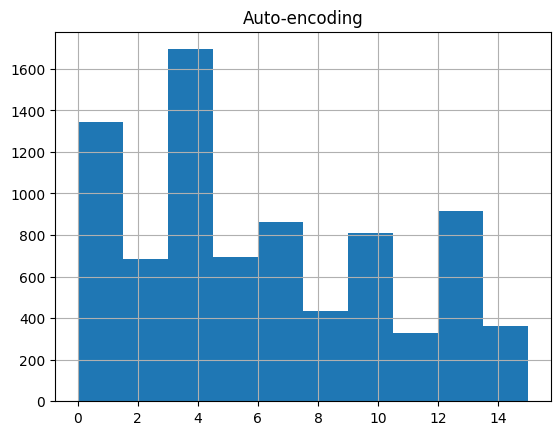

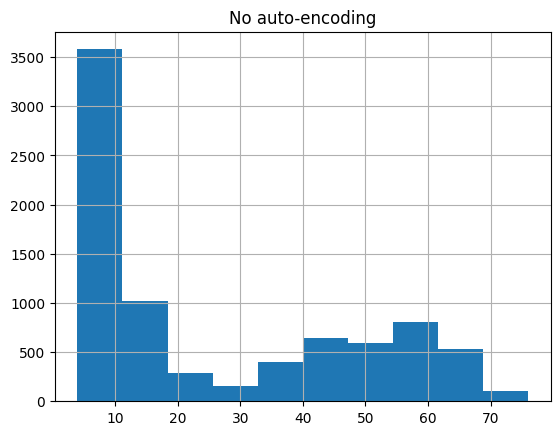

auto_encoder
coverage auto-encoding: 7751, (0.9540866568193008)
coverage no auto-encoding: 8124, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 373, (0.045913343180699166)
average subgroup size auto encoded: 486.9
average subgroup size no auto encoding: 2105.28
WRACC auto-encoding: Max: 0.07677296827776069, Mean: 0.015498338044893029
WRACC no auto-encoding: Max: 0.1823755424596742, Mean: 0.09028494814860072


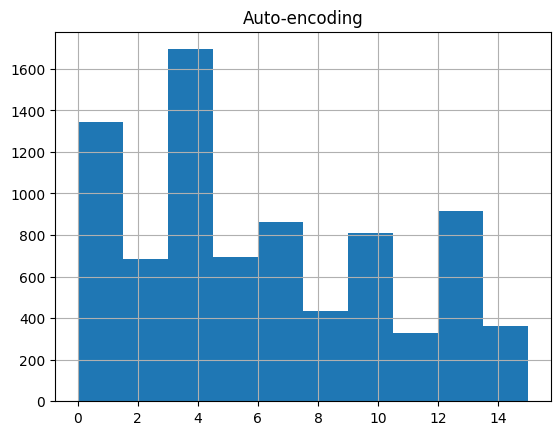

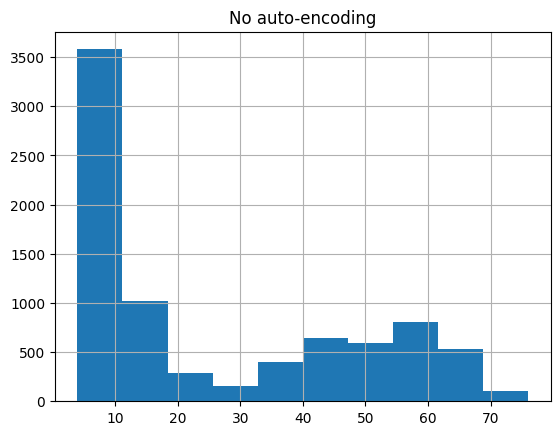

PCA
coverage auto-encoding: 7153, (0.8804775972427376)
coverage no auto-encoding: 8124, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 971, (0.11952240275726243)
average subgroup size auto encoded: 759.22
average subgroup size no auto encoding: 2105.28
WRACC auto-encoding: Max: 0.10354328198496907, Mean: 0.04005249867816932
WRACC no auto-encoding: Max: 0.1823755424596742, Mean: 0.09028494814860072


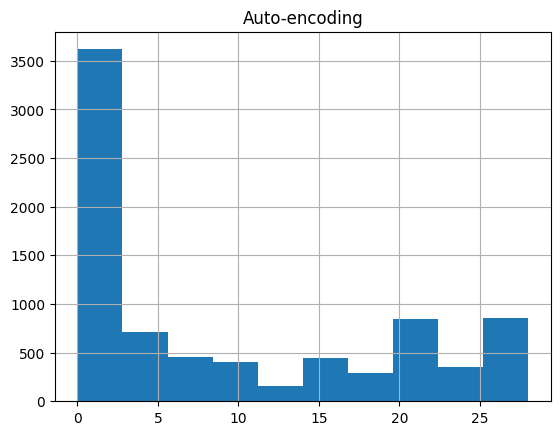

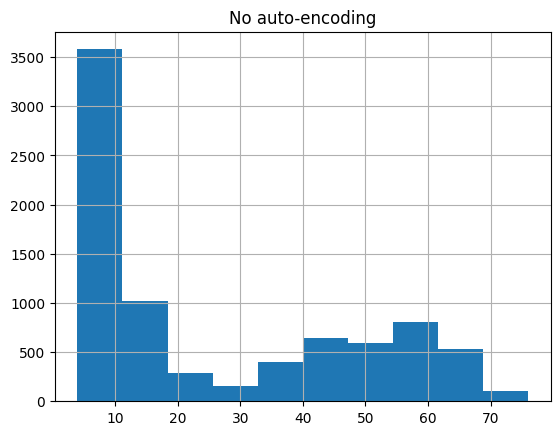

SPCA
coverage auto-encoding: 7150, (0.8801083210241261)
coverage no auto-encoding: 8124, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 974, (0.11989167897587395)
average subgroup size auto encoded: 622.89
average subgroup size no auto encoding: 2105.28
WRACC auto-encoding: Max: 0.10354328198496907, Mean: 0.03152908172949999
WRACC no auto-encoding: Max: 0.1823755424596742, Mean: 0.09028494814860072


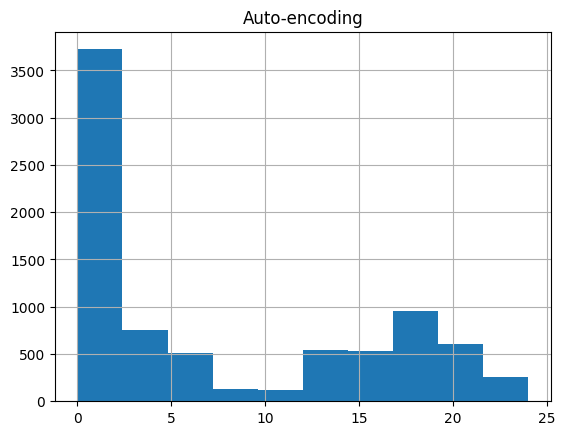

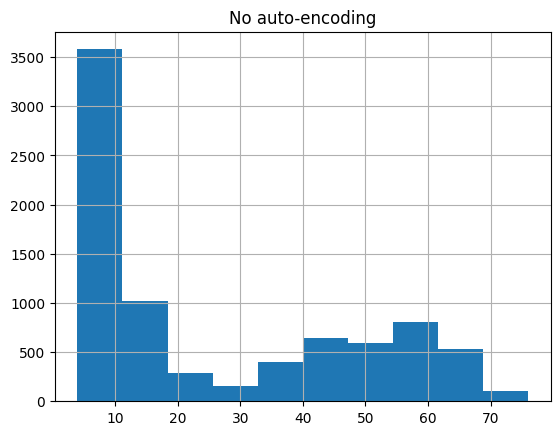

Adult :    

coverage auto-encoding: 48842, (1.0)
coverage no auto-encoding: 41678, (0.8533229597477581)
# rows added in subgroups: 7164 (0.14667704025224193)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 4308.985294117647
average subgroup size no auto encoding: 9164.5
WRACC auto-encoding: Max: 0.027494046419569255, Mean: 2.5618372265606845e-06
WRACC no auto-encoding: Max: 0.06345601575676821, Mean: 0.024945288728229945


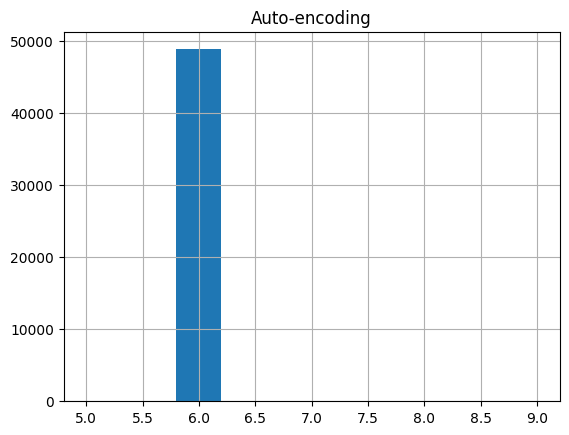

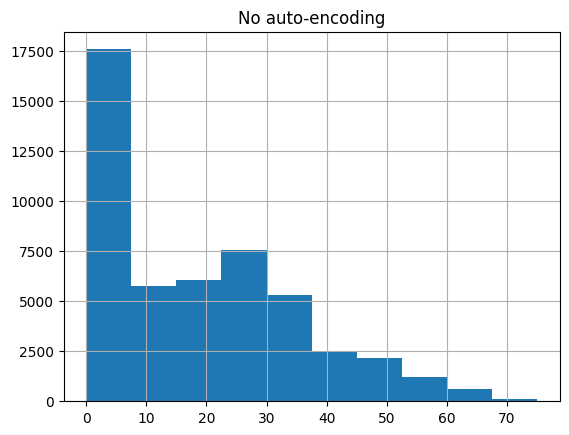

auto_encoder
coverage auto-encoding: 48842, (1.0)
coverage no auto-encoding: 41678, (0.8533229597477581)
# rows added in subgroups: 7164 (0.14667704025224193)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 4308.985294117647
average subgroup size no auto encoding: 9164.5
WRACC auto-encoding: Max: 0.027494046419569255, Mean: 2.5618372265606845e-06
WRACC no auto-encoding: Max: 0.06345601575676821, Mean: 0.024945288728229945


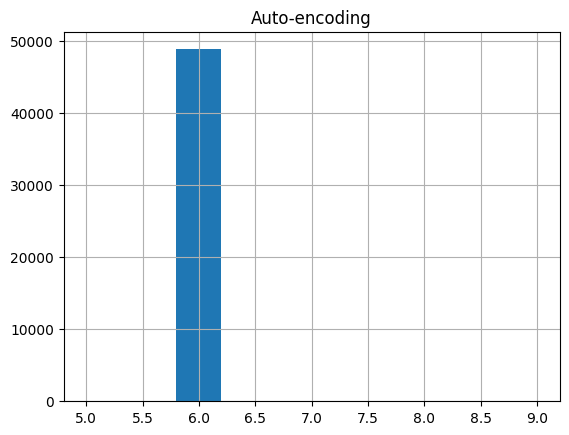

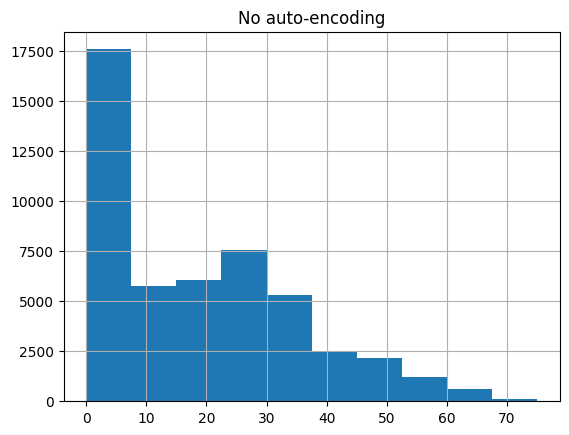

PCA
coverage auto-encoding: 45107, (0.9235289300192457)
coverage no auto-encoding: 41678, (0.8533229597477581)
# rows added in subgroups: 6296 (0.1289054502272634)
# rows no longer in subgroups: 2867, (0.05869947995577577)
average subgroup size auto encoded: 3188.15
average subgroup size no auto encoding: 9164.5
WRACC auto-encoding: Max: 0.048272054321344286, Mean: 0.0067353636858360835
WRACC no auto-encoding: Max: 0.06345601575676821, Mean: 0.024945288728229945


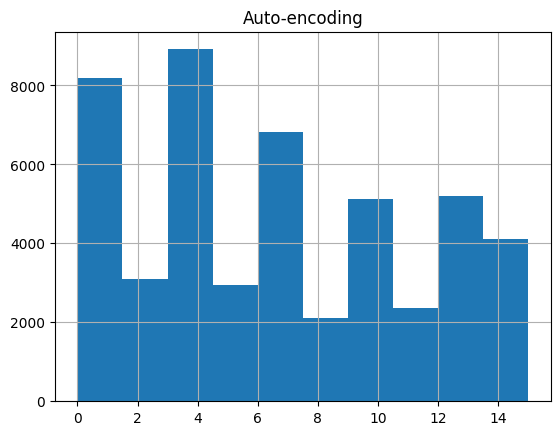

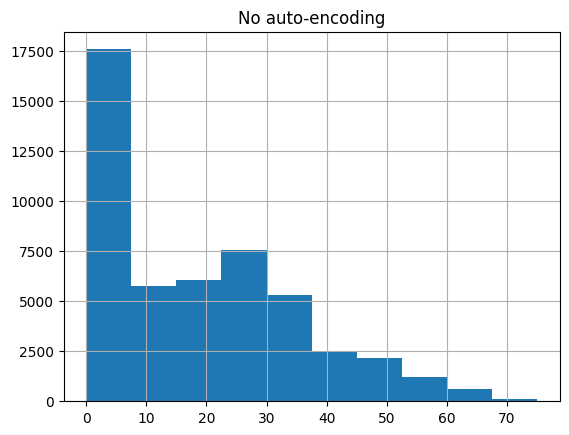

SPCA
coverage auto-encoding: 44482, (0.9107325662339789)
coverage no auto-encoding: 41678, (0.8533229597477581)
# rows added in subgroups: 5318 (0.10888170017607797)
# rows no longer in subgroups: 2514, (0.05147209368985709)
average subgroup size auto encoded: 2975.67
average subgroup size no auto encoding: 9164.5
WRACC auto-encoding: Max: 0.036847460733858105, Mean: 0.0069393533248083865
WRACC no auto-encoding: Max: 0.06345601575676821, Mean: 0.024945288728229945


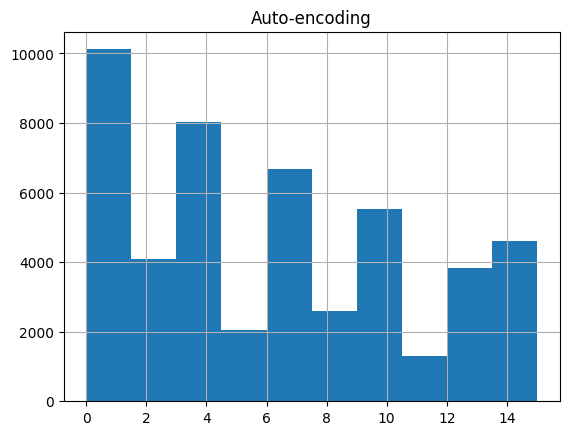

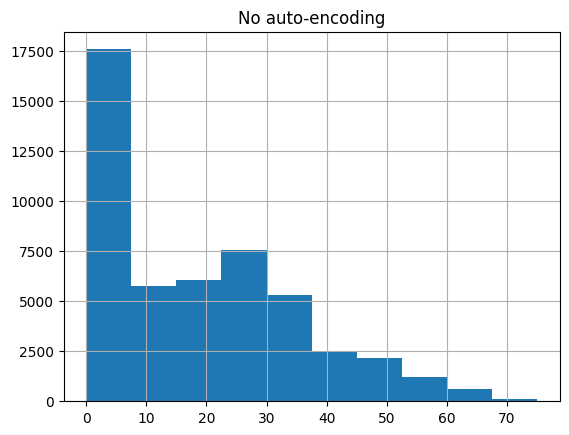

Apriori :    


Ionosphere :    

coverage auto-encoding: 351, (1.0)
coverage no auto-encoding: 351, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 70.2
average subgroup size no auto encoding: 79.87
WRACC auto-encoding: Max: 0.04594930235955876, Mean: -1.27675647831893e-17
WRACC no auto-encoding: Max: 0.06939878734750526, Mean: 0.02507122507122506


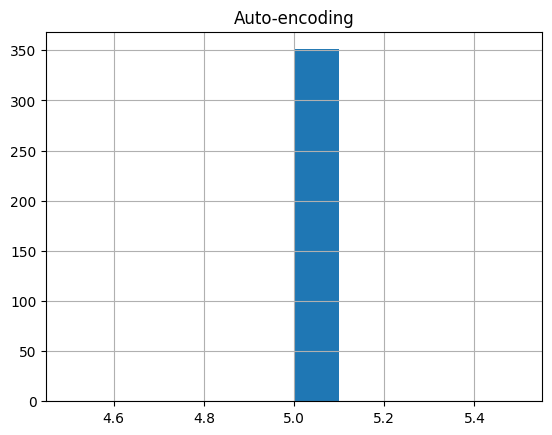

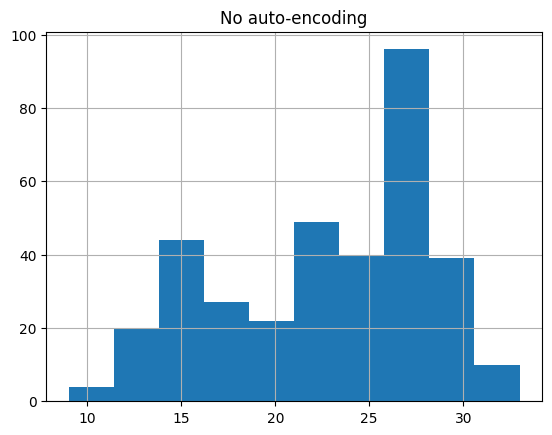

auto_encoder
coverage auto-encoding: 351, (1.0)
coverage no auto-encoding: 351, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 70.2
average subgroup size no auto encoding: 79.87
WRACC auto-encoding: Max: 0.04594930235955876, Mean: -1.27675647831893e-17
WRACC no auto-encoding: Max: 0.06939878734750526, Mean: 0.02507122507122506


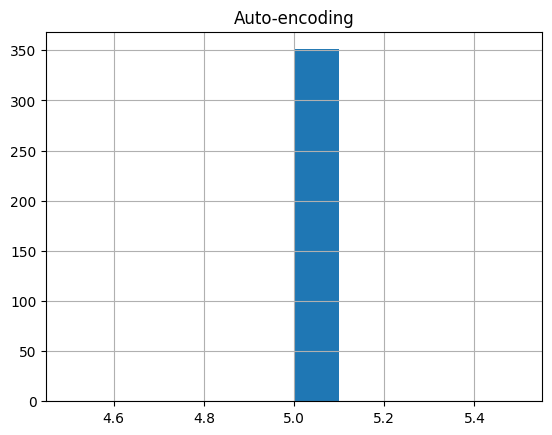

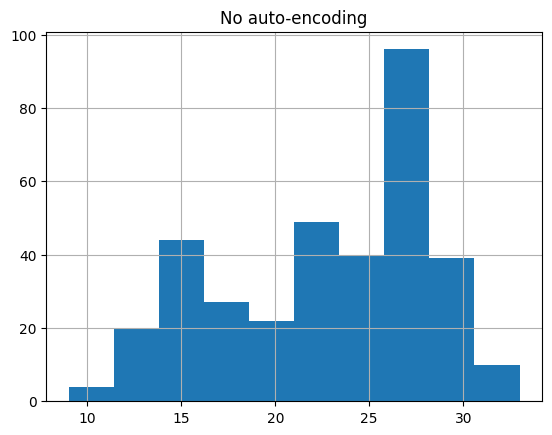

PCA
coverage auto-encoding: 351, (1.0)
coverage no auto-encoding: 351, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 70.2
average subgroup size no auto encoding: 79.87
WRACC auto-encoding: Max: 0.060194316604573, Mean: -1.0547118733938987e-17
WRACC no auto-encoding: Max: 0.06939878734750526, Mean: 0.02507122507122506


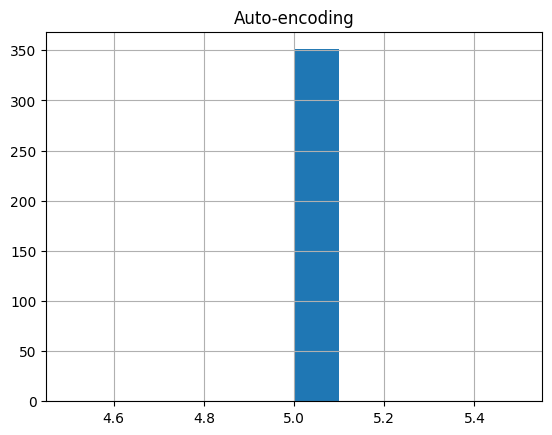

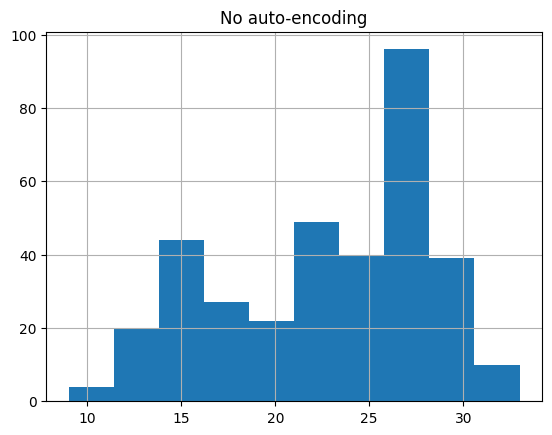

SPCA
coverage auto-encoding: 351, (1.0)
coverage no auto-encoding: 351, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 70.20833333333333
average subgroup size no auto encoding: 79.87
WRACC auto-encoding: Max: 0.05836803272700707, Mean: -1.5219032313062292e-05
WRACC no auto-encoding: Max: 0.06939878734750526, Mean: 0.02507122507122506


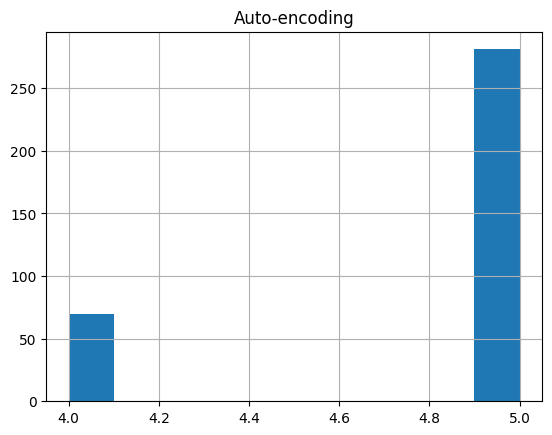

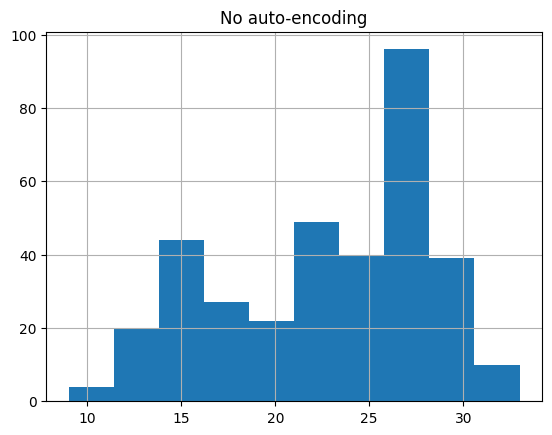

Arrhythmia :    

coverage auto-encoding: 420, (1.0)
coverage no auto-encoding: 418, (0.9952380952380953)
# rows added in subgroups: 2 (0.004761904761904762)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 84.0
average subgroup size no auto encoding: 82.65
WRACC auto-encoding: Max: 0.06047619047619049, Mean: -2.7755575615628915e-18
WRACC no auto-encoding: Max: 0.06346938775510204, Mean: 0.03678741496598639


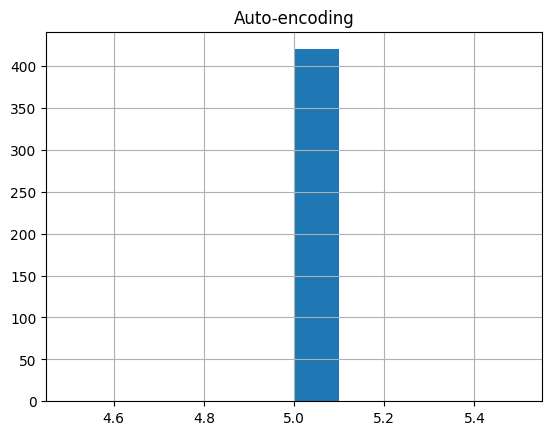

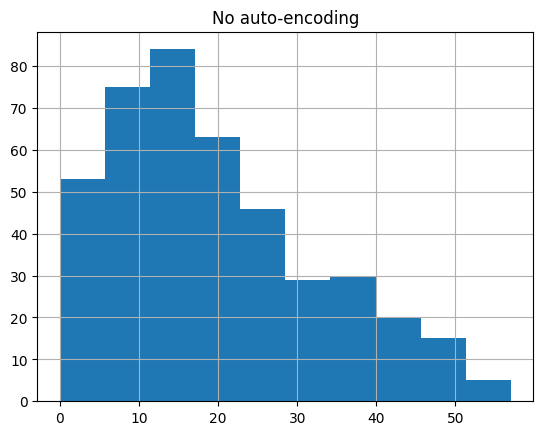

auto_encoder
coverage auto-encoding: 420, (1.0)
coverage no auto-encoding: 418, (0.9952380952380953)
# rows added in subgroups: 2 (0.004761904761904762)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 84.0
average subgroup size no auto encoding: 82.65
WRACC auto-encoding: Max: 0.06047619047619049, Mean: -2.7755575615628915e-18
WRACC no auto-encoding: Max: 0.06346938775510204, Mean: 0.03678741496598639


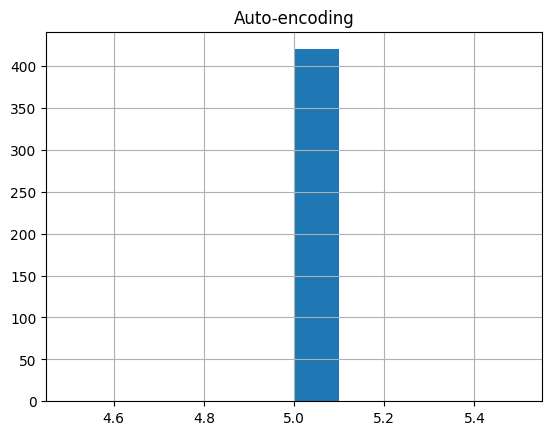

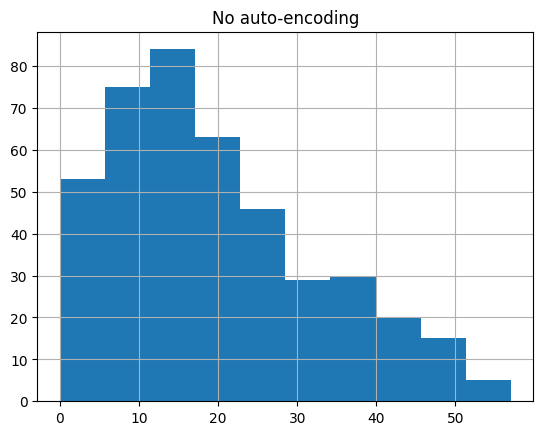

PCA
coverage auto-encoding: 420, (1.0)
coverage no auto-encoding: 418, (0.9952380952380953)
# rows added in subgroups: 2 (0.004761904761904762)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 84.0
average subgroup size no auto encoding: 82.65
WRACC auto-encoding: Max: 0.06047619047619049, Mean: 6.938893903907229e-19
WRACC no auto-encoding: Max: 0.06346938775510204, Mean: 0.03678741496598639


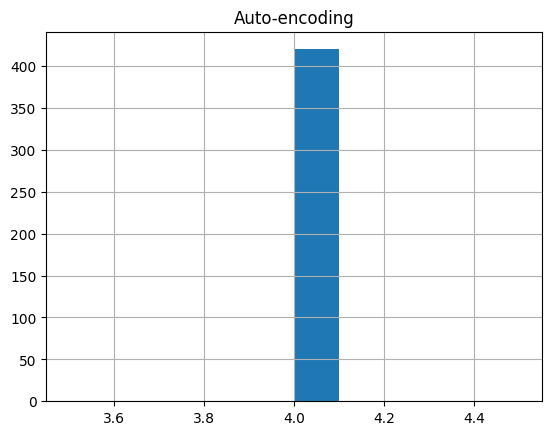

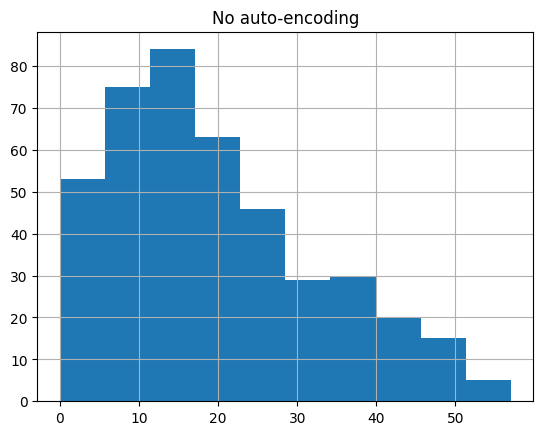

SPCA
coverage auto-encoding: 420, (1.0)
coverage no auto-encoding: 418, (0.9952380952380953)
# rows added in subgroups: 2 (0.004761904761904762)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 84.15789473684211
average subgroup size no auto encoding: 82.65
WRACC auto-encoding: Max: 0.06761904761904762, Mean: 0.0008270676691729302
WRACC no auto-encoding: Max: 0.06346938775510204, Mean: 0.03678741496598639


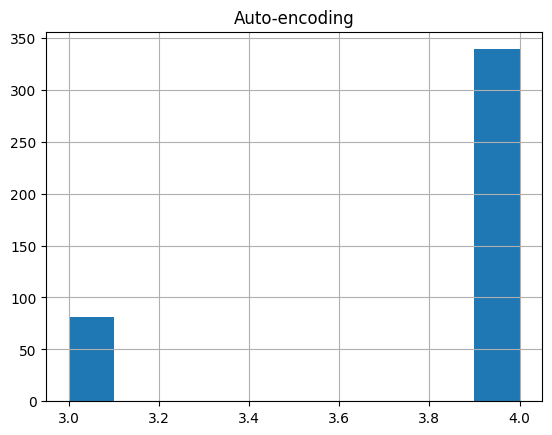

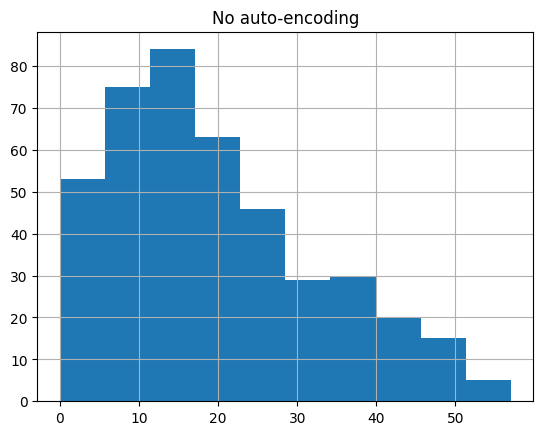

Indoor :    

coverage auto-encoding: 21048, (1.0)
coverage no auto-encoding: 21048, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 4209.6
average subgroup size no auto encoding: 9145.19
WRACC auto-encoding: Max: 0.08101853958612057, Mean: -6.938893903907229e-19
WRACC no auto-encoding: Max: 0.10696403189697552, Mean: 0.05797448567723289


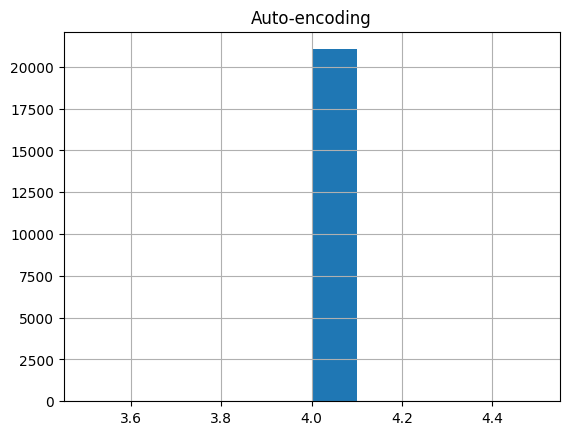

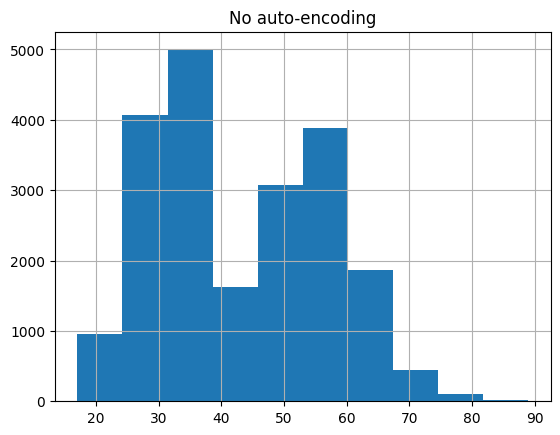

auto_encoder
coverage auto-encoding: 21048, (1.0)
coverage no auto-encoding: 21048, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 4209.6
average subgroup size no auto encoding: 9145.19
WRACC auto-encoding: Max: 0.08101853958612057, Mean: -6.938893903907229e-19
WRACC no auto-encoding: Max: 0.10696403189697552, Mean: 0.05797448567723289


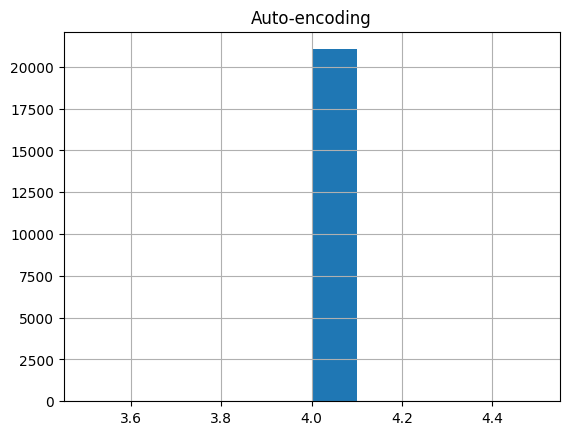

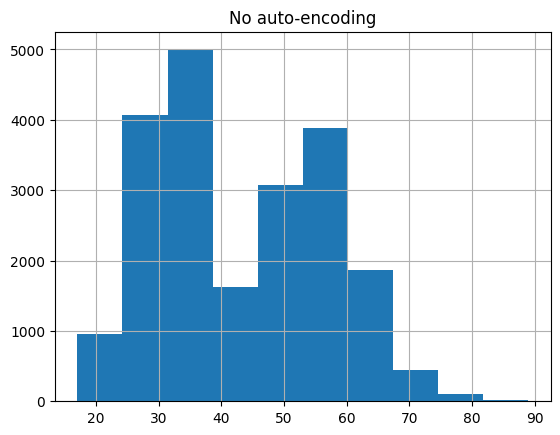

PCA
coverage auto-encoding: 21048, (1.0)
coverage no auto-encoding: 21048, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 4209.6
average subgroup size no auto encoding: 9145.19
WRACC auto-encoding: Max: 0.10726978901530895, Mean: 2.7755575615628915e-18
WRACC no auto-encoding: Max: 0.10696403189697552, Mean: 0.05797448567723289


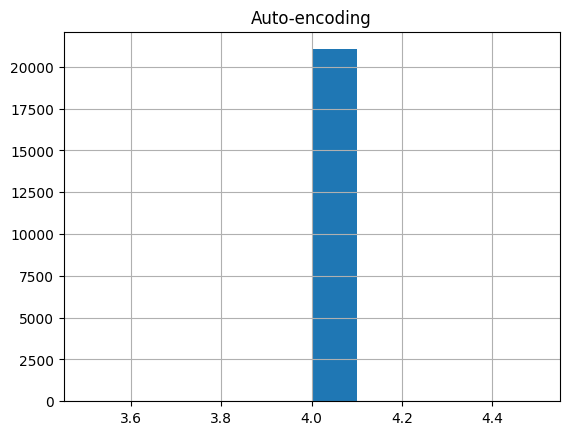

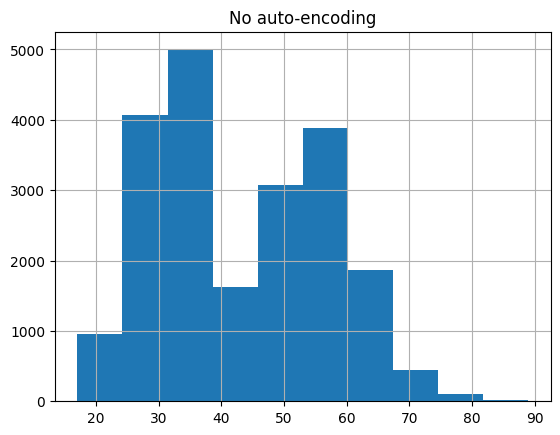

SPCA
coverage auto-encoding: 21048, (1.0)
coverage no auto-encoding: 21048, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 4209.6
average subgroup size no auto encoding: 9145.19
WRACC auto-encoding: Max: 0.10724430925544784, Mean: 2.7755575615628915e-18
WRACC no auto-encoding: Max: 0.10696403189697552, Mean: 0.05797448567723289


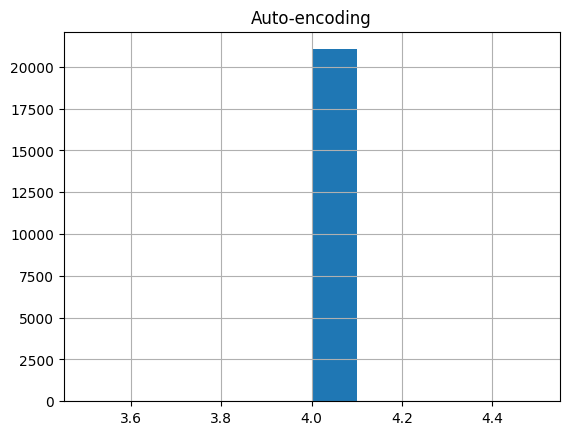

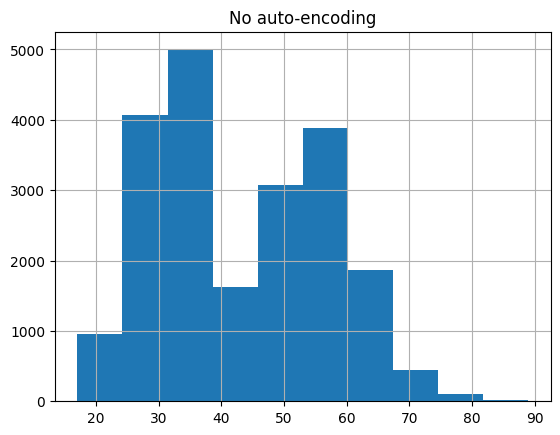

Soybean :    

coverage auto-encoding: 266, (1.0)
coverage no auto-encoding: 266, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 53.2
average subgroup size no auto encoding: 95.97938144329896
WRACC auto-encoding: Max: 0.10379331788116908, Mean: 3.7007434154171884e-18
WRACC no auto-encoding: Max: 0.2223133020521228, Mean: 8.584198644008943e-18


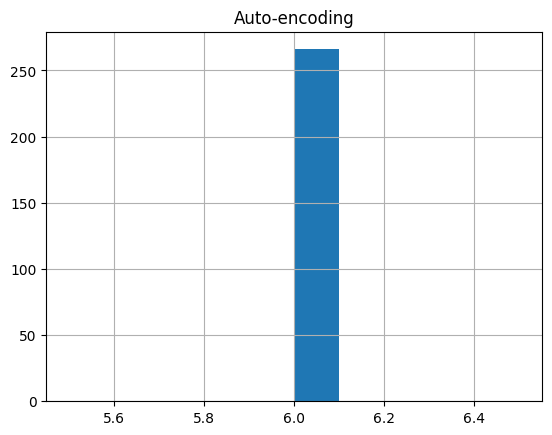

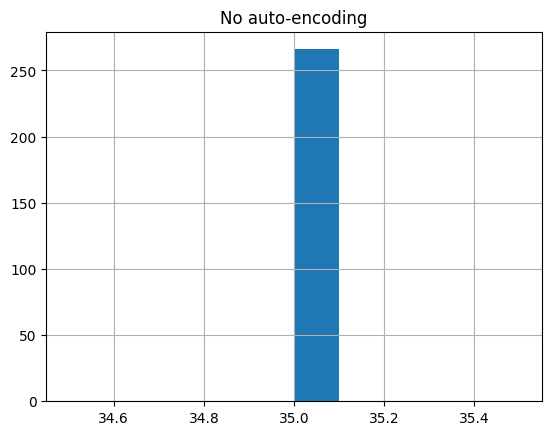

auto_encoder
coverage auto-encoding: 266, (1.0)
coverage no auto-encoding: 266, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 53.2
average subgroup size no auto encoding: 95.97938144329896
WRACC auto-encoding: Max: 0.10379331788116908, Mean: 3.7007434154171884e-18
WRACC no auto-encoding: Max: 0.2223133020521228, Mean: 8.584198644008943e-18


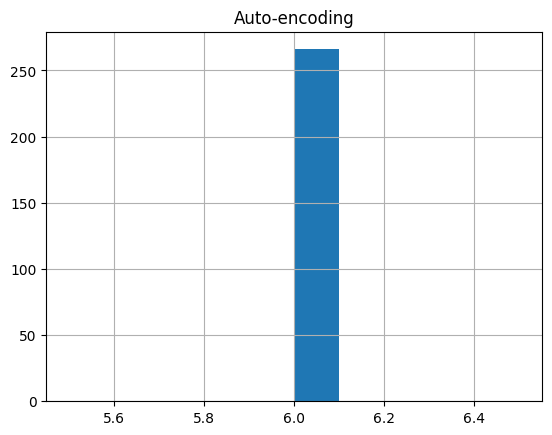

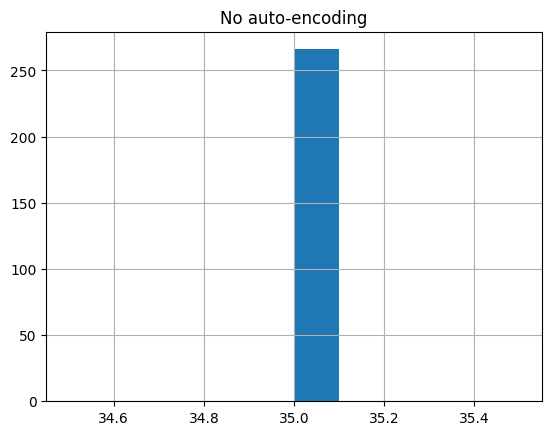

PCA
coverage auto-encoding: 266, (1.0)
coverage no auto-encoding: 266, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 53.2
average subgroup size no auto encoding: 95.97938144329896
WRACC auto-encoding: Max: 0.06427723443948218, Mean: 3.469446951953614e-18
WRACC no auto-encoding: Max: 0.2223133020521228, Mean: 8.584198644008943e-18


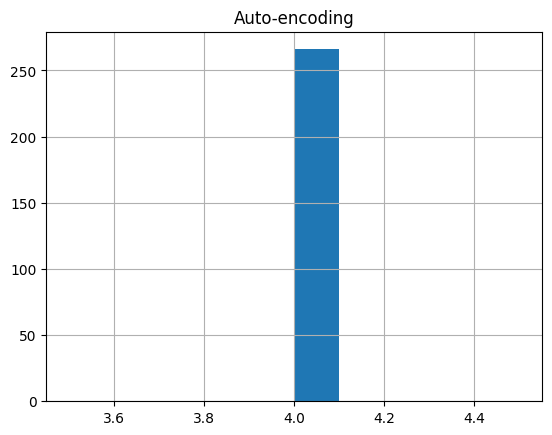

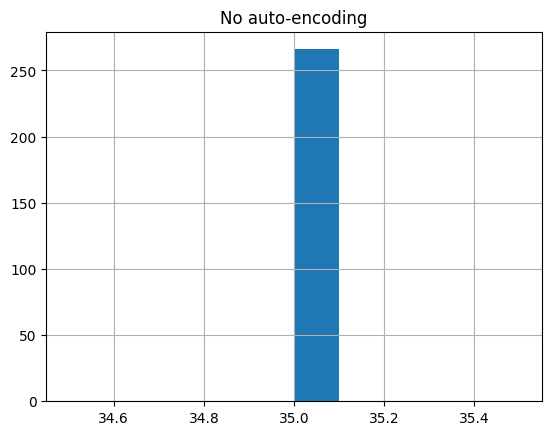

SPCA
coverage auto-encoding: 266, (1.0)
coverage no auto-encoding: 266, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 53.2
average subgroup size no auto encoding: 95.97938144329896
WRACC auto-encoding: Max: 0.09811182090564757, Mean: 7.632783294297952e-18
WRACC no auto-encoding: Max: 0.2223133020521228, Mean: 8.584198644008943e-18


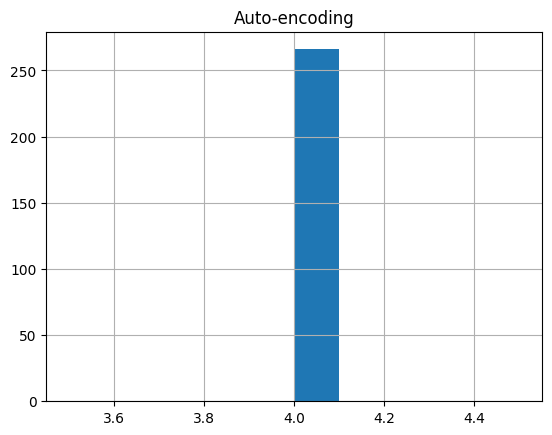

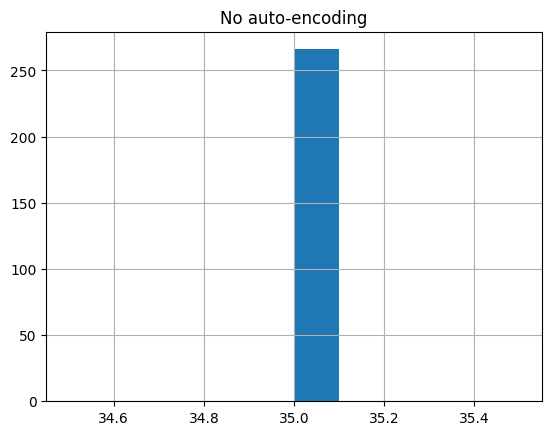

Mushroom :    

coverage auto-encoding: 8124, (1.0)
coverage no auto-encoding: 8124, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 1624.8
average subgroup size no auto encoding: 1297.18
WRACC auto-encoding: Max: 0.07677296827776069, Mean: 2.7755575615628915e-18
WRACC no auto-encoding: Max: 0.13771766569429383, Mean: 0.013828433771858693


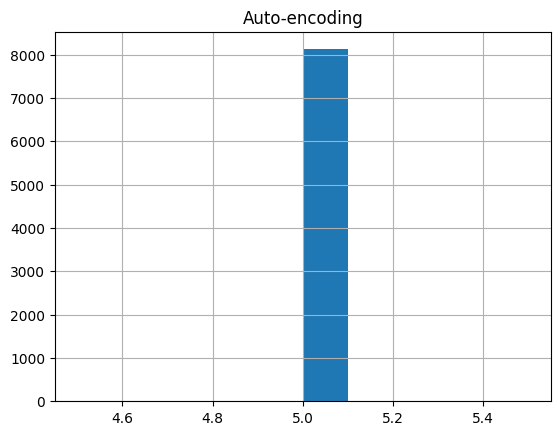

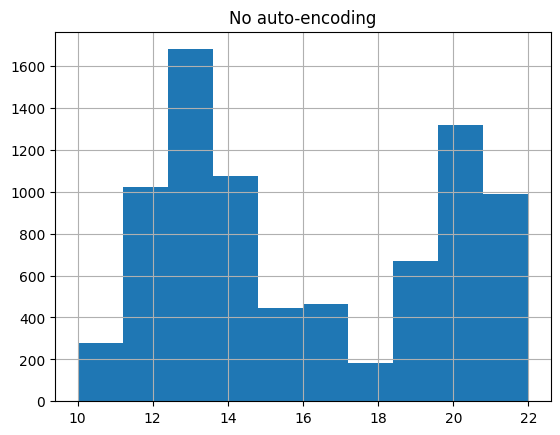

auto_encoder
coverage auto-encoding: 8124, (1.0)
coverage no auto-encoding: 8124, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 1624.8
average subgroup size no auto encoding: 1297.18
WRACC auto-encoding: Max: 0.07677296827776069, Mean: 2.7755575615628915e-18
WRACC no auto-encoding: Max: 0.13771766569429383, Mean: 0.013828433771858693


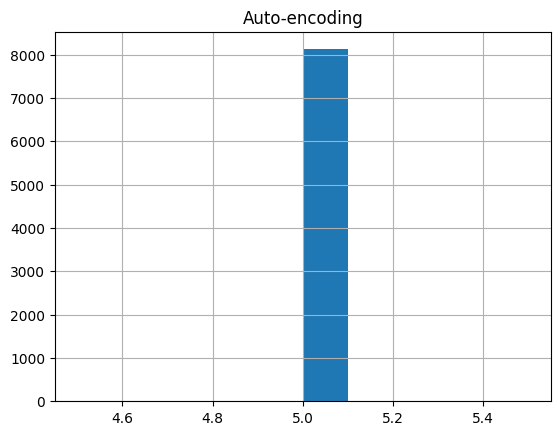

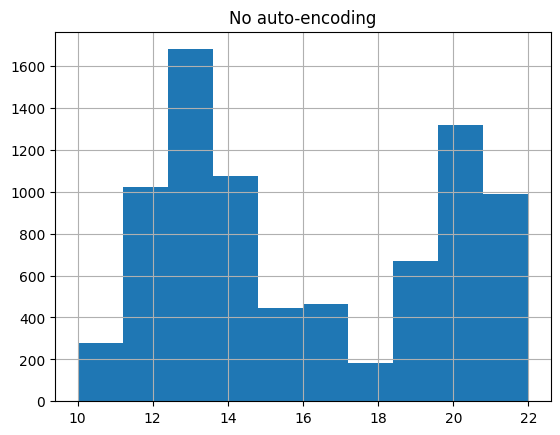

PCA
coverage auto-encoding: 8124, (1.0)
coverage no auto-encoding: 8124, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 1624.8
average subgroup size no auto encoding: 1297.18
WRACC auto-encoding: Max: 0.10354328198496907, Mean: 4.3615904538845435e-18
WRACC no auto-encoding: Max: 0.13771766569429383, Mean: 0.013828433771858693


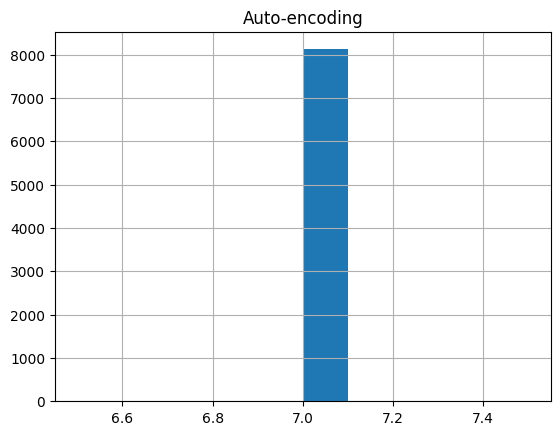

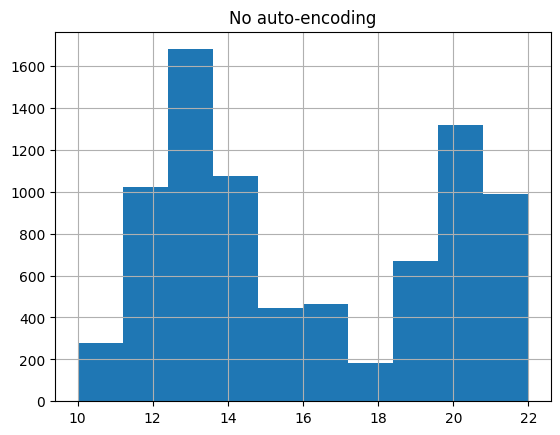

SPCA
coverage auto-encoding: 8124, (1.0)
coverage no auto-encoding: 8124, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 1624.8
average subgroup size no auto encoding: 1297.18
WRACC auto-encoding: Max: 0.10354328198496907, Mean: 1.982541115402065e-18
WRACC no auto-encoding: Max: 0.13771766569429383, Mean: 0.013828433771858693


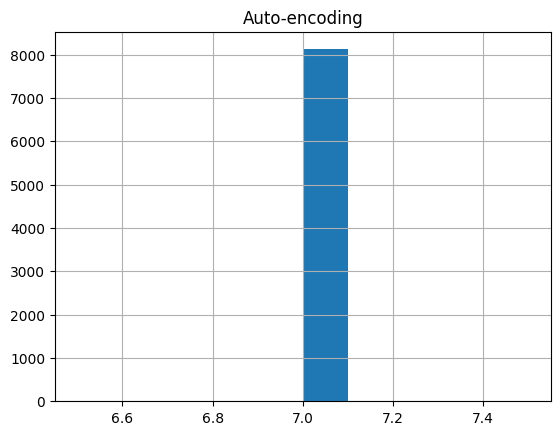

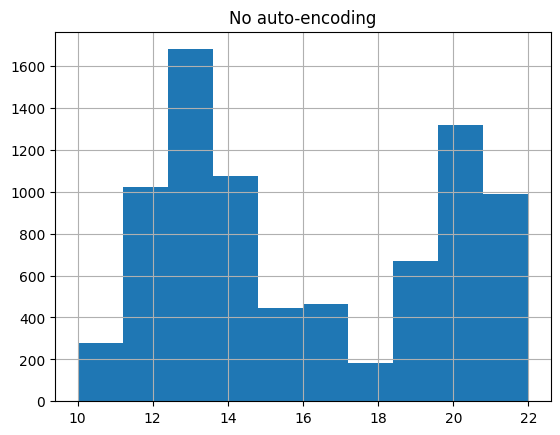

Adult :    

coverage auto-encoding: 48842, (1.0)
coverage no auto-encoding: 48842, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 9768.666666666666
average subgroup size no auto encoding: 3618.39
WRACC auto-encoding: Max: 0.027494046419569255, Mean: 1.61907524424502e-18
WRACC no auto-encoding: Max: 0.06345601575676821, Mean: 0.003816407467903789


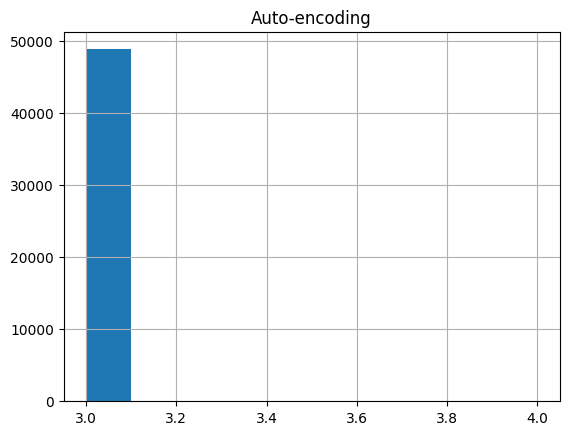

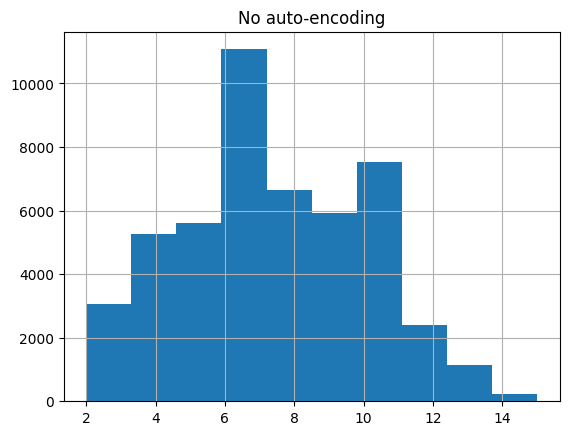

auto_encoder
coverage auto-encoding: 48842, (1.0)
coverage no auto-encoding: 48842, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 9768.666666666666
average subgroup size no auto encoding: 3618.39
WRACC auto-encoding: Max: 0.027494046419569255, Mean: 1.61907524424502e-18
WRACC no auto-encoding: Max: 0.06345601575676821, Mean: 0.003816407467903789


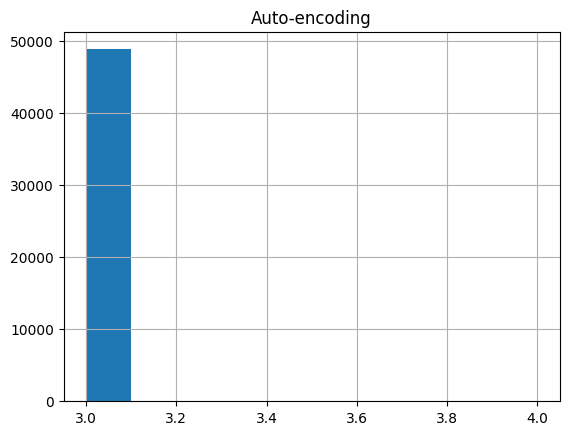

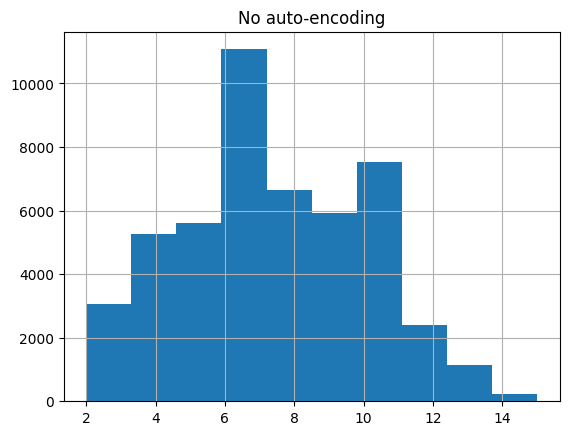

PCA
coverage auto-encoding: 48842, (1.0)
coverage no auto-encoding: 48842, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 9768.4
average subgroup size no auto encoding: 3618.39
WRACC auto-encoding: Max: 0.048272054321344286, Mean: 3.0531133177191805e-18
WRACC no auto-encoding: Max: 0.06345601575676821, Mean: 0.003816407467903789


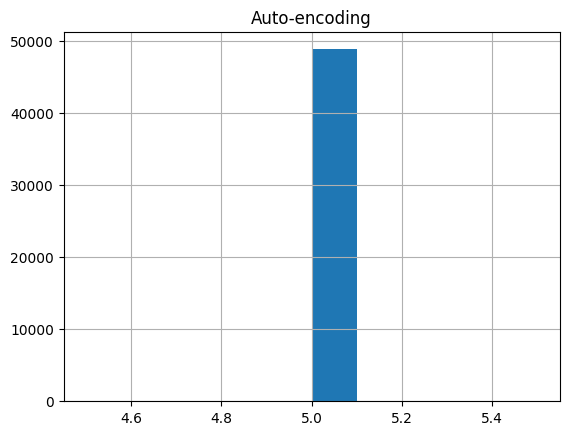

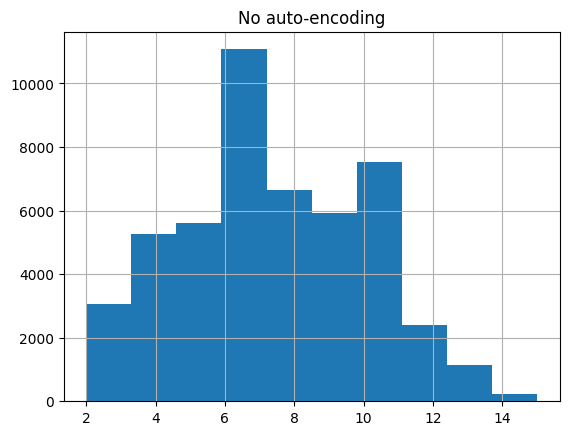

SPCA
coverage auto-encoding: 48842, (1.0)
coverage no auto-encoding: 48842, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 0, (0.0)
average subgroup size auto encoded: 9768.4
average subgroup size no auto encoding: 3618.39
WRACC auto-encoding: Max: 0.036847460733858105, Mean: 3.191891195797325e-18
WRACC no auto-encoding: Max: 0.06345601575676821, Mean: 0.003816407467903789


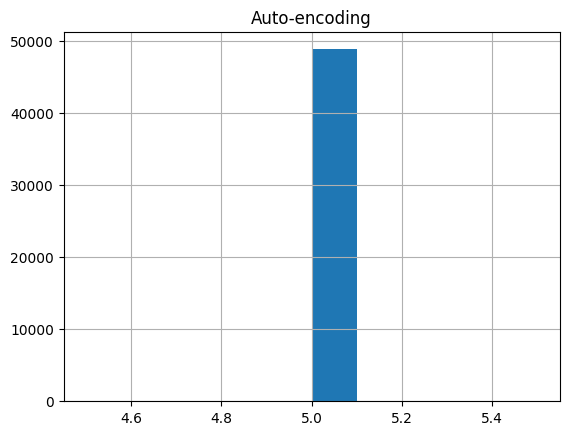

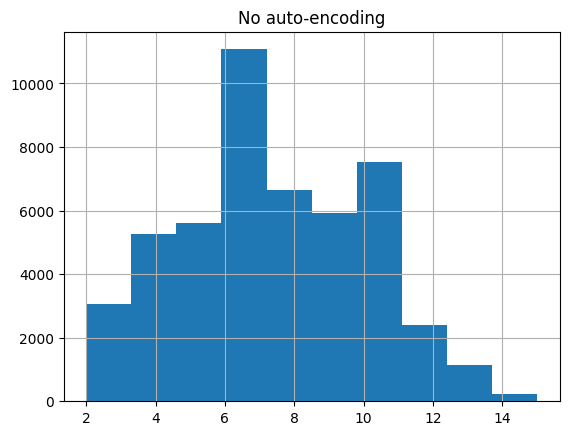

In [3]:
sd_methods = ['Beam Search', 'Depth-First Search', 'Best-First Search', 'Apriori']
output_dataframes = {}
for sd_method in sd_methods:
    print(sd_method, ":    \n\n")
    sd_results_path = r'C:\Users\20193723\OneDrive - TU Eindhoven\Documents\Research Topics in Data Mining\Interpretable-Subgroup-Discovery\results_renamed'
    dct_datasets = ['Ionosphere', 'Arrhythmia', 'Indoor', 'Soybean', 'Mushroom', 'Adult']  # to test <- Remove later
    categorical_datasets = ['Mushroom', 'Adult']
    quality_results = []
    quality_results_columns = []
    for dataset in dct_datasets:
        dataset_quality_results = []
        dataset_quality_columns = []
        #Load dataframes and results
        df_file_name = dataset+'-data-reductions.pkl'
        results_file_name = dataset+'-results.pkl'
        with open(os.path.join(sd_results_path,df_file_name), 'rb') as f:
            dfs_dict =pickle.load(f)
        with open(os.path.join(sd_results_path,results_file_name), 'rb') as f:
            results_dict =pickle.load(f)
        
        if sd_method == 'Beam Search':
            print(dataset, ":    \n")
            en_methods = ['auto_encoder', 'PCA', 'SPCA']
            subgroups_beam_en = [i for i in results_dict['auto_encoder'][sd_method]['results_org'].get_values()]
            subgroups_beam = [i for i in results_dict['vanilla'][sd_method]['results_org'].get_values()]
            output_en, output = calc_result_bs(dfs_dict['auto_encoder'], dfs_dict['vanilla'], subgroups_beam_en, subgroups_beam)
            dataset_quality_results+=output
            dataset_quality_columns += ['coverage', 'coverage_prop', 'avg_size', 'max_wracc', 'avg_wracc']
            for en_method in en_methods:
                print(en_method)
                subgroups_beam_en = [i for i in results_dict[en_method][sd_method]['results_org'].get_values()]
                subgroups_beam = [i for i in results_dict['vanilla'][sd_method]['results_org'].get_values()]
                output_en, output = calc_result_bs(dfs_dict[en_method], dfs_dict['vanilla'], subgroups_beam_en, subgroups_beam)
                dataset_quality_results+=output_en
                dataset_quality_columns += ['coverage_'+en_method, 'coverage_pop_'+en_method, 'added_'+en_method, 'added_prop_'+en_method, 'removed_'+en_method, 'removed_prop_'+en_method, 'avg_size_'+en_method, 'max_wracc_'+en_method, 'avg_wracc_'+en_method]
        
        
        if sd_method != 'Beam Search':
            print(dataset, ":    \n")
            en_methods = ['auto_encoder', 'PCA', 'SPCA']
            output_en, output = calc_result_ps(dfs_dict['auto_encoder'], dfs_dict['vanilla'], results_dict['auto_encoder'][sd_method]['results_org'], results_dict['vanilla'][sd_method]['results_org'])
            dataset_quality_results+=output
            dataset_quality_columns += ['coverage', 'coverage_prop', 'avg_size', 'max_wracc', 'avg_wracc']
            for en_method in en_methods:
                print(en_method)
                output_en, output = calc_result_ps(dfs_dict[en_method], dfs_dict['vanilla'], results_dict[en_method][sd_method]['results_org'], results_dict['vanilla'][sd_method]['results_org'])
                dataset_quality_results+=output_en
                dataset_quality_columns += ['coverage_'+en_method, 'coverage_pop_'+en_method, 'added_'+en_method, 'added_prop_'+en_method, 'removed_'+en_method, 'removed_prop_'+en_method, 'avg_size_'+en_method, 'max_wracc_'+en_method, 'avg_wracc_'+en_method]
        
        quality_results.append(dataset_quality_results)
    df = pd.DataFrame(data=quality_results, index=dct_datasets, columns=dataset_quality_columns)
    output_dataframes[sd_method] = df

In [4]:
output_dataframes['Beam Search']

coverage  coverage_prop  avg_size  max_wracc  avg_wracc  \
Ionosphere       301       0.857550    184.63   0.140770   0.131645   
Arrhythmia       187       0.445238    146.36   0.082789   0.080854   
Indoor          5553       0.263826   4235.05   0.108034   0.107908   
Soybean          266       1.000000    266.00   0.000000   0.000000   
Mushroom        4596       0.565731   4018.08   0.242026   0.226013   
Adult          22379       0.458192  20846.47   0.066375   0.065454   

            coverage_auto_encoder  coverage_pop_auto_encoder  \
Ionosphere                    263                   0.749288   
Arrhythmia                    221                   0.526190   
Indoor                      13094                   0.622102   
Soybean                       169                   0.635338   
Mushroom                     4429                   0.545175   
Adult                       12211                   0.250010   

            added_auto_encoder  added_prop_auto_encoder  removed_auto_encoder  \
Ionosphere                  15                 0.042735                    53   
Arrhythmia                 119                 0.283333                    85   
Indoor                    7574                 0.359844                    33   
Soybean                      0                 0.000000                    97   
Mushroom                  1218                 0.149926                  1385   
Adult                     5659                 0.115863                 15827   

            ...  avg_wracc_PCA  coverage_SPCA  coverage_pop_SPCA  added_SPCA  \
Ionosphere  ...       0.138172            270           0.769231          12   
Arrhythmia  ...       0.061799            210           0.500000          68   
Indoor      ...       0.208759          14450           0.686526        8898   
Soybean     ...       0.163007            152           0.571429           0   
Mushroom    ...       0.160968           4485           0.552068        1046   
Adult       ...       0.063452          25200           0.515949        7246   

            added_prop_SPCA  removed_SPCA  removed_prop_SPCA  avg_size_SPCA  \
Ionosphere         0.034188            43           0.122507         187.33   
Arrhythmia         0.161905            45           0.107143         104.12   
Indoor             0.422748             1           0.000048        7798.87   
Soybean            0.000000           114           0.428571          91.01   
Mushroom           0.128754          1157           0.142418        2844.20   
Adult              0.148356          4425           0.090598       18344.98   

            max_wracc_SPCA  avg_wracc_SPCA  
Ionosphere        0.117978        0.104207  
Arrhythmia        0.090476        0.066294  
Indoor            0.214514        0.179918  
Soybean           0.203742        0.169103  
Mushroom          0.194271        0.167028  
Adult             0.064622        0.062962  

[6 rows x 32 columns]

In [5]:
output_dataframes.keys()

dict_keys(['Beam Search', 'Depth-First Search', 'Best-First Search', 'Apriori'])

## 5. Interpretability Measures

In [6]:
sd_results_path = r'C:\Users\20193723\OneDrive - TU Eindhoven\Documents\Research Topics in Data Mining\Interpretable-Subgroup-Discovery\results_renamed'
dct_datasets = ['Ionosphere', 'Arrhythmia', 'Indoor', 'Soybean', 'Mushroom', 'Adult'] 
categorical_datasets = ['Mushroom', 'Adult']
for dataset in dct_datasets:
    #Load dataframes and results
    df_file_name = dataset+'-data-reductions.pkl'
    results_file_name = dataset+'-results.pkl'
    with open(os.path.join(sd_results_path,df_file_name), 'rb') as f:
        dfs_dict =pickle.load(f)
    with open(os.path.join(sd_results_path,results_file_name), 'rb') as f:
        results_dict =pickle.load(f)
    #One-hot encode vanilla dataframe if categorical
    original_df = dfs_dict['vanilla']
    if dataset in categorical_datasets:
       features = [i for i in original_df.columns if i !='target']
       OHenc = OneHotEncoder() 
       dataCategorical = OHenc.fit_transform(original_df[features]).toarray()
       original_df = pd.DataFrame(dataCategorical)
    #Compute and print scores and index
    print(dataset, ":    \n")
    en_methods = ['auto_encoder', 'PCA', 'SPCA']
    ps_sd_methods = ['Apriori', 'Best-First Search', 'Depth-First Search']
    for en_method in en_methods:
        fcs, fcss = Feature_Correlation_Scores(original_df, dfs_dict[en_method])
        print(en_method, ":    ", "\n   FCS: ", round(fcs, 2), "    FCSS", round(fcss, 2))
        for sd_method in ps_sd_methods:
            dbi = DBI_ps(results_dict[en_method][sd_method]['results_org'], dfs_dict[en_method])
            print("DBI "+sd_method+": ", dbi)
        subgroups_beam = [i for i in results_dict[en_method]['Beam Search']['results_org'].get_values()]
        dbi = DBI_beam(subgroups_beam, dfs_dict[en_method])
        print("DBI Beam Search: ", dbi, "\n")
    print("\n\n")

Ionosphere :    

auto_encoder :     
   FCS:  0.59     FCSS 0.12
DBI Apriori:  4.646945864519912
DBI Best-First Search:  5.07139943290663
DBI Depth-First Search:  5.10272545009937
DBI Beam Search:  2535873768269284.0 

PCA :     
   FCS:  0.65     FCSS 0.14
DBI Apriori:  5.092903665702807
DBI Best-First Search:  5.185521419525824
DBI Depth-First Search:  5.169785869741472
DBI Beam Search:  7109549144236751.0 

SPCA :     
   FCS:  0.72     FCSS 0.19
DBI Apriori:  4.9624039888134295
DBI Best-First Search:  5.5875371723275205
DBI Depth-First Search:  5.55141793938194
DBI Beam Search:  4439112319141247.5 




Arrhythmia :    

auto_encoder :     
   FCS:  0.7     FCSS 0.31
DBI Apriori:  6.575715085479953
DBI Best-First Search:  5.015702351061243
DBI Depth-First Search:  5.001287117070279
DBI Beam Search:  1.2303460544989584e+16 

PCA :     
   FCS:  0.76     FCSS 0.25
DBI Apriori:  4.77707387770815
DBI Best-First Search:  4.643100897562774
DBI Depth-First Search:  4.6467142997041755
DBI 